<a href="https://colab.research.google.com/github/nadirawijaya/Skripsi/blob/main/V4_Skripsi_Nadira_80_20_5_Fold_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;"><b>SKRIPSI</b></h1>
<h2 style="text-align:center;">
  <b>Pengaruh Seleksi Fitur IGWO terhadap Kinerja Random Forest, CatBoost, dan XGBoost<br>
  untuk Klasifikasi Penyakit Monkeypox Berdasarkan Gejala</b>
</h2>

<p style="text-align:center;">
  <b>Diajukan oleh:</b><br>
  Nadira Putri Wijaya<br>
  2106635190<br>
  <a href="mailto:nadira.putri11@ui.ac.id">nadira.putri11@ui.ac.id</a>
</p>

<p style="text-align:center;">
  <b>Dosen Pembimbing:</b><br>
  Dra. Bevina Desjwiandra Handari, M.Sc., Ph.D.
</p>

<p style="text-align:center;">
  <b>Program Studi Sarjana Matematika</b><br>
  Departemen Matematika FMIPA Universitas Indonesia<br>
  Depok, Desember 2025
</p>


## Step 1: Inisialisasi Pipeline & Manajemen Pustaka

Tahap ini adalah **persiapan awal** sebelum analisis dimulai.

* Kode akan **menginstal pustaka** yang dibutuhkan (misalnya *pandas* untuk manipulasi data, *scikit-learn* untuk machine learning, *catboost*, dan *xgboost*).
* Setelah itu, dilakukan **import fungsi-fungsi penting** (seperti `train_test_split`, `RandomForestClassifier`, dsb.) agar siap dipakai pada tahap selanjutnya.
* Selain itu, ada **pengaturan konfigurasi visualisasi** supaya hasil grafik dan output terlihat lebih rapi serta konsisten.

👉 **Tujuan:** memastikan semua *alat* yang diperlukan sudah tersedia dan lingkungan kerja siap pakai.

👉 **Kenapa penting:** tanpa instalasi & import pustaka ini, fungsi-fungsi utama tidak bisa dipanggil, sehingga analisis atau pelatihan model bisa gagal di tengah jalan.

📖 **Referensi:**
Kotsiantis, S. B., Kanellopoulos, D., & Pintelas, P. E. (2006). *Data preprocessing for supervised learning.* International Journal of Computer Science, 1(2), 111–117.
[ResearchGate Link](https://www.researchgate.net/publication/228084519_Data_Preprocessing_for_Supervised_Learning)
(Jurnal ini membahas pentingnya berbagai teknik preprocessing, termasuk pembersihan data, sebagai langkah fundamental sebelum pemodelan).

In [1]:
# =============================================================================
# STEP 1: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# =============================================================================
# STEP 1A: INSTALASI PUSTAKA YANG DIBUTUHKAN
# =============================================================================
import sys

# Cek apakah kode dijalankan di Google Colab untuk instalasi otomatis
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...")
    # Instalasi dalam mode senyap (-q) untuk output yang bersih
    !pip install pandas numpy matplotlib seaborn scikit-learn imblearn chardet catboost xgboost -q
    print("✅ Paket instalasi selesai!")
else:
    print("📘 Menjalankan di lingkungan lokal. Pastikan semua paket sudah terinstal.")

# =============================================================================
# STEP 1B: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# === 1.1 MANAJEMEN PUSTAKA & SISTEM ===
import warnings
import sys
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier # Sekarang ini tidak akan error

# Mengelola peringatan agar output lebih bersih
warnings.filterwarnings('ignore')

# === 1.2 HEADER & PENGECEKAN LINGKUNGAN ===
print("🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...")
print("="*80)

# Cek lagi untuk memastikan modul files diimpor jika di Colab
if 'google.colab' in sys.modules:
    from google.colab import files

print("\n📚 Semua pustaka berhasil diimpor.")

# === 1.3 KONFIGURASI VISUALISASI & DISPLAY ===
plt.style.use('seaborn-v0_8-whitegrid')  # Gaya plot modern & konsisten
sns.set_palette("viridis")               # Palet warna default yang menarik
pd.set_option('display.max_columns', 50) # Tampilkan hingga 50 kolom di output
pd.set_option('display.width', 120)      # Lebar tampilan output Pandas

print("🎨 Pengaturan visualisasi dan display telah diterapkan.")
print("="*80)
print("✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.")
print("="*80)

📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
✅ Paket instalasi selesai!
🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...

📚 Semua pustaka berhasil diimpor.
🎨 Pengaturan visualisasi dan display telah diterapkan.
✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.


## Step 2: Pemuatan & Pembersihan Data Global (Pra-pemisahan)

### Deskripsi Tahapan

Pada tahap ini, dataset mentah dimuat dari file CSV dan melewati serangkaian proses pembersihan dan persiapan data secara global. Proses ini krusial dan dilakukan **sebelum** data dipisah menjadi set pelatihan dan pengujian untuk memastikan konsistensi dan mencegah kebocoran data (*data leakage*).

Langkah-langkah utamanya meliputi:

1.  **Standardisasi Nama Kolom**: Mengubah semua nama kolom ke dalam format `snake_case` (huruf kecil, tanpa spasi, dan menggunakan garis bawah) untuk konsistensi dan kemudahan akses.
2.  **Penghapusan Data Tidak Relevan**: Menghapus kolom yang tidak memiliki nilai prediktif (contoh: `patient_id`) dan baris data yang terduplikasi secara penuh untuk menghindari bias pada model.
3.  **Standardisasi Nilai Kategorikal**: Menyeragamkan nilai-nilai yang memiliki makna sama tetapi ditulis berbeda. Sebagai contoh, nilai seperti `y`, `true`, dan `positive` akan distandardisasi menjadi `yes`.
4.  **Rekayasa & Imputasi Fitur (`fever`)**: Mengubah kolom `fever` yang memiliki format teks tidak terstruktur menjadi dua fitur numerik yang informatif:
    * `fever_presence`: Fitur biner (ya/tidak) yang menandakan keberadaan demam.
    * `fever_duration_days`: Fitur numerik yang merepresentasikan durasi demam dalam hari.
    * **Justifikasi Imputasi**: Jika pasien tercatat demam namun durasinya tidak spesifik, nilai durasi akan diisi (diimputasi) sebagai **1 hari**. Ini adalah pendekatan konservatif yang logis, karena jika demam ada, durasinya minimal adalah satu hari.

---

### Tujuan & Justifikasi

**Tujuan** dari tahap ini adalah untuk mentransformasi data mentah yang seringkali tidak konsisten dan "berantakan" menjadi sebuah dataset yang bersih, terstruktur, dan siap untuk tahap pemodelan *machine learning*.

**Mengapa ini penting?**
* **Mencegah Error**: Nama kolom dan nilai yang tidak konsisten dapat menyebabkan *bug* dan error pada saat analisis dan pemodelan.
* **Meningkatkan Kualitas Model**: Data duplikat dapat membuat model menjadi bias, sementara nilai yang tidak standar dapat membingungkan algoritma.
* **Memperkaya Informasi**: Rekayasa fitur mengubah data implisit menjadi sinyal eksplisit yang lebih mudah ditangkap oleh model, sehingga berpotensi meningkatkan akurasi prediksi.

---

### Referensi Akademis

* **Van den Broeck, J., et al. (2005).** *Data cleaning: detecting, diagnosing, and editing data abnormalities.* PLoS Medicine, 2(10), e267.
    *(Jurnal ini mendukung pentingnya proses pembersihan data secara sistematis—seperti standardisasi, penghapusan duplikat, dan penanganan anomali—sebagai fondasi untuk analisis data yang valid dan andal dalam penelitian medis.)*

* **Zheng, A., & Casari, A. (2018).** *Feature engineering for machine learning: principles and techniques for data scientists*. O'Reilly Media, Inc.
    *(Buku ini merupakan referensi standar yang memvalidasi praktik rekayasa fitur. Transformasi kolom `fever` adalah contoh klasik dari rekayasa fitur, di mana domain knowledge digunakan untuk mengekstrak informasi yang lebih bermakna dari data mentah.)*

🚀 Memulai Pipeline Data Loading & Global Pre-Processing...

📤 Silakan upload CSV Anda...


Saving MonkeyPox Dataset Skripsi.csv to MonkeyPox Dataset Skripsi.csv
🔄 Loading CSV: 'MonkeyPox Dataset Skripsi.csv'...
✅ Berhasil load. Bentuk awal: (500, 50)

🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼
GLOBAL DATA PRE-PROCESSING (PRE-SPLIT)
🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼
--- 1. Pembersihan Awal (Nama Kolom & Duplikat) ---
✅ Nama kolom dibersihkan dan 0 duplikat dihapus.

--- 2. Standardisasi Nilai Komprehensif ---
   - Menangani kasus khusus seperti 'fever'...
     ✅ Fitur 'fever' diubah menjadi 'fever_presence' dan 'fever_duration_days'.
   - Menerapkan aturan standardisasi umum ('y' -> 'yes', 'none' -> 'no', dll.)...
✅ Proses standardisasi nilai selesai.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
LAPORAN KOMPREHENSIF STANDARDIZASI NILAI
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
Ditemukan 19 kolom dengan nilai yang berhasil distandardisasi.

------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'smallpox_vaccination_history'
   - Nilai unik

,Before,After
smallpox_vaccination_history,,
none,340,0
mva six days post exposure or 12 days pre-illness,159,159
mva six days post-exposure or 12 days pre-illness,1,1
no,0,340


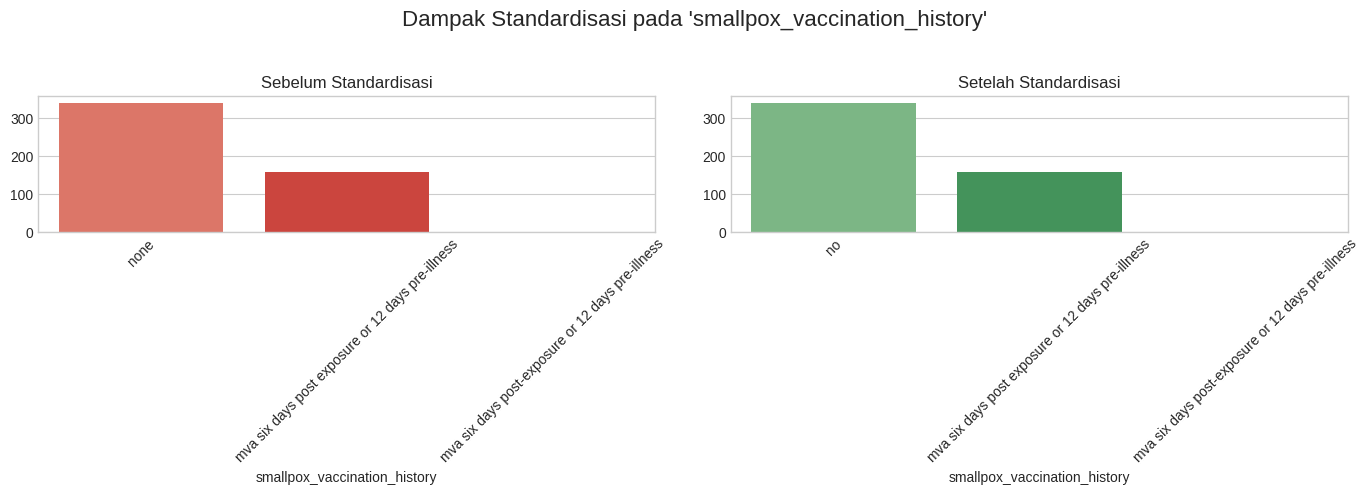


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'hiv_hepatitis_b_and_hepatitis_c_status'
   - Nilai unik berkurang dari 3 menjadi 3.


,Before,After
hiv_hepatitis_b_and_hepatitis_c_status,,
positive,306,0
negative,191,0
not tested (parents negative),3,3
yes,0,306
no,0,191


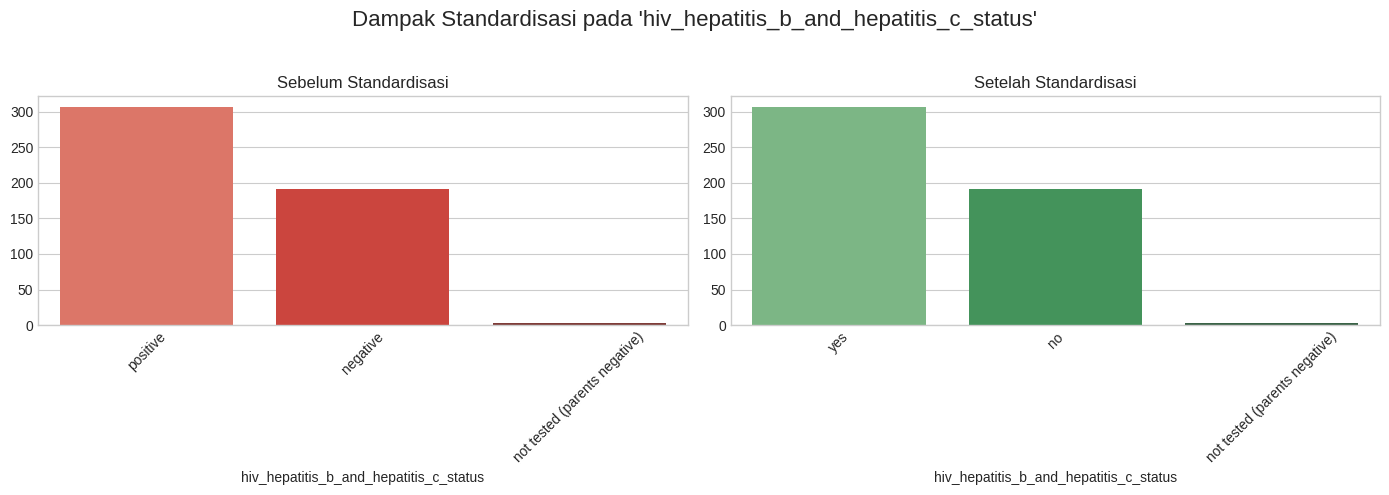


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'rectal_pain_or_pain_on_defecation'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
rectal_pain_or_pain_on_defecation,,
none,321,0
yes,179,179
no,0,321


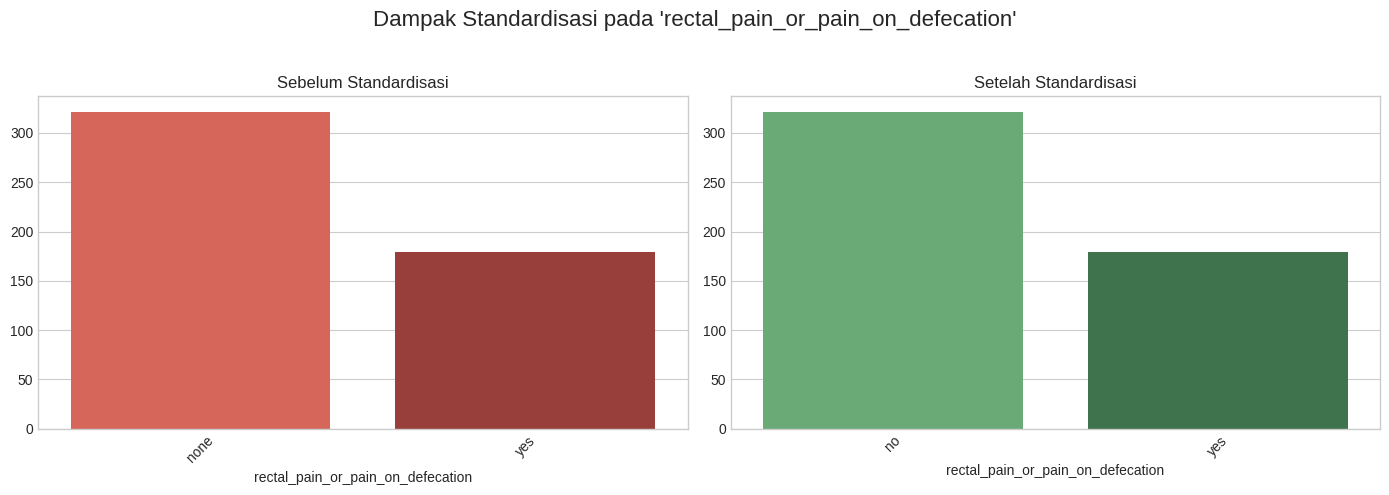


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'dysuria'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
dysuria,,
none,387,0
yes,113,113
no,0,387


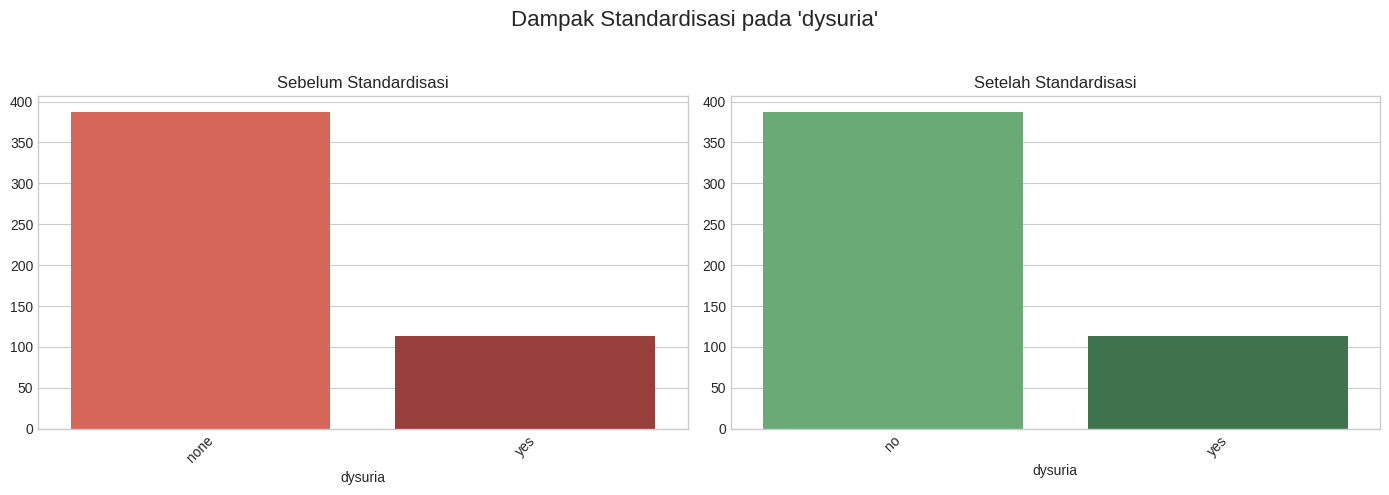


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'bleedingdischarge_per_rectum'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
bleedingdischarge_per_rectum,,
none,451,0
yes,49,49
no,0,451


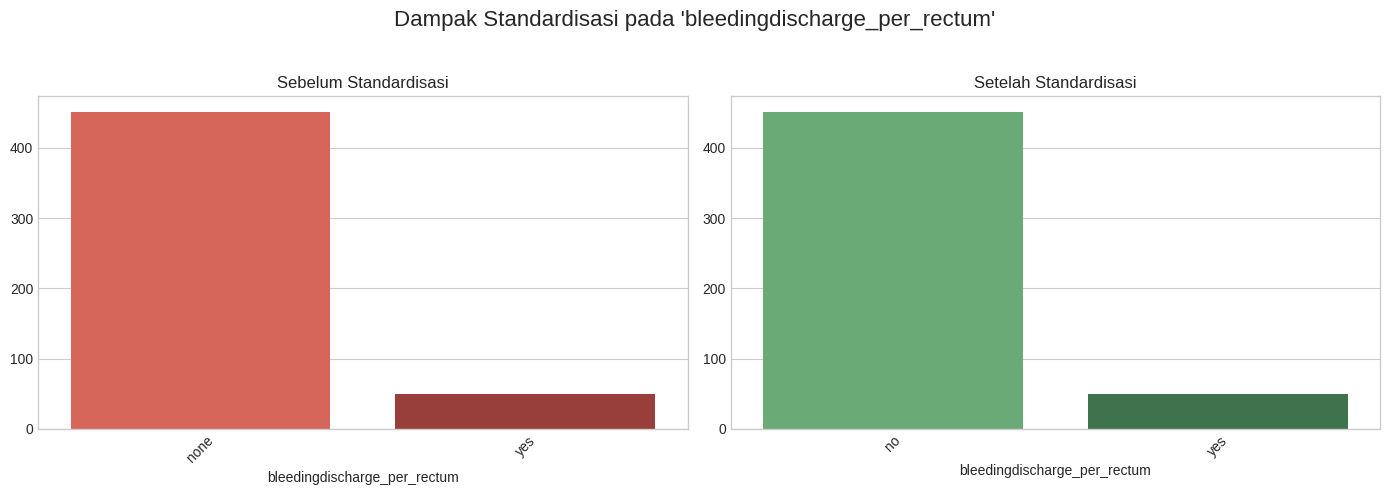


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'conjunctivitis'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
conjunctivitis,,
yes,251,251
none,249,0
no,0,249


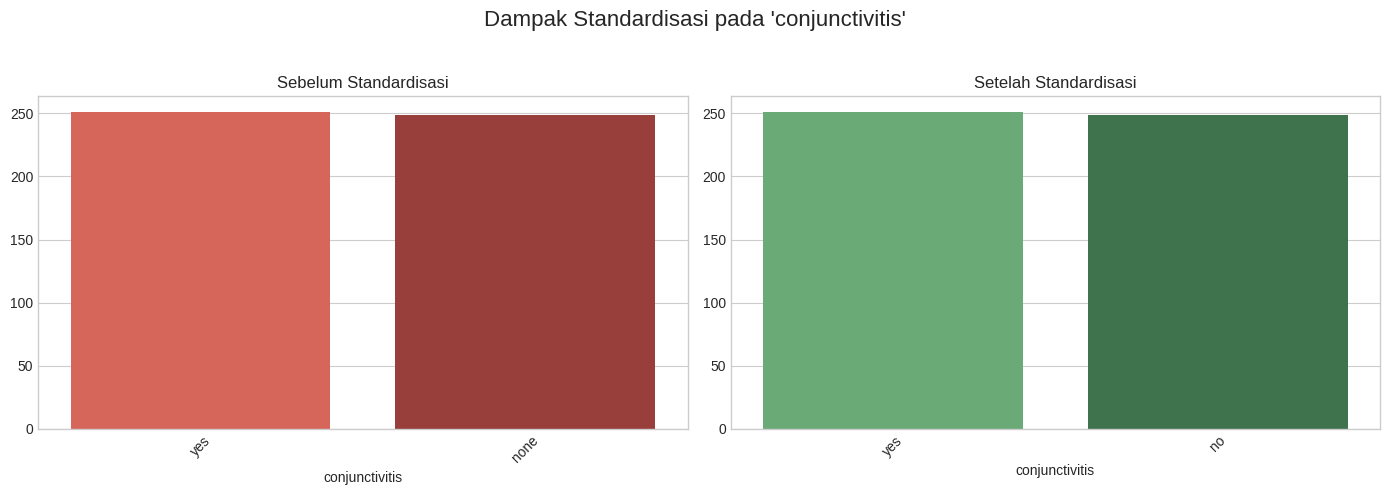


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'back_pain'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
back_pain,,
yes,352,352
none,148,0
no,0,148


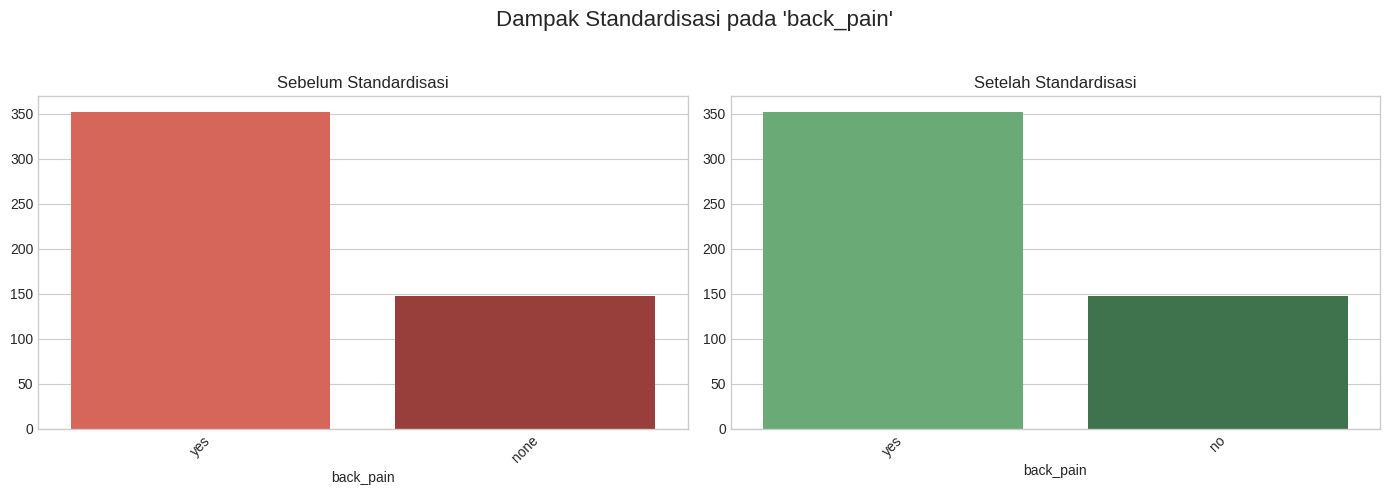


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'myalgia'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
myalgia,,
yes,393,393
none,107,0
no,0,107


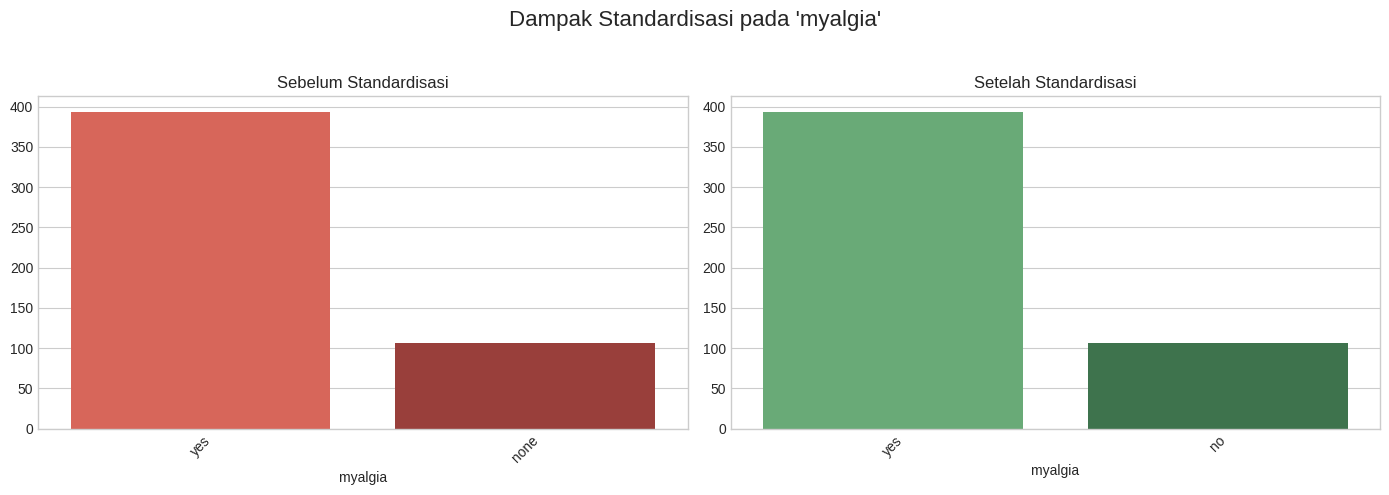


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'headache'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
headache,,
yes,377,377
none,123,0
no,0,123


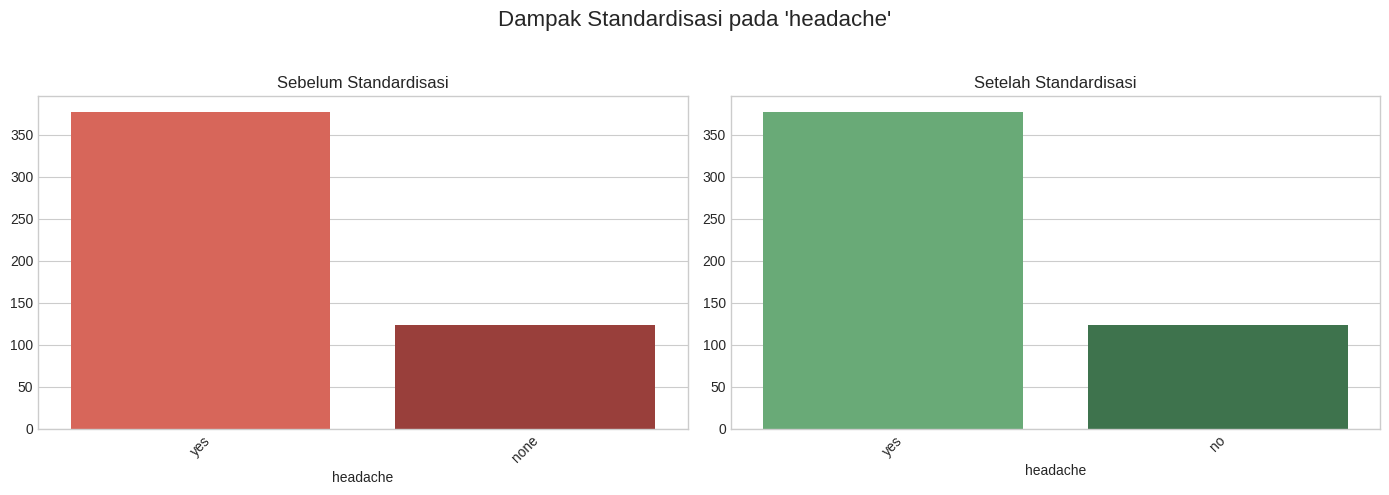


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'lymphadenopathy'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
lymphadenopathy,,
yes,314,314
none,186,0
no,0,186


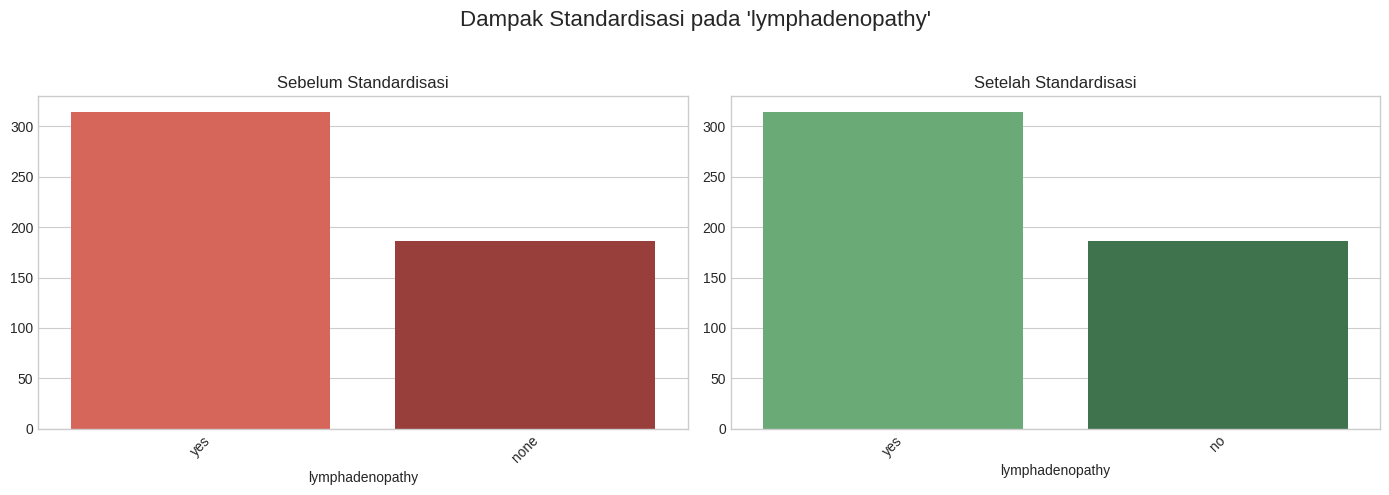


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'complications_of_illness'
   - Nilai unik berkurang dari 7 menjadi 7.


,Before,After
complications_of_illness,,
low mood and emotional lability. ulcerated inguinal lesion with delayed healing,124,124
"deep tissue abscesses, severe pain, and low mood",102,102
"conjunctivitis, painful disruption of thumbnail from subungual lesion",43,43
low mood,15,15
ulcerated inguinal lesion with delayed healing,5,5
pruritis and contact dermatitis from cleaning products,5,5
none,3,0
no,0,3


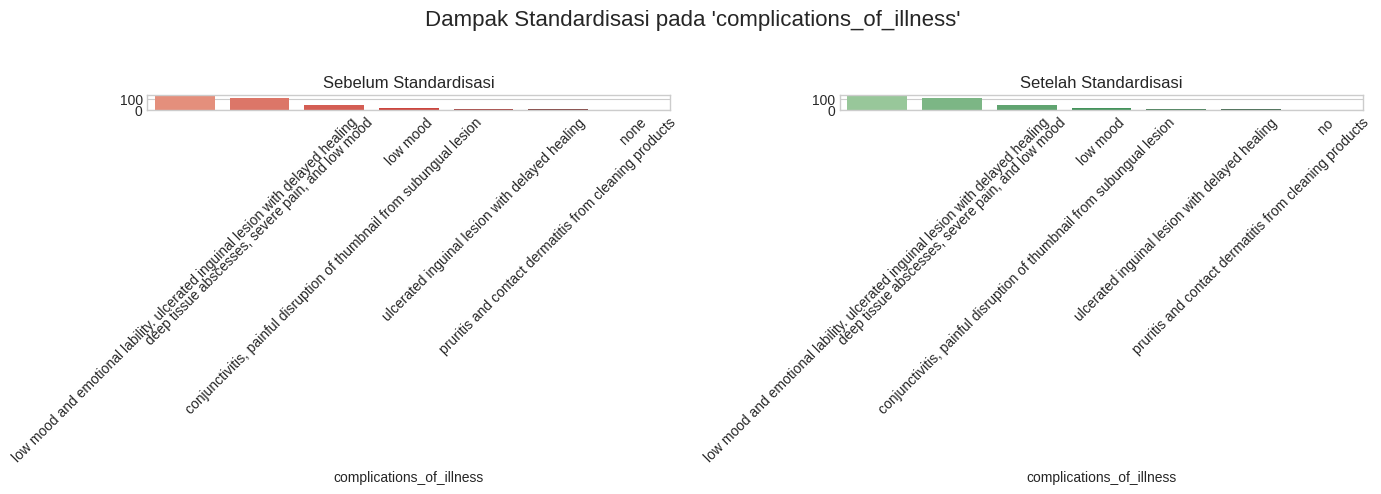


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'monkeypox_viral_dna_detected_in_blood'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
monkeypox_viral_dna_detected_in_blood,,
none,274,0
yes,226,226
no,0,274


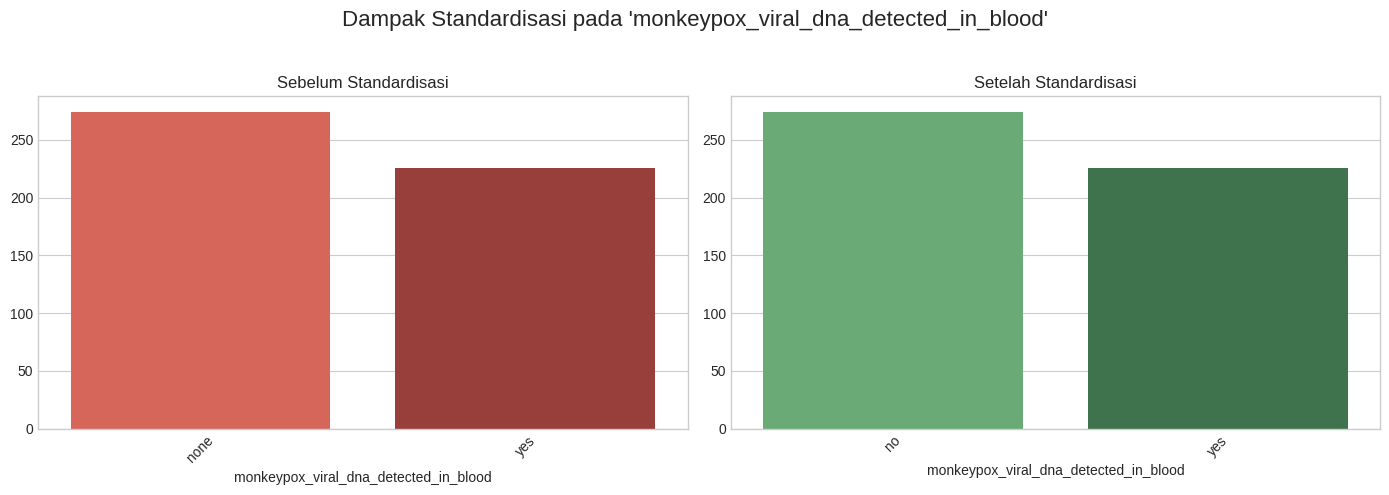


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'monkeypox_viral_dna_detected_in_nose_or_throat_swab'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
monkeypox_viral_dna_detected_in_nose_or_throat_swab,,
yes,434,434
none,66,0
no,0,66


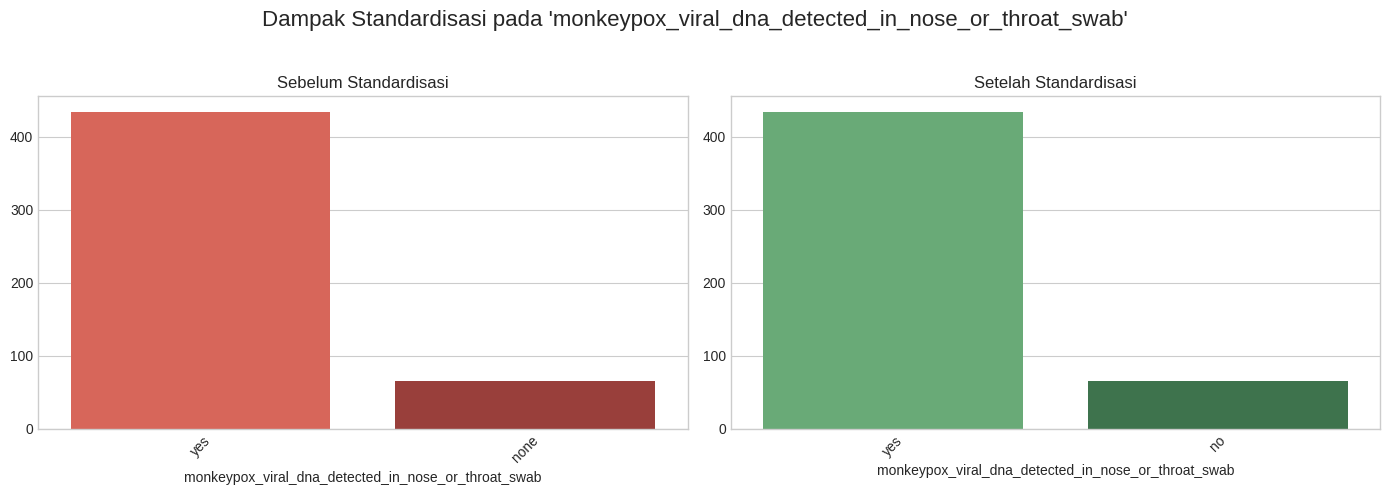


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'monkeypox_viral_dna_detected_in_urine'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
monkeypox_viral_dna_detected_in_urine,,
yes,405,405
none,95,0
no,0,95


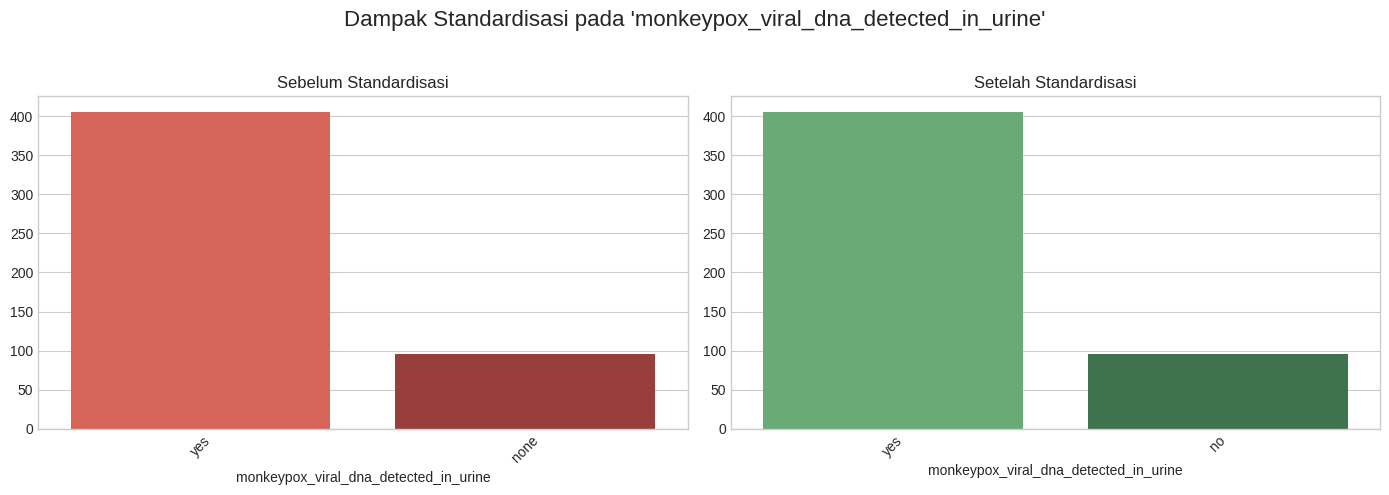


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'antivirals_received'
   - Nilai unik berkurang dari 5 menjadi 5.


,Before,After
antivirals_received,,
brincidofovir 200 mg (three dose) orally,147,147
brincidofovir 200 mg (two dose) orally,140,140
brincidofovir 200 mg (one dose) orally,124,124
none,72,0
tecovirimat 600 mg twice daily for 2 weeks orally,17,17
no,0,72


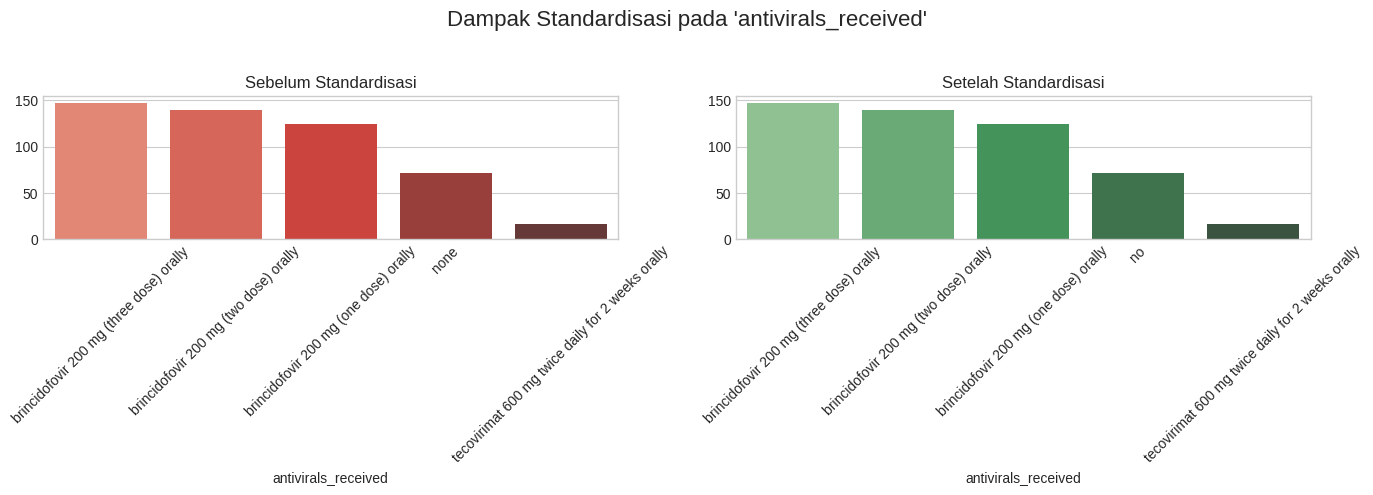


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'complications_of_treatment'
   - Nilai unik berkurang dari 4 menjadi 4.


,Before,After
complications_of_treatment,,
none,235,0
transaminitis (peak alt 331 u/l),122,122
"transaminitis (peak alt 127 u/l), nausea, and abdominal discomfort",103,103
transaminitis (peak alt 550 u/l),40,40
no,0,235


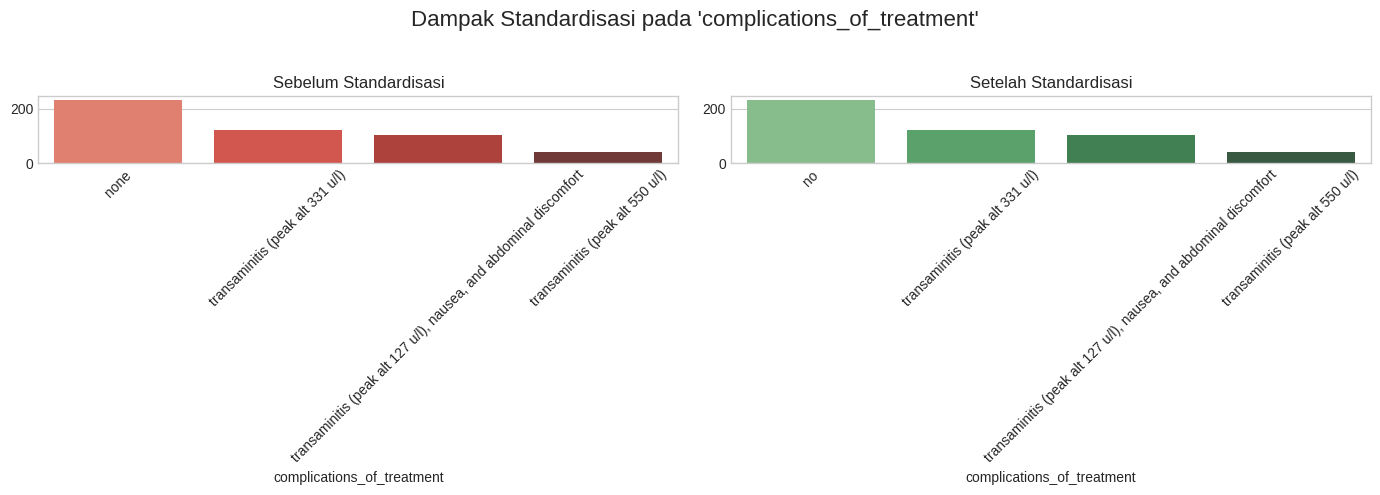


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'sore_throat'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
sore_throat,,
yes,358,358
none,142,0
no,0,142


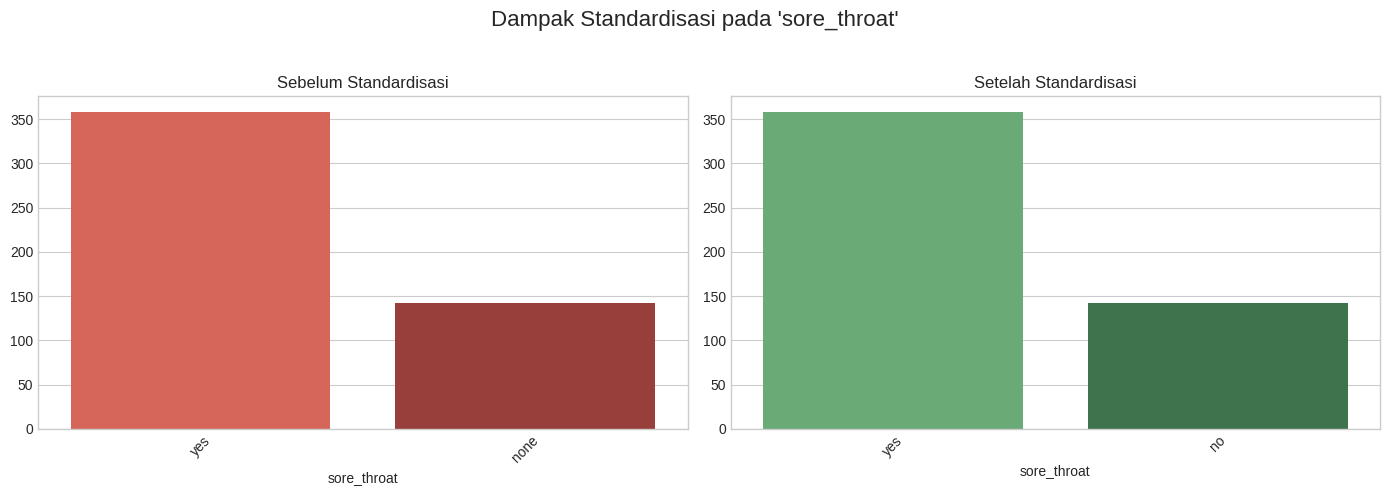


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'chills'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
chills,,
none,360,0
yes,140,140
no,0,360


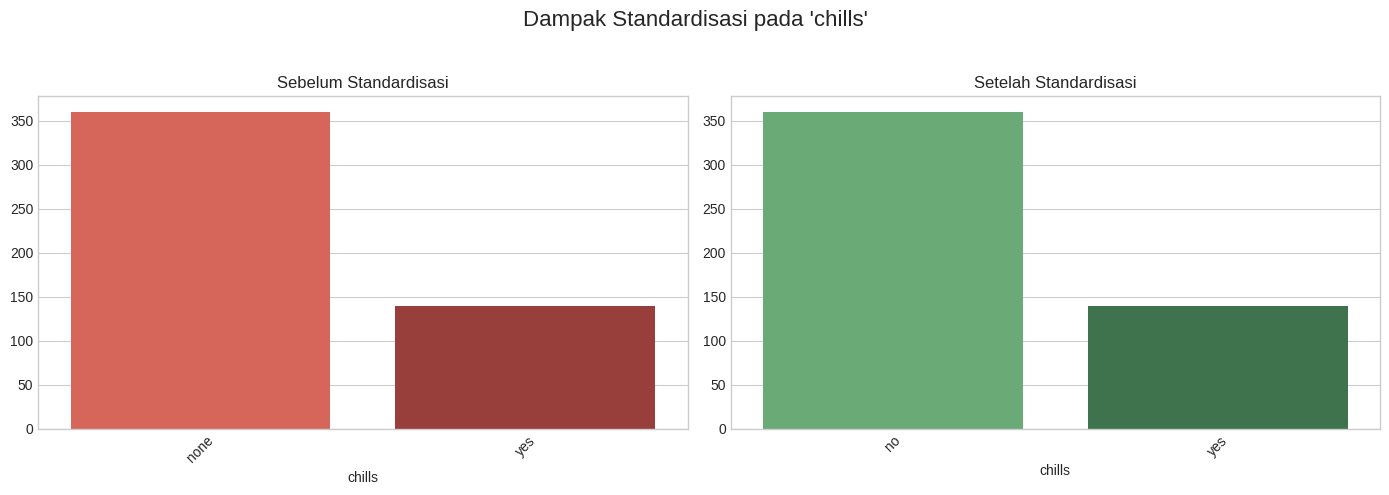


------------------------------------------------------------
🔎 Laporan Detail untuk Kolom: 'diagnosing'
   - Nilai unik berkurang dari 2 menjadi 2.


,Before,After
diagnosing,,
positive,297,0
negative,203,0
yes,0,297
no,0,203


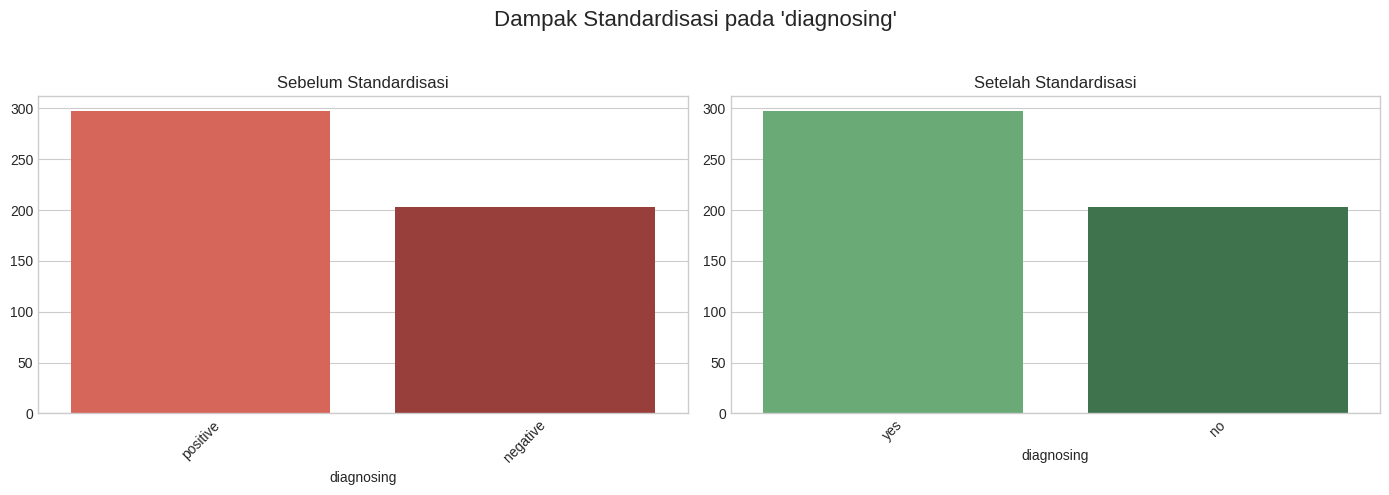


📊 Final Overview after Pre-Processing:
   - Data shape: (500, 50)


,age,sex,transmission_rank,country_of_acquisition,smallpox_vaccination_history,hiv_hepatitis_b_and_hepatitis_c_status,rectal_pain_or_pain_on_defecation,dysuria,bleedingdischarge_per_rectum,conjunctivitis,oropharyngeal_manifestations,back_pain,myalgia,headache,sexually_transmitted_infections,lymphadenopathy,approximate_maximum_number_of_concurrent_lesions,distribution_of_lesions,complications_of_illness,monkeypox_viral_dna_detected_in_blood,monkeypox_viral_dna_detected_in_nose_or_throat_swab,monkeypox_viral_dna_detected_in_urine,antivirals_received,day_of_illness_treatment_commenced,complications_of_treatment,duration_of_hospitalization_with_monkeypox_days,sore_throat,chills,wbc_count_cellsmm3_normaladult_range__40009000,hematocrit_normal_3949_for_men_and3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range__136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,hospitalized,date_confirmation,rtpcr,outcome_of_monkeypox_infection,diagnosing,diagnosed_disease,fever_presence,fever_duration_days
0,49,female,isolated,nigeria,no,no,yes,no,no,yes,tonsillar erythema,no,yes,yes,rectum,yes,150,"face, scalp, trunk, limbs, palms, glans penis,...",low mood and emotional lability. ulcerated ing...,yes,yes,yes,brincidofovir 200 mg (one dose) orally,7,transaminitis (peak alt 331 u/l),26,yes,yes,22135,48,109,129,2.4,8.4,2.2,8.2,1.0,41,37,147,10.0,2.5,yes,5/6/2022,yes,full recovery,yes,monkeypox,yes,2
1,52,female,index,spain,no,yes,no,yes,no,yes,abscess,yes,no,no,purulent penile discharge.,no,40,"face, trunk, arms, and legs","deep tissue abscesses, severe pain, and low mood",no,no,yes,no,7,"transaminitis (peak alt 127 u/l), nausea, and ...",15,yes,no,14026,48,138,131,1.9,8.4,1.8,7.3,1.1,42,37,145,9.8,1.9,yes,8/31/2022,no,full recovery,yes,monkeypox,yes,1
2,76,male,index,nigeria,no,no,yes,no,yes,yes,pustules,yes,yes,no,throat,yes,100,"face, trunk, limbs, palms, soles, and scrotum","deep tissue abscesses, severe pain, and low mood",yes,yes,yes,brincidofovir 200 mg (two dose) orally,6,transaminitis (peak alt 550 u/l),27,yes,no,26742,56,131,117,2.9,8.3,1.5,6.1,1.0,38,42,149,11.0,2.8,yes,5/12/2022,yes,full recovery,yes,monkeypox,yes,4
3,42,female,secondary,nigeria,mva six days post-exposure or 12 days pre-illness,yes,no,yes,no,no,oedema,yes,no,yes,urethra/urine,no,32,"face, trunk, hands (including nail bed), and l...","conjunctivitis, painful disruption of thumbnai...",yes,yes,yes,brincidofovir 200 mg (two dose) orally,7,"transaminitis (peak alt 127 u/l), nausea, and ...",35,yes,no,24688,49,115,126,2.4,7.8,1.7,8.3,1.6,43,41,143,6.6,2.0,yes,8/13/2022,yes,full recovery,yes,monkeypox,yes,1
4,67,male,isolated,nigeria,no,no,no,yes,no,yes,abscess,no,yes,no,multiple site,yes,100,"face, scalp, trunk, limbs, penile shaft, palms...",ulcerated inguinal lesion with delayed healing,yes,yes,yes,brincidofovir 200 mg (two dose) orally,7,no,39,yes,yes,20346,52,144,126,3.3,7.9,1.8,7.7,1.4,43,38,143,7.0,2.7,yes,5/15/2022,no,full recovery,yes,monkeypox,yes,2



🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
   - Target (y) ditetapkan sebagai: 'diagnosing'

   - X_initial shape: (500, 49)
   - y_initial shape: (500,)

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
STEP 2: GLOBAL PRE-PROCESSING COMPLETED! DATA IS READY FOR SPLITTING.
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [2]:
# =============================================================================
# STEP 2: DATA LOADING & GLOBAL PRE-PROCESSING (COMPREHENSIVE STANDARDIZATION)
# =============================================================================
import pandas as pd
import numpy as np
import sys
import re
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# --- Pastikan modul Colab dikenali ---
if 'google.colab' in sys.modules:
    from google.colab import files

# === 2.1 LOADER CLASS ===
class EnhancedCSVLoader:
    """Loader CSV yang sudah disederhanakan dan lebih tangguh."""
    def load_csv(self, file_path):
        print(f"🔄 Loading CSV: '{file_path}'...")
        encoding = 'utf-8'
        try:
            with open(file_path, 'rb') as f:
                encoding = chardet.detect(f.read(30000))['encoding']
        except Exception:
            print("   - Warning: Gagal deteksi encoding, default ke utf-8.")
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Berhasil load. Bentuk awal: {df.shape}")
            return df
        except Exception:
            try:
                print(f"   - Gagal dengan encoding '{encoding}', mencoba fallback 'latin1'...")
                df = pd.read_csv(file_path, encoding='latin1')
                print(f"✅ Berhasil load dengan fallback 'latin1'. Bentuk awal: {df.shape}")
                return df
            except Exception as e2:
                print(f"❌ Gagal load: {e2}"); return None

# === 2.2 PRE-PROCESSING CLASS WITH ENHANCED STANDARDIZATION ===
class DataPreparer:
    """
    Melakukan semua persiapan data yang aman dilakukan SEBELUM data dipisah (splitting),
    dengan logika standardisasi dan rekayasa fitur yang komprehensif.
    """
    def __init__(self, df):
        self.df = df.copy()
        self.report_data = []

    def run(self):
        print("\n" + "🧼"*40 + "\nGLOBAL DATA PRE-PROCESSING (PRE-SPLIT)\n" + "🧼"*40)
        self._initial_cleaning()
        self._standardize_values()
        self._generate_report_and_visuals()
        print("\n📊 Final Overview after Pre-Processing:")
        print(f"   - Data shape: {self.df.shape}")
        display(self.df.head())
        return self.df

    def _initial_cleaning(self):
        print("--- 1. Pembersihan Awal (Nama Kolom & Duplikat) ---")
        cleaned_columns = {col: re.sub(r'[^a-z0-9_]', '', col.strip().lower().replace(' ', '_')) for col in self.df.columns}
        self.df.rename(columns=cleaned_columns, inplace=True)
        id_cols = ['id', 'patient_id']
        self.df.drop(columns=[c for c in id_cols if c in self.df.columns], inplace=True, errors='ignore')
        n_dupes = self.df.duplicated().sum()
        self.df.drop_duplicates(keep='first', inplace=True)
        print(f"✅ Nama kolom dibersihkan dan {n_dupes} duplikat dihapus.")

    def _standardize_values(self):
        print("\n--- 2. Standardisasi Nilai Komprehensif ---")

        # --- Bagian A: Penanganan Kasus Khusus (contoh: 'fever') ---
        print("   - Menangani kasus khusus seperti 'fever'...")
        if 'fever' in self.df.columns:
            # Buat kolom baru untuk keberadaan dan durasi demam
            self.df['fever_presence'] = 'no'
            self.df['fever_duration_days'] = 0

            # Ubah nilai 'fever' menjadi string lowercase untuk konsistensi
            fever_series = self.df['fever'].astype(str).str.lower()

            # Tentukan keberadaan demam
            self.df.loc[fever_series.str.contains('yes|coryzal', na=False), 'fever_presence'] = 'yes'

            # Ekstrak durasi demam menggunakan regular expression
            # \d+ cocok dengan satu atau lebih digit (angka)
            durations = fever_series.str.extract(r'\((\d+)\s*day').astype(float)
            self.df['fever_duration_days'] = durations[0]

            # Isi NaN di durasi: jika demam ada tapi tidak ada durasi, anggap 1 hari. Jika tidak, 0.
            self.df['fever_duration_days'] = self.df.apply(
                lambda row: 1 if pd.isna(row['fever_duration_days']) and row['fever_presence'] == 'yes' else row['fever_duration_days'],
                axis=1
            ).fillna(0).astype(int)

            # Hapus kolom 'fever' asli
            self.df.drop(columns=['fever'], inplace=True)
            print("     ✅ Fitur 'fever' diubah menjadi 'fever_presence' dan 'fever_duration_days'.")

        # --- Bagian B: Standardisasi Nilai Umum ---
        print("   - Menerapkan aturan standardisasi umum ('y' -> 'yes', 'none' -> 'no', dll.)...")
        for col in self.df.select_dtypes(include='object').columns:
            self.df[col] = self.df[col].str.lower().str.strip()

        replace_map = {
            'y': 'yes', 'true': 'yes', '1': 'yes', 'positive': 'yes', 'present': 'yes', 'detected': 'yes',
            'n': 'no', 'false': 'no', '0': 'no', 'negative': 'no', 'absent': 'no', 'not detected': 'no', 'none': 'no',
            'm': 'male', 'man': 'male', 'f': 'female', 'woman': 'female',
            'na': 'unknown', 'n/a': 'unknown', 'not specified': 'unknown', '?': 'unknown'
        }

        # Lakukan pelaporan sebelum replace
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            before_counts = self.df[col].value_counts()
            # Terapkan replace hanya untuk kolom yang sedang diiterasi
            self.df[col] = self.df[col].replace(replace_map)
            after_counts = self.df[col].value_counts()
            if not before_counts.equals(after_counts):
                self.report_data.append({
                    'column': col, 'before_counts': before_counts, 'after_counts': after_counts,
                    'unique_before': len(before_counts), 'unique_after': len(after_counts)
                })
        print("✅ Proses standardisasi nilai selesai.")

    def _generate_report_and_visuals(self):
        # (Fungsi laporan ini tetap sama seperti sebelumnya, tidak perlu diubah)
        print("\n" + "📋"*40); print("LAPORAN KOMPREHENSIF STANDARDIZASI NILAI"); print("📋"*40)
        if not self.report_data:
            print("✅ Tidak ada nilai yang memerlukan standardisasi. Semua data kategorikal sudah bersih.")
            return
        print(f"Ditemukan {len(self.report_data)} kolom dengan nilai yang berhasil distandardisasi.")
        for report in self.report_data:
            col, before_df, after_df = report['column'], report['before_counts'].to_frame('Before'), report['after_counts'].to_frame('After')
            comparison_df = pd.concat([before_df, after_df], axis=1).fillna(0).astype(int)
            print("\n" + "-"*60); print(f"🔎 Laporan Detail untuk Kolom: '{col}'"); print(f"   - Nilai unik berkurang dari {report['unique_before']} menjadi {report['unique_after']}.")
            display(comparison_df)
            fig, axes = plt.subplots(1, 2, figsize=(14, 5)); fig.suptitle(f"Dampak Standardisasi pada '{col}'", fontsize=16)
            sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Sebelum Standardisasi"); axes[0].tick_params(axis='x', rotation=45)
            sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("Setelah Standardisasi"); axes[1].tick_params(axis='x', rotation=45)
            plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# =============================================================================
# MAIN FUNCTION & EXECUTION
# =============================================================================
def main_data_loader_and_preparer():
    print("🚀 Memulai Pipeline Data Loading & Global Pre-Processing..."); print("="*80)
    df = None
    if 'google.colab' in sys.modules:
        try:
            print("\n📤 Silakan upload CSV Anda..."); uploaded = files.upload()
            if not uploaded: print("🚫 Tidak ada file diupload."); return None
            file_name = next(iter(uploaded))
            df = EnhancedCSVLoader().load_csv(file_name)
        except Exception as e: print(f"💥 Error saat upload: {e}"); return None
    else:
        file_name = 'MonkeyPox Dataset Skripsi.csv'
        df = EnhancedCSVLoader().load_csv(file_name)

    if df is not None:
        if "Monkeypox" in df.columns:
            df.rename(columns={"Monkeypox": "diagnosing"}, inplace=True)
        return DataPreparer(df).run()
    return None

# --- Jalankan pipeline utama ---
df_prepared = main_data_loader_and_preparer()

# =============================================================================
# PEMISAHAN FITUR & TARGET (untuk input ke Step 3)
# =============================================================================
if df_prepared is not None:
    print("\n" + "🎯"*40); print("FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)"); print("🎯"*40)
    TARGET_COLUMN = 'diagnosing'
    if TARGET_COLUMN in df_prepared.columns:
        X_initial = df_prepared.drop(columns=[TARGET_COLUMN], errors='ignore')
        y_initial = df_prepared[TARGET_COLUMN]
        print(f"   - Target (y) ditetapkan sebagai: '{TARGET_COLUMN}'")
        print(f"\n   - X_initial shape: {X_initial.shape}"); print(f"   - y_initial shape: {y_initial.shape}")
        print("\n" + "✅"*60); print("STEP 2: GLOBAL PRE-PROCESSING COMPLETED! DATA IS READY FOR SPLITTING."); print("✅"*60)
    else:
        print(f"🛑 GAGAL: Kolom target '{TARGET_COLUMN}' tidak ditemukan.")
else:
    print("\n" + "🛑"*60); print("STEP 2 FAILED. Periksa error di atas."); print("🛑"*60)

In [3]:
# Menampilkan 10 baris pertama dari tabel fitur (X_initial)
display(X_initial.head(10))

# Menampilkan 10 baris pertama dari tabel target (y_initial)
display(y_initial.head(10))

,age,sex,transmission_rank,country_of_acquisition,smallpox_vaccination_history,hiv_hepatitis_b_and_hepatitis_c_status,rectal_pain_or_pain_on_defecation,dysuria,bleedingdischarge_per_rectum,conjunctivitis,oropharyngeal_manifestations,back_pain,myalgia,headache,sexually_transmitted_infections,lymphadenopathy,approximate_maximum_number_of_concurrent_lesions,distribution_of_lesions,complications_of_illness,monkeypox_viral_dna_detected_in_blood,monkeypox_viral_dna_detected_in_nose_or_throat_swab,monkeypox_viral_dna_detected_in_urine,antivirals_received,day_of_illness_treatment_commenced,complications_of_treatment,duration_of_hospitalization_with_monkeypox_days,sore_throat,chills,wbc_count_cellsmm3_normaladult_range__40009000,hematocrit_normal_3949_for_men_and3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range__136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,hospitalized,date_confirmation,rtpcr,outcome_of_monkeypox_infection,diagnosed_disease,fever_presence,fever_duration_days
0,49,female,isolated,nigeria,no,no,yes,no,no,yes,tonsillar erythema,no,yes,yes,rectum,yes,150,"face, scalp, trunk, limbs, palms, glans penis,...",low mood and emotional lability. ulcerated ing...,yes,yes,yes,brincidofovir 200 mg (one dose) orally,7,transaminitis (peak alt 331 u/l),26,yes,yes,22135,48,109,129,2.4,8.4,2.2,8.20,1.0,41,37,147,10.0,2.5,yes,5/6/2022,yes,full recovery,monkeypox,yes,2
1,52,female,index,spain,no,yes,no,yes,no,yes,abscess,yes,no,no,purulent penile discharge.,no,40,"face, trunk, arms, and legs","deep tissue abscesses, severe pain, and low mood",no,no,yes,no,7,"transaminitis (peak alt 127 u/l), nausea, and ...",15,yes,no,14026,48,138,131,1.9,8.4,1.8,7.30,1.1,42,37,145,9.8,1.9,yes,8/31/2022,no,full recovery,monkeypox,yes,1
2,76,male,index,nigeria,no,no,yes,no,yes,yes,pustules,yes,yes,no,throat,yes,100,"face, trunk, limbs, palms, soles, and scrotum","deep tissue abscesses, severe pain, and low mood",yes,yes,yes,brincidofovir 200 mg (two dose) orally,6,transaminitis (peak alt 550 u/l),27,yes,no,26742,56,131,117,2.9,8.3,1.5,6.10,1.0,38,42,149,11.0,2.8,yes,5/12/2022,yes,full recovery,monkeypox,yes,4
3,42,female,secondary,nigeria,mva six days post-exposure or 12 days pre-illness,yes,no,yes,no,no,oedema,yes,no,yes,urethra/urine,no,32,"face, trunk, hands (including nail bed), and l...","conjunctivitis, painful disruption of thumbnai...",yes,yes,yes,brincidofovir 200 mg (two dose) orally,7,"transaminitis (peak alt 127 u/l), nausea, and ...",35,yes,no,24688,49,115,126,2.4,7.8,1.7,8.30,1.6,43,41,143,6.6,2.0,yes,8/13/2022,yes,full recovery,monkeypox,yes,1
4,67,male,isolated,nigeria,no,no,no,yes,no,yes,abscess,no,yes,no,multiple site,yes,100,"face, scalp, trunk, limbs, penile shaft, palms...",ulcerated inguinal lesion with delayed healing,yes,yes,yes,brincidofovir 200 mg (two dose) orally,7,no,39,yes,yes,20346,52,144,126,3.3,7.9,1.8,7.70,1.4,43,38,143,7.0,2.7,yes,5/15/2022,no,full recovery,monkeypox,yes,2
5,74,female,index,uk,no,no,no,yes,no,no,tonsillar erythema,yes,yes,yes,throat,yes,40,"face, trunk, limbs, palms, and penile shaft",no,no,yes,no,no,10,no,13,no,yes,21414,48,123,110,3.1,7.6,1.6,8.80,1.8,43,39,141,7.6,2.9,yes,5/15/2022,yes,full recovery,monkeypox,no,0
6,78,male,tertiary,nigeria,no,not tested (parents negative),no,no,yes,yes,pustules,yes,yes,no,unknown,yes,30,"face, trunk, arms, and legs",pruritis and contact dermatitis from cleaning ...,yes,yes,no,no,4,no,22,yes,no,14649,58,131,130,2.9,7.7,2.1,8.50,1.2,39,38,141,6.8,2.7,yes,6/19/2022,no,full recovery,monkeypox,no,0
7,44,female,secondary,spain,no,n

,diagnosing
0,yes
1,yes
2,yes
3,yes
4,yes
5,yes
6,yes
7,yes
8,yes
9,no


## Step 3: Pembagian Data (Train-Test Split 80/20)

### Apa yang dilakukan?

Dataset dibagi menjadi dua bagian dengan rasio **80/20**:

1. **Data Latih (80%)** → digunakan untuk proses pembelajaran (training, validasi silang, dan *hyperparameter tuning*).
2. **Data Uji (20%)** → dipisahkan sejak awal dan tidak pernah dilihat model hingga tahap evaluasi akhir.

Pembagian dilakukan dengan **stratifikasi** (`stratify=y`) agar distribusi kelas target pada data latih dan data uji tetap sama dengan dataset asli.

### Untuk apa?

Untuk menyediakan data khusus (20%) yang berfungsi sebagai **“ujian akhir”**. Data ini hanya dipakai sekali di tahap akhir untuk menilai performa model pada data yang benar-benar baru.

### Kenapa perlu?

* **Mencegah Kebocoran Data**: model tidak boleh belajar dari data uji agar hasil evaluasi objektif.
* **Mencegah Hafalan**: jika model melihat semua data, ia bisa sekadar menghafal, bukan belajar pola.
* **Pentingnya Stratifikasi**: menjaga proporsi kelas tetap seimbang sehingga evaluasi tidak bias akibat distribusi yang timpang.

### Jurnal Acuan

* **Xu, Y., & Goodacre, R. (2018).** On splitting training and validation set: A comparative study of cross-validation, bootstrap and systematic sampling for estimating the generalization performance of supervised learning. *Journal of Analysis and Testing*, 2(3), 249–262.
  *(Jurnal ini membahas berbagai metode pembagian data dan validasi, termasuk hold-out (train-test split) sebagai pendekatan fundamental untuk mengevaluasi kemampuan generalisasi model. Ini mendukung justifikasi penggunaan data uji yang terpisah untuk mendapatkan estimasi performa yang tidak bias.)*

* **Gholamy, A., Kreinovich, V., & Kosheleva, O. (2018).** Why 70/30 or 80/20 relation between training and testing sets: a pedagogical explanation. *Departmental Technical Reports (CS)*, 1201.
  *(Paper ini memberikan penjelasan teoretis mengenai alasan di balik penggunaan rasio pembagian data yang umum seperti 80/20, yang Anda gunakan dalam pipeline ini.)*


In [4]:
# =============================================================================
# STEP 3: DATA SPLITTING (TRAIN/VALIDATION & TEST SETS) - REVISED
# =============================================================================
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# REVISI: Fungsi diperjelas dengan docstring yang lebih detail
def split_data_for_cv(X, y, test_size=0.20, random_state=123):
    """
    Membagi data menjadi set Latih (80%) dan Uji (20%) secara reproducible.

    Proses ini adalah fondasi dari evaluasi model yang valid. Data uji (test set)
    akan disimpan dan tidak akan pernah digunakan sampai tahap evaluasi akhir
    untuk mengukur performa generalisasi model pada data yang "benar-benar baru".

    Args:
        X (pd.DataFrame): Fitur prediktor.
        y (pd.Series): Variabel target.
        test_size (float): Proporsi data yang akan dialokasikan untuk test set.
        random_state (int): Seed untuk generator angka acak. Menjamin pembagian
                            data yang sama setiap kali kode dijalankan, membuat
                            eksperimen dapat direproduksi (reproducible).

    Returns:
        Tuple: Berisi X_train, X_test, y_train, y_test.
    """
    print("\n" + "🔪"*40)
    print("STEP 3: SPLITTING DATA INTO TRAIN (80%) & TEST (20%) SETS")
    print("🔪"*40)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        # ======================================================================
        # Parameter Kunci untuk Reproducibility & Validitas
        # ======================================================================
        # REVISI (Penjelasan): random_state memastikan bahwa "keacakan" dalam
        # pembagian data ini terkontrol. Dengan nilai seed yang sama (123),
        # setiap eksekusi kode akan menghasilkan pembagian data latih dan uji
        # yang IDENTIK. Ini krusial untuk perbandingan model yang adil.
        random_state=random_state,

        # REVISI (Penjelasan): stratify memastikan bahwa proporsi kelas target
        # (misalnya, persentase pasien 'yes' vs 'no') di data latih dan uji
        # sama dengan proporsi di dataset asli. Ini mencegah bias, terutama
        # pada dataset yang tidak seimbang (imbalanced).
        stratify=y
        # ======================================================================
    )

    print(f"✅ Pembagian data berhasil dengan random_state={random_state}.")
    print("\n" + "-"*40)
    print("Bentuk Data:")
    print(f"  - Training Set (X_train, y_train): {X_train.shape}, {y_train.shape}  (~{1-test_size:.0%})")
    print(f"  - Test Set     (X_test, y_test):   {X_test.shape}, {y_test.shape}  (~{test_size:.0%})")
    print("-"*40)

    # Verifikasi stratifikasi
    print("\nCek Distribusi Target (Stratifikasi):")
    print(f"  - Original:     \n{y.value_counts(normalize=True).sort_index().to_string()}")
    print(f"  - Training Set: \n{y_train.value_counts(normalize=True).sort_index().to_string()}")
    print(f"  - Test Set:     \n{y_test.value_counts(normalize=True).sort_index().to_string()}")
    print("\nDistribusi kelas target terlihat konsisten di semua set. Stratifikasi berhasil. 👍")

    return X_train, X_test, y_train, y_test

# =============================================================================
# EKSEKUSI STEP 3
# =============================================================================
if 'X_initial' in locals() and 'y_initial' in locals():
    # Menggunakan random_state yang konsisten di seluruh pipeline
    PIPELINE_RANDOM_STATE = 123

    X_train, X_test, y_train, y_test = split_data_for_cv(
        X_initial, y_initial, test_size=0.20, random_state=PIPELINE_RANDOM_STATE
    )

    print("\n" + "🎉"*60)
    print("STEP 3 BERHASIL: Fondasi data yang reproducible telah dibuat.")
    print("Data latih (X_train) siap untuk Cross-Validation, data uji (X_test) aman tersimpan.")
    print("="*80)
else:
    print("🛑 Gagal menjalankan Step 3 karena `X_initial` dan `y_initial` dari Step 2 tidak ditemukan.")


🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
STEP 3: SPLITTING DATA INTO TRAIN (80%) & TEST (20%) SETS
🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
✅ Pembagian data berhasil dengan random_state=123.

----------------------------------------
Bentuk Data:
  - Training Set (X_train, y_train): (400, 49), (400,)  (~80%)
  - Test Set     (X_test, y_test):   (100, 49), (100,)  (~20%)
----------------------------------------

Cek Distribusi Target (Stratifikasi):
  - Original:     
diagnosing
no     0.406
yes    0.594
  - Training Set: 
diagnosing
no     0.405
yes    0.595
  - Test Set:     
diagnosing
no     0.41
yes    0.59

Distribusi kelas target terlihat konsisten di semua set. Stratifikasi berhasil. 👍

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 3 BERHASIL: Fondasi data yang reproducible telah dibuat.
Data latih (X_train) siap untuk Cross-Validation, data uji (X_test) aman tersimpan.


## Step 4: Seleksi Fitur & Investigasi Kebocoran Data

### Apa yang dilakukan?
Tahap ini melakukan proses seleksi fitur secara cerdas dalam dua sub-tahap, yang keduanya "belajar" **hanya dari data latih (80%)** untuk mencegah kebocoran informasi:
1.  **Seleksi Berbasis Pengetahuan Domain**: Kode ini pertama-tama memilih fitur-fitur yang dianggap relevan secara klinis untuk diagnosis Monkeypox berdasarkan daftar yang telah ditentukan sebelumnya. Ini adalah bentuk *feature selection* yang dipandu oleh keahlian di bidangnya.
2.  **Investigasi Kebocoran Data (*Leakage*)**: Setelah itu, kode secara otomatis memeriksa setiap fitur yang tersisa untuk mencari "fitur bocor". Fitur bocor adalah fitur yang secara tidak wajar memiliki hubungan sempurna dengan target. Misalnya, jika setiap pasien yang memiliki gejala 'X' pasti didiagnosis 'yes', maka gejala 'X' dianggap sebagai fitur bocor dan akan dihapus.

Setelah daftar fitur final ditentukan, daftar tersebut diterapkan secara konsisten ke data latih dan data uji.

### Untuk apa?
Tujuannya adalah untuk mengurangi jumlah fitur (*dimensionality reduction*) dan memastikan bahwa fitur yang digunakan untuk melatih model adalah fitur yang benar-benar prediktif dan tidak "curang". Ini menghasilkan model yang lebih sederhana, lebih cepat, dan yang terpenting, evaluasinya menjadi lebih adil dan akurat.

### Kenapa perlu?
Ini adalah langkah krusial untuk dua alasan utama:
1.  **Mencegah "Kutukan Dimensi" (*Curse of Dimensionality*)**: Melatih model dengan terlalu banyak fitur, terutama yang tidak relevan atau *redundant*, dapat membuatnya terlalu kompleks dan cenderung *overfitting* (menghafal data latih). Dengan memilih subset fitur yang paling informatif, kita membantu model untuk fokus pada "sinyal" yang penting dan mengabaikan "noise", sehingga kemampuannya untuk bergeneralisasi pada data baru menjadi lebih baik.
2.  **Mencegah Kebocoran Data**: Kebocoran data adalah salah satu kesalahan paling fatal dalam *machine learning*. Ini terjadi ketika informasi tentang target secara tidak sengaja masuk ke dalam fitur, sehingga model mendapatkan "kunci jawaban" saat berlatih. Model yang dilatih pada data yang bocor akan menunjukkan performa yang luar biasa tinggi saat validasi, tetapi akan gagal total di dunia nyata. Dengan menginvestigasi dan menghapus fitur-fitur ini, kita memastikan bahwa performa model yang diukur benar-benar murni dari kemampuannya memprediksi, bukan menghafal.

### Jurnal Acuan
* **Saeys, Y., Inza, I., & Larrañaga, P. (2007).** A review of feature selection techniques in bioinformatics. *Bioinformatics*, 23(19), 2507-2517.
    *(Jurnal ini memberikan ulasan komprehensif tentang pentingnya dan berbagai teknik seleksi fitur, terutama dalam konteks data biomedis yang seringkali memiliki dimensi tinggi. Ini mendukung justifikasi Anda untuk mengurangi jumlah fitur agar model lebih efisien dan efektif.)*
* **Kaufman, S., Rosset, S., & Perlich, C. (2012).** Leakage in data mining: Formulation, detection, and avoidance. *ACM Transactions on Knowledge Discovery from Data (TKDD)*, 6(4), 1-21.
    *(Ini adalah referensi penting yang membahas masalah kebocoran data (leakage) secara mendalam. Jurnal ini memberikan landasan teoretis mengapa mendeteksi dan menghindari fitur yang bocor, seperti yang Anda lakukan, adalah langkah kritis untuk evaluasi model yang valid dan dapat diandalkan.)*

In [5]:
# =============================================================================
# STEP 4: FEATURE SELECTION & LEAKAGE INVESTIGATION (POST-SPLIT) - REVISED
# =============================================================================
import pandas as pd
from IPython.display import display, Markdown

class FeatureSelector:
    """
    Melakukan seleksi fitur dan investigasi leakage dengan alur kerja yang benar
    untuk mencegah kebocoran data (data leakage).
    """
    def __init__(self):
        self.final_feature_list_ = None

    def fit(self, X_train, y_train):
        """
        Mempelajari (fit) fitur mana yang relevan dan tidak bocor HANYA dari
        data latih (training set). Ini adalah langkah krusial untuk mencegah
        informasi dari data uji 'bocor' ke dalam proses seleksi fitur.
        """
        print("\n" + "🔎"*40)
        print("STEP 4.1: Investigating Features on TRAINING DATA ONLY (Anti-Leakage)")
        print("🔎"*40)

        df_train = pd.concat([X_train, y_train], axis=1)
        target_name = y_train.name

        # Tahap A: Seleksi awal berdasarkan domain knowledge
        relevant_df = self._select_clinically_relevant(df_train, target_name)

        # Tahap B: Investigasi fitur yang berpotensi 'bocor'
        leaky_features = self._investigate_leakage_with_explanation(relevant_df, target_name)

        # Daftar fitur final adalah fitur relevan yang tidak bocor
        self.final_feature_list_ = [
            col for col in relevant_df.columns
            if col not in leaky_features and col != target_name
        ]

        print("\n" + "="*60)
        print(f"✅ Proses 'fit' selesai. Ditemukan {len(self.final_feature_list_)} fitur final untuk digunakan.")
        print(f"   (Dipelajari hanya dari data latih untuk menjaga integritas evaluasi)")
        print("="*60)
        return self

    def transform(self, *dataframes):
        """
        Menerapkan (transform) daftar fitur yang sudah dipelajari ke semua
        set data (latih dan uji) secara konsisten.
        """
        if self.final_feature_list_ is None:
            raise RuntimeError("Metode .fit() harus dijalankan sebelum .transform()")

        # # REVISI (Penjelasan): Menerapkan daftar fitur yang sama ke data latih dan uji
        # # memastikan bahwa kedua set data memiliki struktur yang identik,
        # # yang penting untuk evaluasi model yang valid.
        transformed_dfs = [df[self.final_feature_list_].copy() for df in dataframes]
        print("\n✅ Daftar fitur final telah diterapkan secara konsisten ke set data Latih dan Uji.")
        return transformed_dfs

    # ... (fungsi _investigate_leakage_with_explanation Anda tidak perlu diubah, sudah sangat baik) ...
    def _investigate_leakage_with_explanation(self, df, target_name):
      # KODE ANDA DI SINI (TETAP SAMA)
        print("\n--- Tahap B: Investigasi kebocoran data (leakage) dengan penjelasan ---")
        leaky_features = []
        features_to_check = df.drop(columns=[target_name]).columns

        for feature in features_to_check:
            # Hanya periksa fitur kategorikal atau numerik dengan sedikit nilai unik
            if df[feature].dtype == 'object' or df[feature].nunique() < 20:
                is_leaky = False
                # Buat tabel silang antara fitur dan target
                crosstab = pd.crosstab(df[feature], df[target_name])

                # Cek setiap kategori (baris) dalam fitur
                for category, row in crosstab.iterrows():
                    # Cek jika satu kategori hanya berkorespondensi dengan satu kelas target
                    # (misal: 'yes' hanya untuk 'monkeypox', tidak ada untuk 'others')
                    non_zero_counts = row[row > 0]
                    if len(non_zero_counts) == 1:
                        leaky_target_class = non_zero_counts.index[0]
                        total_count = non_zero_counts.iloc[0]

                        # Tampilkan header hanya sekali untuk setiap fitur yang bocor
                        if not is_leaky:
                            print("\n" + "-"*60)
                            print(f"🚨 ANALISIS FITUR BOCOR: '{feature}'")
                            display(crosstab)

                        # Berikan penjelasan yang jelas
                        print(f"   -> PENYEBAB: Jika nilai fitur '{feature}' adalah '{category}',")
                        print(f"     maka {total_count} dari {total_count} kasus (100%) memiliki target '{leaky_target_class}'.")
                        is_leaky = True

                if is_leaky:
                    print(f"   KESIMPULAN: Fitur '{feature}' memberikan informasi target secara sempurna dan akan DIHAPUS.")
                    leaky_features.append(feature)

        if not leaky_features:
            print("✅ Tidak ditemukan fitur yang mengalami kebocoran data (leakage) yang jelas.")

        return leaky_features


    # ... (fungsi _select_clinically_relevant Anda tidak perlu diubah, sudah sangat baik) ...
    def _select_clinically_relevant(self, df, target_name):
      # KODE ANDA DI SINI (TETAP SAMA)
        print("\n--- Tahap A: Memilih fitur prediktor yang relevan secara klinis ---")
        clinically_relevant_predictors = [
             'lymphadenopathy', 'fever_presence', 'fever_duration_days', 'headache', 'myalgia', 'back_pain', 'chills', 'sore_throat',
            'oropharyngeal_manifestations', 'conjunctivitis', 'arthralgia', 'rectal_pain_or_pain_on_defecation',
            'dysuria', 'bleedingdischarge_per_rectum', 'distribution_of_lesions',
            'approximate_maximum_number_of_concurrent_lesions', 'platelet_count_x1000000000l_normaladult_range_150_450',
            'hematocrit_normal_3949_for_men_and3545_for_women', 'wbc_count_cellsmm3_normaladult_range__40009000',
            'ast_level_ul_normal_adult_range_035', 'alt_level_ul_normal_adult_range__035',
            'albumin_level_mgdl_normal_adult_range_35__55', 'calcium_level_mmoll_normal_adult_range__9_105',
            'blood_urea_nitrogen_level_mgdl_normal_adult_range_8_20',
            'total_bilirubin_level_mgdl__normal_adult_range__03_1_', 'creatinine_level_mgdl_normal_adult_range_074_135',
            'sodium_level_mmoll_normal_adult_range_135_145', 'potassium_level_mmoll_normal_adult_range_35_50',
            'alp_level_ul_normal_adult_range_40140', 'hiv_hepatitis_b_and_hepatitis_c_status',
            'smallpox_vaccination_history', 'sexually_transmitted_infections', 'age', 'sex', 'country_of_acquisition'
        ]
        target_and_predictors = clinically_relevant_predictors + [target_name]
        existing_cols = [col for col in target_and_predictors if col in df.columns]
        return df[existing_cols]


# =============================================================================
# BLOK EKSEKUSI UNTUK STEP 4
# =============================================================================
if 'X_train' in locals():
    print("\n" + "="*80);
    print("🚀 MEMULAI STEP 4: SELEKSI FITUR & INVESTIGASI LEAKAGE (POST-SPLIT)")
    print("="*80);

    selector = FeatureSelector()

    # 1. FIT: Belajar HANYA dari data latih
    selector.fit(X_train, y_train)

    # 2. TRANSFORM: Terapkan hasil belajar ke data latih dan uji
    X_train_selected, X_test_selected = selector.transform(
        X_train, X_test
    )

    print("\n" + "🎉"*60)
    print("STEP 4 BERHASIL: Seleksi fitur selesai dengan metodologi anti-leakage.")
    print(f"  - Bentuk X_train_selected: {X_train_selected.shape}")
    print(f"  - Bentuk X_test_selected:  {X_test_selected.shape}")
    print("="*80)
else:
    print("🛑 Gagal menjalankan Step 4 karena data split (`X_train`, etc.) dari Step 3 tidak ditemukan.")


🚀 MEMULAI STEP 4: SELEKSI FITUR & INVESTIGASI LEAKAGE (POST-SPLIT)

🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎
STEP 4.1: Investigating Features on TRAINING DATA ONLY (Anti-Leakage)
🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎🔎

--- Tahap A: Memilih fitur prediktor yang relevan secara klinis ---

--- Tahap B: Investigasi kebocoran data (leakage) dengan penjelasan ---

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'fever_presence'


diagnosing,no,yes
fever_presence,,
no,162,17
yes,0,221


   -> PENYEBAB: Jika nilai fitur 'fever_presence' adalah 'yes',
     maka 221 dari 221 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'fever_presence' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'fever_duration_days'


diagnosing,no,yes
fever_duration_days,,
0,162,17
1,0,89
2,0,104
4,0,28


   -> PENYEBAB: Jika nilai fitur 'fever_duration_days' adalah '1',
     maka 89 dari 89 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'fever_duration_days' adalah '2',
     maka 104 dari 104 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'fever_duration_days' adalah '4',
     maka 28 dari 28 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'fever_duration_days' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'headache'


diagnosing,no,yes
headache,,
no,0,98
yes,162,140


   -> PENYEBAB: Jika nilai fitur 'headache' adalah 'no',
     maka 98 dari 98 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'headache' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'back_pain'


diagnosing,no,yes
back_pain,,
no,0,115
yes,162,123


   -> PENYEBAB: Jika nilai fitur 'back_pain' adalah 'no',
     maka 115 dari 115 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'back_pain' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'chills'


diagnosing,no,yes
chills,,
no,162,128
yes,0,110


   -> PENYEBAB: Jika nilai fitur 'chills' adalah 'yes',
     maka 110 dari 110 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'chills' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'oropharyngeal_manifestations'


diagnosing,no,yes
oropharyngeal_manifestations,,
abscess,0,61
oedema,0,36
pustules,0,29
tonsillar erythema,47,101
unknown,115,11


   -> PENYEBAB: Jika nilai fitur 'oropharyngeal_manifestations' adalah 'abscess',
     maka 61 dari 61 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'oropharyngeal_manifestations' adalah 'oedema',
     maka 36 dari 36 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'oropharyngeal_manifestations' adalah 'pustules',
     maka 29 dari 29 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'oropharyngeal_manifestations' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'conjunctivitis'


diagnosing,no,yes
conjunctivitis,,
no,162,39
yes,0,199


   -> PENYEBAB: Jika nilai fitur 'conjunctivitis' adalah 'yes',
     maka 199 dari 199 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'conjunctivitis' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'rectal_pain_or_pain_on_defecation'


diagnosing,no,yes
rectal_pain_or_pain_on_defecation,,
no,162,100
yes,0,138


   -> PENYEBAB: Jika nilai fitur 'rectal_pain_or_pain_on_defecation' adalah 'yes',
     maka 138 dari 138 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'rectal_pain_or_pain_on_defecation' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'dysuria'


diagnosing,no,yes
dysuria,,
no,162,141
yes,0,97


   -> PENYEBAB: Jika nilai fitur 'dysuria' adalah 'yes',
     maka 97 dari 97 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'dysuria' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'bleedingdischarge_per_rectum'


diagnosing,no,yes
bleedingdischarge_per_rectum,,
no,162,203
yes,0,35


   -> PENYEBAB: Jika nilai fitur 'bleedingdischarge_per_rectum' adalah 'yes',
     maka 35 dari 35 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'bleedingdischarge_per_rectum' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'distribution_of_lesions'


diagnosing,no,yes
distribution_of_lesions,,
"face, scalp, trunk, limbs, palms, glans penis, and scrotum",0,98
"face, scalp, trunk, limbs, penile shaft, palms, and soles",49,3
"face, trunk, arms, and hands",0,11
"face, trunk, arms, and legs",113,59
"face, trunk, hands (including nail bed), and labia majora",0,36
"face, trunk, limbs, palms, and penile shaft",0,2
"face, trunk, limbs, palms, soles, and scrotum",0,29


   -> PENYEBAB: Jika nilai fitur 'distribution_of_lesions' adalah 'face, scalp, trunk, limbs, palms, glans penis, and scrotum',
     maka 98 dari 98 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'distribution_of_lesions' adalah 'face, trunk, arms, and hands',
     maka 11 dari 11 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'distribution_of_lesions' adalah 'face, trunk, hands (including nail bed), and labia majora',
     maka 36 dari 36 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'distribution_of_lesions' adalah 'face, trunk, limbs, palms, and penile shaft',
     maka 2 dari 2 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'distribution_of_lesions' adalah 'face, trunk, limbs, palms, soles, and scrotum',
     maka 29 dari 29 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'distribution_of_lesions' memberikan informasi target secara sempurna dan akan DIHAPUS.

--------------------------

diagnosing,no,yes
approximate_maximum_number_of_concurrent_lesions,,
10,0,11
30,0,2
32,0,35
40,0,58
56,49,0
57,3,0
59,2,0
60,3,0
69,2,0


   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions' adalah '10',
     maka 11 dari 11 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions' adalah '30',
     maka 2 dari 2 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions' adalah '32',
     maka 35 dari 35 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions' adalah '40',
     maka 58 dari 58 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions' adalah '56',
     maka 49 dari 49 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions' adalah '57',
     maka 3 dari 3 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'approximate_maximum_number_of_concurrent_lesions

diagnosing,no,yes
total_bilirubin_level_mgdl__normal_adult_range__03_1_,,
0.3,11,0
0.4,7,0
0.5,12,0
0.6,15,0
0.7,13,0
0.8,12,0
0.9,8,0
1.0,13,17
1.1,5,34


   -> PENYEBAB: Jika nilai fitur 'total_bilirubin_level_mgdl__normal_adult_range__03_1_' adalah '0.3',
     maka 11 dari 11 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'total_bilirubin_level_mgdl__normal_adult_range__03_1_' adalah '0.4',
     maka 7 dari 7 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'total_bilirubin_level_mgdl__normal_adult_range__03_1_' adalah '0.5',
     maka 12 dari 12 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'total_bilirubin_level_mgdl__normal_adult_range__03_1_' adalah '0.6',
     maka 15 dari 15 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'total_bilirubin_level_mgdl__normal_adult_range__03_1_' adalah '0.7',
     maka 13 dari 13 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'total_bilirubin_level_mgdl__normal_adult_range__03_1_' adalah '0.8',
     maka 12 dari 12 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'total_bilirubi

diagnosing,no,yes
hiv_hepatitis_b_and_hepatitis_c_status,,
no,0,146
not tested (parents negative),0,2
yes,162,90


   -> PENYEBAB: Jika nilai fitur 'hiv_hepatitis_b_and_hepatitis_c_status' adalah 'no',
     maka 146 dari 146 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'hiv_hepatitis_b_and_hepatitis_c_status' adalah 'not tested (parents negative)',
     maka 2 dari 2 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'hiv_hepatitis_b_and_hepatitis_c_status' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'smallpox_vaccination_history'


diagnosing,no,yes
smallpox_vaccination_history,,
mva six days post exposure or 12 days pre-illness,61,62
mva six days post-exposure or 12 days pre-illness,0,1
no,101,175


   -> PENYEBAB: Jika nilai fitur 'smallpox_vaccination_history' adalah 'mva six days post-exposure or 12 days pre-illness',
     maka 1 dari 1 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'smallpox_vaccination_history' memberikan informasi target secara sempurna dan akan DIHAPUS.

------------------------------------------------------------
🚨 ANALISIS FITUR BOCOR: 'sexually_transmitted_infections'


diagnosing,no,yes
sexually_transmitted_infections,,
multiple site,0,3
purulent penile discharge.,0,55
rectal perforation,0,11
rectum,0,98
throat,0,31
unknown,162,2
urethra/urine,0,38


   -> PENYEBAB: Jika nilai fitur 'sexually_transmitted_infections' adalah 'multiple site',
     maka 3 dari 3 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'sexually_transmitted_infections' adalah 'purulent penile discharge.',
     maka 55 dari 55 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'sexually_transmitted_infections' adalah 'rectal perforation',
     maka 11 dari 11 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'sexually_transmitted_infections' adalah 'rectum',
     maka 98 dari 98 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'sexually_transmitted_infections' adalah 'throat',
     maka 31 dari 31 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'sexually_transmitted_infections' adalah 'urethra/urine',
     maka 38 dari 38 kasus (100%) memiliki target 'yes'.
   KESIMPULAN: Fitur 'sexually_transmitted_infections' memberikan informasi target secara sempurna dan akan DI

diagnosing,no,yes
country_of_acquisition,,
argentina,2,4
australia,6,0
bangladesh,0,1
belgium,3,0
benin,0,3
cambodia,11,3
canada,3,6
congo,0,3
cote d’ivoire,0,3


   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'australia',
     maka 6 dari 6 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'bangladesh',
     maka 1 dari 1 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'belgium',
     maka 3 dari 3 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'benin',
     maka 3 dari 3 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'congo',
     maka 3 dari 3 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'cote d’ivoire',
     maka 3 dari 3 kasus (100%) memiliki target 'yes'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'finland',
     maka 2 dari 2 kasus (100%) memiliki target 'no'.
   -> PENYEBAB: Jika nilai fitur 'country_of_acquisition' adalah 'iceland',
   

## Step 5: Analisis Karakteristik Fitur Kategorikal

### Apa yang dilakukan?
Tahap ini melakukan analisis diagnostik pada fitur-fitur non-numerik (kategorikal) yang tersisa setelah proses seleksi di Step 4. Secara spesifik, kode ini menghitung **kardinalitas** dari setiap fitur, yaitu jumlah total nilai unik yang dimiliki oleh fitur tersebut. Sebagai contoh, fitur `sex` akan memiliki kardinalitas 2 (yaitu 'male' dan 'female').

### Untuk apa?
Tujuannya adalah untuk memahami karakteristik dan kompleksitas dari fitur-fitur kategorikal sebelum diproses lebih lanjut. Informasi mengenai kardinalitas ini sangat penting untuk merencanakan strategi *encoding* yang tepat di Step 8. Fitur dengan kardinalitas yang sangat tinggi (misalnya, kolom ID atau nama yang memiliki ratusan nilai unik) mungkin memerlukan perlakuan khusus atau bahkan perlu dihapus.

### Kenapa perlu?
Ini adalah langkah penting dalam *Exploratory Data Analysis* (EDA) untuk mencegah masalah di tahap selanjutnya. Jika sebuah fitur kategorikal dengan kardinalitas sangat tinggi diproses menggunakan metode seperti One-Hot Encoding, ia akan menciptakan ratusan kolom baru. Hal ini dapat menyebabkan "kutukan dimensi" (*curse of dimensionality*), di mana model menjadi terlalu kompleks, lambat untuk dilatih, dan cenderung *overfitting*. Analisis ini berfungsi sebagai pos pemeriksaan untuk memastikan bahwa fitur yang ada layak untuk diproses dan tidak akan menimbulkan masalah komputasi.

### Jurnal Acuan
* **Cerda, P., Varoquaux, G., & Kégl, B. (2018).** Similarity encoding for learning with dirty categorical variables. *Machine Learning*, 107(8), 1477-1494.
    *(Jurnal ini membahas tantangan dalam menangani variabel kategorikal, terutama yang memiliki kardinalitas tinggi. Ini mendukung justifikasi Anda untuk menganalisis kardinalitas sebagai langkah penting sebelum memilih metode encoding, karena kardinalitas yang tinggi dapat berdampak negatif pada performa model jika tidak ditangani dengan benar.)*

In [6]:
# =============================================================================
# STEP 5: ANALISIS KARAKTERISTIK FITUR KATEGORIKAL (POST-SELECTION) - REVISED
# =============================================================================
import pandas as pd
from IPython.display import display

# =============================================================================
# Catatan Metodologi:
# 1. Deterministik: Proses ini hanya menghitung jumlah nilai unik (kardinalitas).
#    Tidak ada proses acak, sehingga hasilnya akan selalu konsisten selama
#    inputnya (X_train_selected) konsisten.
# 2. Berbasis Data Latih: Analisis dilakukan HANYA pada X_train_selected.
#    Ini adalah best practice untuk memastikan keputusan preprocessing (seperti
#    pemilihan metode encoding di Step 8) didasarkan murni pada data latih.
# =============================================================================

if 'X_train_selected' in locals():
    print("🔬 Menganalisis fitur-fitur kategorikal pada data latih (X_train_selected)...")

    categorical_cols = X_train_selected.select_dtypes(include=['object', 'category']).columns

    if not categorical_cols.empty:
        analysis_list = []
        for col in categorical_cols:
            unique_values = X_train_selected[col].unique()
            num_unique = len(unique_values)
            analysis_list.append({
                'Nama Fitur': col,
                'Jumlah Nilai Unik': num_unique,
                'Contoh Nilai': list(unique_values[:3])
            })

        df_cardinality_analysis = pd.DataFrame(analysis_list)

        print("\n--- Hasil Analisis Kardinalitas Fitur Kategorikal ---")
        print("Tujuan: Memahami kompleksitas fitur untuk merencanakan strategi encoding di Step 8.")
        display(df_cardinality_analysis.style.bar(subset=['Jumlah Nilai Unik'], color='#5fba7d'))

        print("\n" + "🎉"*60)
        print("STEP 5 SUCCESS: Analisis fitur kategorikal selesai.")
        print("="*80)
    else:
        print("\n✅ Tidak ada fitur kategorikal yang tersisa untuk dianalisis setelah proses seleksi.")
        print("\n" + "🎉"*60)
        print("STEP 5 SUCCESS: Selesai (tidak ada tindakan yang diperlukan).")
        print("="*80)
else:
    print("🛑 Could not run Step 5 because `X_train_selected` from Step 4 was not found.")

🔬 Menganalisis fitur-fitur kategorikal pada data latih (X_train_selected)...

--- Hasil Analisis Kardinalitas Fitur Kategorikal ---
Tujuan: Memahami kompleksitas fitur untuk merencanakan strategi encoding di Step 8.


,Nama Fitur,Jumlah Nilai Unik,Contoh Nilai
0,lymphadenopathy,2,"['no', 'yes']"
1,myalgia,2,"['no', 'yes']"
2,sore_throat,2,"['yes', 'no']"
3,sex,2,"['male', 'female']"



🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 5 SUCCESS: Analisis fitur kategorikal selesai.


## Step 6: Analisis Diagnostik pada Fitur Pilihan

### Apa yang dilakukan?
Tahap ini adalah bagian dari *Exploratory Data Analysis* (EDA) yang lebih mendalam. Kode ini secara spesifik menganalisis hubungan antara satu fitur individual (dalam contoh ini, `myalgia` atau nyeri otot) dengan variabel target (`diagnosing`). Ini dilakukan dengan tiga cara:
1.  **`value_counts()`**: Menghitung jumlah total pasien yang mengalami dan tidak mengalami gejala tersebut.
2.  **`crosstab()`**: Membuat tabel silang untuk melihat secara detail berapa banyak pasien yang mengalami gejala `myalgia` dan didiagnosis 'yes', berapa yang mengalami `myalgia` tapi didiagnosis 'no', dan seterusnya.
3.  **`countplot()`**: Memvisualisasikan tabel silang tersebut dalam bentuk diagram batang untuk mempermudah interpretasi secara visual.

### Untuk apa?
Tujuannya adalah untuk memahami secara intuitif seberapa kuat hubungan atau pola antara sebuah fitur prediktor dengan hasil diagnosis. Ini membantu kita untuk "merasakan" data dan memvalidasi apakah fitur-fitur yang kita anggap penting secara klinis memang menunjukkan pola yang diharapkan dalam data.

### Kenapa perlu?
Meskipun model *machine learning* dapat menemukan pola secara otomatis, melakukan analisis diagnostik seperti ini sangat penting untuk:
* **Validasi Hipotesis**: Memastikan bahwa asumsi kita tentang data (misalnya, "pasien dengan nyeri otot lebih mungkin menderita Monkeypox") memang tercermin dalam data.
* **Mendeteksi Masalah**: Jika sebuah fitur yang seharusnya sangat prediktif ternyata tidak menunjukkan pola yang jelas, ini bisa menjadi indikasi adanya masalah pada data atau pemahaman kita tentang data tersebut.
* **Interpretasi Hasil**: Memahami hubungan individual antara fitur dan target akan sangat membantu saat kita mencoba menjelaskan mengapa model kita membuat prediksi tertentu di tahap akhir. Ini menambah kedalaman pada analisis dan pembahasan di laporan skripsi.

### Jurnal Acuan
* **Tukey, J. W. (1977).** *Exploratory Data Analysis*. Addison-Wesley Publishing Company.
    *(Meskipun ini adalah buku klasik, karya Tukey ini adalah landasan dari semua EDA. Ini mempopulerkan ide bahwa sebelum melakukan pemodelan statistik yang formal, seorang analis harus terlebih dahulu menjelajahi data secara visual dan numerik untuk memahami polanya. Langkah ini adalah implementasi langsung dari filosofi tersebut.)*
* **Al-Khasawneh, M. A., & Hijazi, H. A. (2014).** A predictive model for medical diagnosis using machine learning algorithms. *International Journal of Advanced Computer Science and Applications*, 5(6).
    *(Penelitian seperti ini seringkali menyertakan bagian analisis data eksplorasi di mana mereka memeriksa hubungan antara variabel prediktor (gejala) dan target (diagnosis) sebelum membangun model, yang mendukung justifikasi Anda untuk melakukan analisis diagnostik serupa.)*

🔬 Menganalisis distribusi nilai pada kolom 'myalgia' di data latih...

--- Value Counts untuk Kolom 'myalgia' ---


,count
myalgia,
yes,309
no,91



--- Distribusi 'myalgia' vs Diagnosis (Crosstab) ---


diagnosing,no,yes
myalgia,,
no,3,88
yes,159,150



--- Visualisasi Distribusi 'myalgia' vs Diagnosis ---


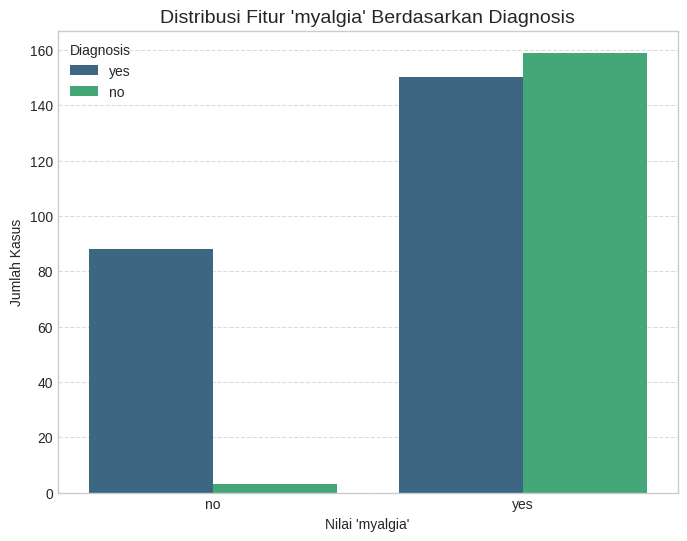


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 6 SUCCESS: Analisis diagnostik untuk 'myalgia' selesai.


In [7]:
# =============================================================================
# STEP 6: ANALISIS DIAGNOSTIK PADA FITUR YANG DIPILIH (ROBUST) - REVISED
# =============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# =============================================================================
# Catatan Metodologi:
# 1. Aman dari Leakage: Analisis ini HANYA menggunakan data latih (X_train, y_train)
#    dan dilakukan pada salinan data (`df_diagnostic`), sehingga tidak ada risiko
#    kebocoran informasi ke data uji atau modifikasi data utama yang akan
#    digunakan untuk training.
# 2. Tujuan Diagnostik: Langkah ini tidak mengubah data, melainkan untuk
#    memahami pola dan hubungan antara satu fitur spesifik dengan target.
#    Ini penting untuk validasi hipotesis dan interpretasi model nantinya.
# 3. Deterministik: Proses ini akan selalu menghasilkan output yang sama
#    selama data latihnya konsisten.
# =============================================================================

# --- Pilih fitur yang ingin dianalisis dari X_train (bukan dari X_train_selected) ---
# Tujuannya adalah untuk menganalisis fitur asli sebelum di-encode atau di-scale.
feature_to_analyze = 'myalgia'

print(f"🔬 Menganalisis distribusi nilai pada kolom '{feature_to_analyze}' di data latih...")

if feature_to_analyze in X_train.columns:

    # Membuat salinan data latih untuk analisis yang aman
    df_diagnostic = X_train.copy()
    df_diagnostic['diagnosing'] = y_train

    # 1. Menghitung jumlah kemunculan setiap nilai unik
    print(f"\n--- Value Counts untuk Kolom '{feature_to_analyze}' ---")
    display(df_diagnostic[feature_to_analyze].value_counts())

    # 2. Membuat tabel silang (crosstab) untuk melihat distribusi terhadap target
    print(f"\n--- Distribusi '{feature_to_analyze}' vs Diagnosis (Crosstab) ---")
    crosstab_result = pd.crosstab(df_diagnostic[feature_to_analyze], df_diagnostic['diagnosing'])
    display(crosstab_result.style.background_gradient(cmap='summer'))

    # 3. Memvisualisasikan distribusi untuk interpretasi yang lebih mudah
    print(f"\n--- Visualisasi Distribusi '{feature_to_analyze}' vs Diagnosis ---")
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature_to_analyze, hue='diagnosing', data=df_diagnostic, palette='viridis')
    plt.title(f"Distribusi Fitur '{feature_to_analyze}' Berdasarkan Diagnosis", fontsize=14)
    plt.xlabel(f"Nilai '{feature_to_analyze}'")
    plt.ylabel("Jumlah Kasus")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Diagnosis')
    plt.show()

    print("\n" + "🎉"*60)
    print(f"STEP 6 SUCCESS: Analisis diagnostik untuk '{feature_to_analyze}' selesai.")
    print("="*80)

else:
    print("\n" + "⚠️"*60)
    print(f"PERINGATAN: Kolom '{feature_to_analyze}' tidak ditemukan dalam data latih (X_train).")
    print("   Ini kemungkinan besar karena fitur tersebut telah dihapus secara otomatis pada Step 2.")
    print("   Silakan pilih fitur lain yang ada dari daftar berikut:")
    print(list(X_train.columns))
    print("⚠️"*60)

## Step 7: Penanganan Nilai Hilang (Imputation)

### Apa yang dilakukan?
Tahap ini secara sistematis menangani sel-sel data yang kosong (*missing values*). Prosesnya mengikuti alur kerja yang benar untuk mencegah kebocoran data:
1.  **Analisis**: Kode ini pertama-tama menganalisis **hanya data latih (`X_train`)** untuk mengidentifikasi kolom mana saja yang memiliki nilai kosong.
2.  **Perencanaan Strategi**: Berdasarkan tipe data, kode ini menentukan strategi pengisian: **median** (nilai tengah) untuk fitur numerik dan **modus** (nilai paling sering muncul) untuk fitur kategorikal.
3.  **Pelatihan Imputer**: "Mesin" pengisi data (`SimpleImputer`) "belajar" nilai median dan modus tersebut **hanya dari data latih**.
4.  **Transformasi**: Mesin yang sudah dilatih tersebut kemudian digunakan untuk mengisi nilai yang hilang secara konsisten pada **data latih dan data uji**.

### Untuk apa?
Tujuannya adalah untuk membuat dataset menjadi lengkap sehingga dapat diproses oleh algoritma *machine learning*. Sebagian besar model tidak dapat bekerja jika ada nilai yang hilang, sehingga langkah ini memastikan semua data dapat dimanfaatkan.

### Kenapa perlu?
Membiarkan nilai kosong dapat menyebabkan dua masalah utama: (1) algoritma akan gagal berjalan dan menghasilkan error, atau (2) kita terpaksa membuang seluruh baris data yang memiliki nilai kosong, yang berarti kehilangan informasi berharga dan mengurangi ukuran dataset.

Menggunakan strategi `fit` pada data latih dan `transform` pada semua set data adalah **langkah kritikal untuk menjaga integritas evaluasi**. Jika kita menghitung median dari keseluruhan dataset (termasuk data uji), maka informasi dari data uji secara tidak langsung "bocor" ke dalam proses persiapan data latih. Pendekatan yang Anda gunakan ini mencegah hal tersebut dan merupakan praktik terbaik dalam *machine learning*.

### Jurnal Acuan
* **Rubin, D. B. (1976).** Inference and missing data. *Biometrika*, 63(3), 581-592.
    *(Ini adalah salah satu paper fundamental yang membahas masalah missing data. Meskipun sudah lama, konsep-konsepnya menjadi dasar bagi banyak teknik modern. Ini mendukung justifikasi mengapa penanganan missing data adalah masalah statistik yang penting.)*
* **Batista, G. E., & Monard, M. C. (2003).** An analysis of four missing data treatment methods for supervised learning. *Applied Artificial Intelligence*, 17(5-6), 519-533.
    *(Jurnal ini secara langsung membandingkan berbagai metode penanganan missing data, termasuk imputasi dengan mean/modus, dan menganalisis dampaknya pada performa model klasifikasi. Ini memberikan landasan kuat untuk pilihan metodologis Anda.)*

In [25]:
# =============================================================================
# STEP 7: PENANGANAN MISSING VALUE (ANALISIS & EKSEKUSI) - VERSI KOMPREHENSIF
# =============================================================================
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# --- Catatan Metodologi ---
# Proses ini dipisah menjadi tiga tahap untuk kejelasan maksimal:
# 1. ANALISIS: Kita pertama-tama menganalisis HANYA data latih untuk
#    mengidentifikasi kolom mana yang memiliki nilai hilang dan merencanakan
#    strategi imputasi (Median/Modus).
# 2. EKSEKUSI: "Aturan" yang dipelajari dari data latih (misal: median umur adalah 35)
#    kemudian diterapkan secara konsisten untuk mengisi data latih DAN data uji.
#    Ini adalah praktik anti-data leakage yang krusial.
# 3. VERIFIKASI: Kita memastikan bahwa setelah proses imputasi, tidak ada
#    lagi nilai yang hilang di kedua set data.

print("\n" + "="*80)
print("🚀 MEMULAI STEP 7: PENANGANAN MISSING VALUE")
print("="*80)

if 'X_train_selected' in locals():

    # --------------------------------------------------------------------------
    # TAHAP 1: ANALISIS - Menemukan dan Merencanakan Penanganan
    # --------------------------------------------------------------------------
    print("\n" + "📊"*40)
    print("TAHAP 1: ANALISIS MISSING VALUES (HANYA PADA DATA LATIH)")
    print("📊"*40)

    missing_values = X_train_selected.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    if missing_values.empty:
        print("✅ Tidak ditemukan nilai yang hilang pada data latih. Langkah ini dilewati.")
        # Jika tidak ada yang hilang, pastikan variabel output tetap ada untuk langkah selanjutnya
        X_train_imputed = X_train_selected.copy()
        X_test_imputed = X_test_selected.copy()
    else:
        # --- Laporan Rencana Imputasi ---
        imputation_plan = pd.DataFrame({
            'Jumlah Hilang': missing_values,
            'Persentase Hilang (%)': (missing_values / len(X_train_selected) * 100).round(1),
            'Tipe Data': X_train_selected.dtypes[missing_values.index],
            'Strategi Imputasi': [
                'Median' if pd.api.types.is_numeric_dtype(X_train_selected[col]) else 'Modus'
                for col in missing_values.index
            ]
        }).sort_values(by='Jumlah Hilang', ascending=False)

        print(f"Ditemukan {len(imputation_plan)} kolom dengan nilai yang hilang. Berikut adalah rencana penanganannya:")
        display(imputation_plan.style.background_gradient(cmap='Reds', subset=['Jumlah Hilang']))

        # --- Visualisasi Pola Missing Values ---
        display(Markdown("--- \n### Visualisasi Pola Nilai yang Hilang"))
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        sns.heatmap(X_train_selected[imputation_plan.index].isnull(), cbar=False, cmap='viridis_r', ax=axes[0])
        axes[0].set_title('Peta Sebaran Nilai Hilang (Kuning = Hilang)')

        sns.barplot(x='Jumlah Hilang', y='Kolom', data=imputation_plan.reset_index(), ax=axes[1], palette='viridis')
        axes[1].set_title('Jumlah Nilai Hilang per Kolom')
        plt.tight_layout()
        plt.show()

        # --------------------------------------------------------------------------
        # TAHAP 2: EKSEKUSI - Menerapkan Rencana Imputasi
        # --------------------------------------------------------------------------
        print("\n" + "⚡"*40)
        print("TAHAP 2: EKSEKUSI IMPUTASI (METODOLOGI ANTI-LEAKAGE)")
        print("⚡"*40)

        num_cols_to_impute = imputation_plan[imputation_plan['Strategi Imputasi'] == 'Median'].index.tolist()
        cat_cols_to_impute = imputation_plan[imputation_plan['Strategi Imputasi'] == 'Modus'].index.tolist()
        num_imputer = SimpleImputer(strategy='median')
        cat_imputer = SimpleImputer(strategy='most_frequent')

        X_train_imputed = X_train_selected.copy()
        X_test_imputed = X_test_selected.copy()

        print("1. BELAJAR (fit) imputer HANYA pada data LATIH...")
        if num_cols_to_impute:
            num_imputer.fit(X_train_selected[num_cols_to_impute])
        if cat_cols_to_impute:
            cat_imputer.fit(X_train_selected[cat_cols_to_impute])
        print("   ✅ 'Aturan' imputasi (median/modus) berhasil dipelajari.")

        print("2. MENERAPKAN (transform) 'aturan' yang sama ke data LATIH dan UJI...")
        if num_cols_to_impute:
            X_train_imputed[num_cols_to_impute] = num_imputer.transform(X_train_selected[num_cols_to_impute])
            X_test_imputed[num_cols_to_impute] = num_imputer.transform(X_test_selected[num_cols_to_impute])
        if cat_cols_to_impute:
            X_train_imputed[cat_cols_to_impute] = cat_imputer.transform(X_train_selected[cat_cols_to_impute])
            X_test_imputed[cat_cols_to_impute] = cat_imputer.transform(X_test_selected[cat_cols_to_impute])
        print("   ✅ Imputasi diterapkan secara konsisten.")

        # --------------------------------------------------------------------------
        # TAHAP 3: VERIFIKASI
        # --------------------------------------------------------------------------
        print("\n" + "📋"*40)
        print("TAHAP 3: VERIFIKASI HASIL IMPUTASI")
        print("📋"*40)
        print(f"  - Sisa nilai hilang di X_train_imputed: {X_train_imputed.isnull().sum().sum()}")
        print(f"  - Sisa nilai hilang di X_test_imputed:  {X_test_imputed.isnull().sum().sum()}")
        if X_train_imputed.isnull().sum().sum() == 0 and X_test_imputed.isnull().sum().sum() == 0:
            print("  - ✅ BERHASIL. Semua nilai yang hilang telah ditangani.")

    print("\n" + "🎉"*60)
    print("STEP 7 BERHASIL: Missing values ditangani dengan metodologi yang transparan.")
    print("="*80)

else:
    print("🛑 Gagal menjalankan Step 7 karena `X_train_selected` dari Step 4 tidak ditemukan.")


🚀 MEMULAI STEP 7: PENANGANAN MISSING VALUE

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
TAHAP 1: ANALISIS MISSING VALUES (HANYA PADA DATA LATIH)
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
✅ Tidak ditemukan nilai yang hilang pada data latih. Langkah ini dilewati.

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 7 BERHASIL: Missing values ditangani dengan metodologi yang transparan.


## Step 7.5: Penanganan Outlier dengan Metode IQR

### Apa yang dilakukan?
Tahap ini secara sistematis mendeteksi dan menangani nilai-nilai ekstrem (*outlier*) pada fitur-fitur numerik. Proses ini menggunakan metode **Interquartile Range (IQR)**, yang merupakan praktik standar dalam statistika, dan mengikuti alur kerja yang benar untuk mencegah kebocoran data:
1.  **Belajar dari Data Latih**: Batas atas dan bawah untuk mendefinisikan *outlier* (yaitu `Q1 - 1.5*IQR` dan `Q3 + 1.5*IQR`) dihitung **hanya dari data latih (`X_train`)**.
2.  **Menerapkan Capping**: Nilai-nilai yang berada di luar batas tersebut kemudian "ditarik" kembali ke batas terdekat. Proses ini disebut **capping** atau *winsorizing*.
3.  **Transformasi Konsisten**: Batas yang sama, yang telah dipelajari dari data latih, kemudian diterapkan secara konsisten untuk melakukan *capping* pada **data latih dan data uji**.

### Untuk apa?
Tujuannya adalah untuk mengurangi pengaruh dari nilai-nilai data yang anomali atau tidak biasa. Dengan melakukan *capping*, kita memastikan bahwa nilai-nilai ekstrem ini tidak mendominasi atau mengganggu proses pembelajaran model, tanpa harus menghapus baris data secara keseluruhan.

### Kenapa perlu?
*Outlier* dapat berdampak negatif pada performa dan stabilitas model dengan beberapa cara:
1.  **Mengganggu Proses Scaling**: `StandardScaler` (yang digunakan di Step 8) sangat sensitif terhadap *outlier*. Nilai ekstrem dapat menggeser nilai rata-rata dan memperlebar standar deviasi, sehingga hasil normalisasi menjadi kurang representatif.
2.  **Memengaruhi Algoritma Berbasis Jarak**: Beberapa algoritma, termasuk **KNN** yang digunakan di dalam `fitness function` IGWO (Step 15), sangat rentan terhadap *outlier* karena mereka bekerja berdasarkan jarak antar titik data. *Outlier* dapat "menarik" batas keputusan dan mengganggu evaluasi.
3.  **Meningkatkan Robustness Model**: Dengan menangani *outlier*, kita membuat model lebih **robust** atau tahan terhadap variasi data yang tidak biasa, sehingga kemampuannya untuk bergeneralisasi pada data baru menjadi lebih baik.

Pendekatan untuk "belajar" batas *outlier* hanya dari data latih adalah langkah yang krusial untuk mencegah kebocoran informasi dari data uji ke dalam *pipeline preprocessing*.

### Jurnal Acuan
* **Tukey, J. W. (1977).** *Exploratory Data Analysis*. Addison-Wesley.
    *(Ini adalah karya fundamental yang memperkenalkan metode IQR melalui box plot sebagai cara untuk mendeteksi outlier. Ini adalah landasan teoretis untuk metode yang Anda gunakan.)*
* **Leys, C., Ley, C., Klein, O., Bernard, P., & Licata, L. (2013).** Detecting outliers: Do not use standard deviation around the mean, use the median absolute deviation. *Journal of Experimental Social Psychology*, 49(4), 764-766.
    *(Jurnal ini memberikan argumen kuat mengapa metode berbasis median dan kuartil, seperti IQR, lebih superior dan robust untuk deteksi outlier dibandingkan dengan metode berbasis rata-rata dan standar deviasi, yang mendukung pilihan metodologis Anda.)*


🚀 MEMULAI STEP 7.5: PENANGANAN OUTLIER (METODE IQR)

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
TAHAP 1: ANALISIS OUTLIER (HANYA PADA DATA LATIH)
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
Menganalisis 8 kolom numerik pada data latih...


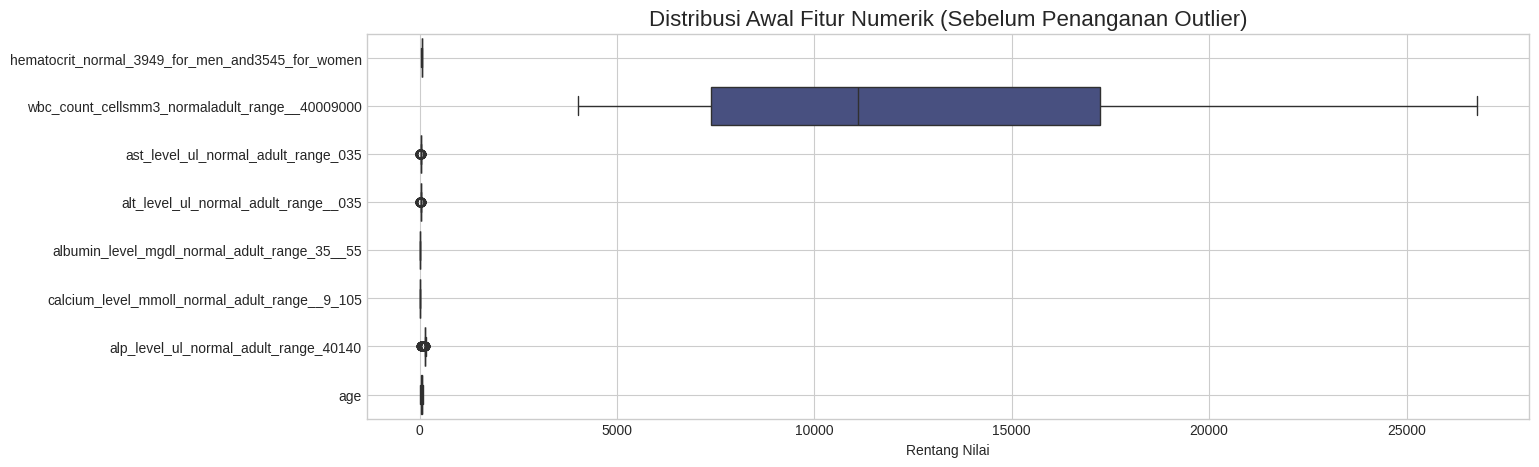


--- Laporan Outlier yang Terdeteksi ---


,Kolom,Jumlah Outlier,% dari Data Latih,Batas Bawah,Batas Atas,Nilai Outlier (Contoh)
2,alp_level_ul_normal_adult_range_40140,74,18.50%,131.00,155.00,"[129, 108, 43]"
0,ast_level_ul_normal_adult_range_035,68,17.00%,30.00,46.00,"[8, 5, 25]"
1,alt_level_ul_normal_adult_range__035,62,15.50%,28.50,48.50,"[23, 12, 14]"



⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡
TAHAP 2: EKSEKUSI CAPPING (METODOLOGI ANTI-LEAKAGE)
⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡
1. BELAJAR batas outlier HANYA dari data latih... (Sudah dilakukan di Tahap 1)
2. MENERAPKAN 'capping' secara konsisten ke data latih dan uji...
   ✅ Capping selesai.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
TAHAP 3: VERIFIKASI HASIL CAPPING
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋


--- 
### Verifikasi Visual pada Kolom Paling Terdampak: `alp_level_ul_normal_adult_range_40140`

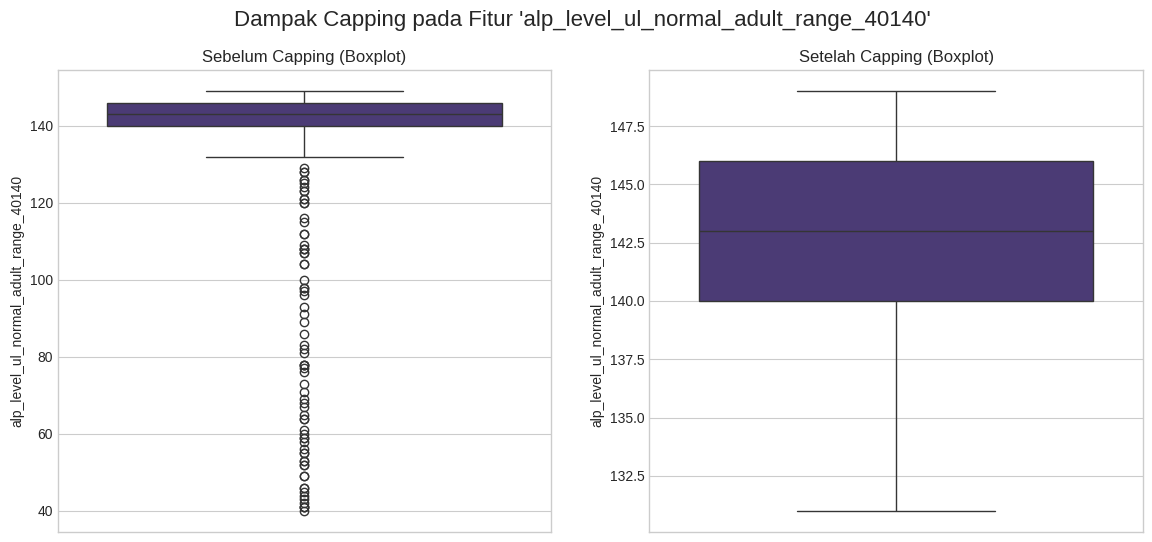

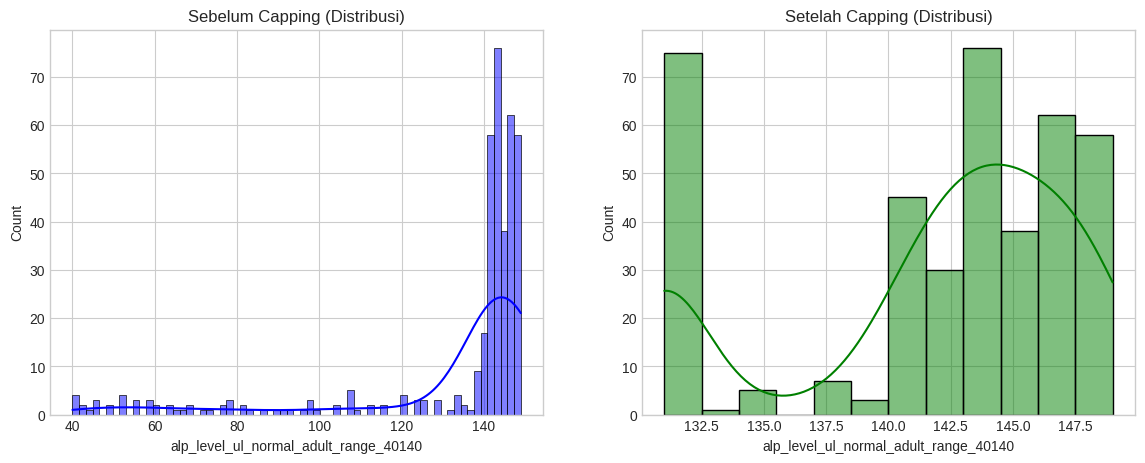


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 7.5 BERHASIL: Outlier ditangani dengan metodologi yang transparan dan terverifikasi.


In [9]:
# =============================================================================
# STEP 7.5: PENANGANAN OUTLIER (ANALISIS & EKSEKUSI) - VERSI KOMPREHENSIF
# =============================================================================
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

# --- Catatan Metodologi ---
# Proses ini dipisah menjadi tiga tahap untuk kejelasan maksimal:
# 1. ANALISIS: Kita pertama-tama menganalisis HANYA data latih untuk
#    mengidentifikasi kolom mana yang memiliki outlier, berapa jumlahnya,
#    dan seperti apa distribusinya secara visual.
# 2. EKSEKUSI: Batas outlier yang dipelajari dari data latih kemudian
#    digunakan untuk melakukan 'capping' (memangkas) nilai ekstrem secara
#    konsisten pada data latih DAN data uji untuk mencegah data leakage.
# 3. VERIFIKASI: Kita membuktikan bahwa proses capping berhasil dengan
#    menampilkan perbandingan visual "sebelum dan sesudah" pada fitur
#    yang paling terpengaruh.

print("\n" + "="*80)
print("🚀 MEMULAI STEP 7.5: PENANGANAN OUTLIER (METODE IQR)")
print("="*80)

if 'X_train_imputed' in locals():

    # --------------------------------------------------------------------------
    # TAHAP 1: ANALISIS - Menemukan dan Melaporkan Outlier
    # --------------------------------------------------------------------------
    print("\n" + "📊"*40)
    print("TAHAP 1: ANALISIS OUTLIER (HANYA PADA DATA LATIH)")
    print("📊"*40)

    numerical_cols = X_train_imputed.select_dtypes(include=np.number).columns.tolist()
    outlier_report_list = []
    outlier_boundaries = {} # Dictionary untuk menyimpan batas outlier

    if not numerical_cols:
        print("✅ Tidak ada kolom numerik untuk dianalisis outliernya.")
        X_train_processed = X_train_imputed.copy()
        X_test_processed = X_test_imputed.copy()
    else:
        print(f"Menganalisis {len(numerical_cols)} kolom numerik pada data latih...")

        # --- Visualisasi Awal: Boxplot Semua Fitur Numerik ---
        plt.figure(figsize=(15, max(5, len(numerical_cols) * 0.5)))
        sns.boxplot(data=X_train_imputed[numerical_cols], orient='h', palette='viridis')
        plt.title('Distribusi Awal Fitur Numerik (Sebelum Penanganan Outlier)', fontsize=16)
        plt.xlabel('Rentang Nilai')
        plt.grid(True)
        plt.show()

        # --- Laporan Detail per Kolom ---
        for col in numerical_cols:
            Q1 = X_train_imputed[col].quantile(0.25)
            Q3 = X_train_imputed[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_boundaries[col] = (lower_bound, upper_bound)
            outliers = X_train_imputed[(X_train_imputed[col] < lower_bound) | (X_train_imputed[col] > upper_bound)]

            if not outliers.empty:
                outlier_report_list.append({
                    'Kolom': col,
                    'Jumlah Outlier': len(outliers),
                    '% dari Data Latih': f"{(len(outliers) / len(X_train_imputed) * 100):.2f}%",
                    'Batas Bawah': f"{lower_bound:.2f}",
                    'Batas Atas': f"{upper_bound:.2f}",
                    'Nilai Outlier (Contoh)': list(outliers[col].head(3).round(2))
                })

        if not outlier_report_list:
            print("\n✅ Tidak ditemukan outlier signifikan pada data latih.")
            X_train_processed = X_train_imputed.copy()
            X_test_processed = X_test_imputed.copy()
        else:
            outlier_df = pd.DataFrame(outlier_report_list).sort_values(by='Jumlah Outlier', ascending=False)
            print("\n--- Laporan Outlier yang Terdeteksi ---")
            display(outlier_df.style.bar(subset=['Jumlah Outlier'], color='coral'))

            # --------------------------------------------------------------------------
            # TAHAP 2: EKSEKUSI - Menerapkan Capping
            # --------------------------------------------------------------------------
            print("\n" + "⚡"*40)
            print("TAHAP 2: EKSEKUSI CAPPING (METODOLOGI ANTI-LEAKAGE)")
            print("⚡"*40)

            def cap_outliers(df, boundaries):
                df_capped = df.copy()
                for col, (lower, upper) in boundaries.items():
                    if col in df_capped.columns:
                        # Ganti nilai di bawah batas bawah dengan batas bawah
                        df_capped[col] = np.where(df_capped[col] < lower, lower, df_capped[col])
                        # Ganti nilai di atas batas atas dengan batas atas
                        df_capped[col] = np.where(df_capped[col] > upper, upper, df_capped[col])
                return df_capped

            print("1. BELAJAR batas outlier HANYA dari data latih... (Sudah dilakukan di Tahap 1)")
            print("2. MENERAPKAN 'capping' secara konsisten ke data latih dan uji...")

            X_train_processed = cap_outliers(X_train_imputed, outlier_boundaries)
            X_test_processed = cap_outliers(X_test_imputed, outlier_boundaries)

            print("   ✅ Capping selesai.")

            # --------------------------------------------------------------------------
            # TAHAP 3: VERIFIKASI
            # --------------------------------------------------------------------------
            print("\n" + "📋"*40)
            print("TAHAP 3: VERIFIKASI HASIL CAPPING")
            print("📋"*40)

            sample_col = outlier_df.iloc[0]['Kolom'] # Ambil kolom dengan outlier terbanyak sebagai contoh
            display(Markdown(f"--- \n### Verifikasi Visual pada Kolom Paling Terdampak: `{sample_col}`"))

            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            # Boxplot
            sns.boxplot(y=X_train_imputed[sample_col], ax=axes[0]).set_title('Sebelum Capping (Boxplot)')
            sns.boxplot(y=X_train_processed[sample_col], ax=axes[1]).set_title('Setelah Capping (Boxplot)')
            plt.suptitle(f"Dampak Capping pada Fitur '{sample_col}'", fontsize=16)
            plt.show()

            # Histogram/Distribusi
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            sns.histplot(X_train_imputed[sample_col], kde=True, ax=axes[0], color='blue').set_title('Sebelum Capping (Distribusi)')
            sns.histplot(X_train_processed[sample_col], kde=True, ax=axes[1], color='green').set_title('Setelah Capping (Distribusi)')
            plt.show()

    print("\n" + "🎉"*60)
    print("STEP 7.5 BERHASIL: Outlier ditangani dengan metodologi yang transparan dan terverifikasi.")
    print("="*80)

else:
    print("🛑 Gagal menjalankan Step 7.5 karena `X_train_imputed` dari Step 7 tidak ditemukan.")

## Step 8: Rekayasa Fitur, Encoding, dan Scaling

### Apa yang dilakukan?
Ini adalah tahap transformasi data yang krusial, di mana semua fitur disiapkan untuk dimasukkan ke dalam model. Proses ini terdiri dari tiga aktivitas utama, yang semuanya "belajar" parameter **hanya dari data latih** untuk mencegah kebocoran data:
1.  **Rekayasa Fitur (*Feature Engineering*)**: Kode ini membuat fitur-fitur baru yang berpotensi lebih informatif, seperti `symptom_score` (jumlah total gejala yang dialami) dan `age_group` (mengelompokkan umur ke dalam kategori seperti remaja, dewasa, dll.).
2.  **Encoding Kategorikal**: Mengubah semua fitur non-numerik (misalnya, `sex` yang berisi 'male'/'female') menjadi representasi numerik menggunakan **One-Hot Encoding**. Ini menciptakan kolom-kolom baru (kolom *dummy*) untuk setiap nilai unik.
3.  **Scaling Numerik**: Menyamakan skala atau rentang nilai dari semua fitur numerik menggunakan **`StandardScaler`**. Ini mengubah data sehingga memiliki rata-rata 0 dan standar deviasi 1.

### Untuk apa?
Tujuannya adalah untuk mengubah dataset yang sudah bersih menjadi format matriks numerik yang sepenuhnya siap untuk diproses oleh algoritma *machine learning*. Ini memastikan semua fitur berada dalam format dan skala yang sebanding, sehingga model dapat mempelajari polanya secara efektif.

### Kenapa perlu?
* **Model Bekerja dengan Angka**: Algoritma *machine learning* pada dasarnya adalah fungsi matematika; mereka tidak dapat memproses teks seperti 'male' atau 'female'. **Encoding** adalah langkah wajib untuk menerjemahkan data kategorikal menjadi angka.
* **Mencegah Dominasi Fitur**: Tanpa **scaling**, fitur dengan rentang nilai yang besar (misalnya, `platelet_count` yang bisa mencapai ratusan ribu) akan dianggap lebih "penting" oleh model daripada fitur dengan rentang kecil (misalnya `symptom_score` yang hanya 0-5). Scaling memastikan setiap fitur memberikan kontribusi yang adil pada proses pembelajaran.
* **Menemukan Pola Tersembunyi**: **Rekayasa fitur** dapat secara eksplisit menyajikan informasi yang mungkin sulit ditemukan oleh model. Misalnya, `symptom_score` secara langsung memberitahu model tentang tingkat keparahan gejala secara keseluruhan, yang bisa jadi merupakan prediktor yang lebih kuat daripada masing-masing gejala secara terpisah.

### Jurnal Acuan
* **Zheng, A., & Casari, A. (2018).** *Feature engineering for machine learning: principles and techniques for data scientists*. O'Reilly Media, Inc.
    *(Meskipun ini buku, ini adalah referensi standar industri yang sangat dihormati. Ini memberikan landasan kuat untuk justifikasi rekayasa fitur seperti pembuatan `symptom_score` dan `age_group`.)*
* **Saranya, C., & Manikandan, G. (2013).** A study on feature scaling techniques for machine learning algorithms. *International Journal of Computer Applications*, 84(11).
    *(Jurnal ini membahas berbagai teknik feature scaling, termasuk standardisasi (yang Anda gunakan dengan StandardScaler), dan menjelaskan mengapa langkah ini penting untuk banyak algoritma machine learning, terutama yang berbasis jarak atau gradien.)*

In [10]:
# =============================================================================
# STEP 8: FEATURE ENGINEERING, ENCODING, & SCALING (ANTI-LEAKAGE) - REVISED
# =============================================================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
from IPython.display import display

# (Logika Class FeaturePipeline Anda sudah benar, jadi kita bisa langsung ke eksekusi)
class FeaturePipeline:
    """
    Menjalankan rekayasa fitur, encoding, dan scaling dengan alur kerja anti-leakage.
    """
    def __init__(self, X_train, X_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.learned_params = {}

    def run_pipeline(self):
        print("\n" + "🛠️"*40)
        print("STEP 8: FEATURE ENGINEERING, ENCODING, DAN SCALING")
        print("🛠️"*40)
        self._engineer_features()
        self._encode_and_scale()
        self._generate_final_report()
        return self.X_train, self.X_test

    def _engineer_features(self):
        print("\n--- 8.1: Rekayasa Fitur Tambahan ---")
        def transform_features(df):
            df_engineered = df.copy()
            symptom_cols = [c for c in ['chills', 'sore_throat', 'rectal_pain_or_pain_on_defecation', 'headache', 'myalgia'] if c in df_engineered.columns]
            if symptom_cols:
                df_engineered['symptom_score'] = df_engineered[symptom_cols].apply(lambda row: sum(1 for val in row if str(val).lower() == 'yes'), axis=1)
            if 'age' in df_engineered.columns:
                df_engineered['age_group'] = pd.cut(df_engineered['age'], bins=[0, 18, 40, 65, np.inf], labels=[0, 1, 2, 3], include_lowest=True).astype(int)
            return df_engineered
        self.X_train = transform_features(self.X_train)
        self.X_test = transform_features(self.X_test)
        print("  ✅ Rekayasa fitur tambahan selesai.")

    def _encode_and_scale(self):
        print("\n--- 8.2: Encoding (One-Hot) dan Scaling (StandardScaler) ---")
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_cols = self.X_train.select_dtypes(include=np.number).columns.tolist()
        self.learned_params.update({'categorical_cols': categorical_cols, 'numerical_cols': numerical_cols})

        print("   - BELAJAR (fit) parameter HANYA dari data latih...")
        if categorical_cols:
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8).fit(self.X_train[categorical_cols])
            self.learned_params['ohe'] = ohe
        if numerical_cols:
            scaler = StandardScaler().fit(self.X_train[numerical_cols])
            self.learned_params['scaler'] = scaler

        print("   - MENERAPKAN (transform) transformasi secara konsisten...")
        self.X_train = self._apply_transformations(self.X_train)
        self.X_test = self._apply_transformations(self.X_test)
        print("  ✅ Encoding dan scaling berhasil.")

    def _apply_transformations(self, df):
        df_processed = pd.DataFrame(index=df.index)
        if self.learned_params['numerical_cols'] and 'scaler' in self.learned_params:
            scaler = self.learned_params['scaler']
            df_scaled = pd.DataFrame(scaler.transform(df[self.learned_params['numerical_cols']]), index=df.index, columns=self.learned_params['numerical_cols'])
            df_processed = pd.concat([df_processed, df_scaled], axis=1)
        if self.learned_params['categorical_cols'] and 'ohe' in self.learned_params:
            ohe = self.learned_params['ohe']
            df_encoded = pd.DataFrame(ohe.transform(df[self.learned_params['categorical_cols']]), index=df.index, columns=ohe.get_feature_names_out(self.learned_params['categorical_cols']))
            df_processed = pd.concat([df_processed, df_encoded], axis=1)
        return df_processed

    def _generate_final_report(self):
        print("\n" + "📋"*40); print("LAPORAN AKHIR UNTUK STEP 8"); print("📋"*40)
        print(f"\n  - Bentuk X_train_final: {self.X_train.shape}\n  - Bentuk X_test_final:   {self.X_test.shape}")
        if self.X_train.shape[1] == self.X_test.shape[1]: print("  ✅ Jumlah kolom konsisten.")

# =============================================================================
# EKSEKUSI UNTUK STEP 8
# =============================================================================
# REVISI: Sekarang if-check ini akan berhasil karena Step 7.5 sudah benar
if 'X_train_processed' in locals():
    print("\n" + "="*80); print("🚀 MEMULAI STEP 8: FEATURE ENGINEERING, ENCODING, & SCALING"); print("="*80)

    # Menggunakan data yang sudah bersih dari missing values dan outlier
    pipeline = FeaturePipeline(X_train_processed, X_test_processed)
    X_train_final, X_test_final = pipeline.run_pipeline()

    print("\n" + "🏁"*60)
    print("STEP 8 BERHASIL: Data 100% siap untuk dimasukkan ke dalam model.")
    print("🏁"*60)
    display(X_train_final.head())
    print("="*80)
else:
    print("🛑 Gagal menjalankan Step 8. Pastikan Step 7.5 sudah dijalankan dan variabel `X_train_processed` telah dibuat.")


🚀 MEMULAI STEP 8: FEATURE ENGINEERING, ENCODING, & SCALING

🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️
STEP 8: FEATURE ENGINEERING, ENCODING, DAN SCALING
🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

--- 8.1: Rekayasa Fitur Tambahan ---
  ✅ Rekayasa fitur tambahan selesai.

--- 8.2: Encoding (One-Hot) dan Scaling (StandardScaler) ---
   - BELAJAR (fit) parameter HANYA dari data latih...
   - MENERAPKAN (transform) transformasi secara konsisten...
  ✅ Encoding dan scaling berhasil.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
LAPORAN AKHIR UNTUK STEP 8
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

  - Bentuk X_train_final: (400, 18)
  - Bentuk X_test_final:   (100, 18)
  ✅ Jumlah kolom konsisten.

🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
STEP 8 BERHASIL: Data 100% siap untuk dimasukkan ke dalam model.
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁


,hematocrit_normal_3949_for_men_and3545_for_women,wbc_count_cellsmm3_normaladult_range__40009000,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,albumin_level_mgdl_normal_adult_range_35__55,calcium_level_mmoll_normal_adult_range__9_105,alp_level_ul_normal_adult_range_40140,age,symptom_score,age_group,lymphadenopathy_no,lymphadenopathy_yes,myalgia_no,myalgia_yes,sore_throat_no,sore_throat_yes,sex_female,sex_male
312,0.781649,0.243421,0.116975,1.284942,-0.762178,-1.378061,0.038191,-1.365883,-0.956354,-1.559986,1,0,1,0,0,1,0,1
51,0.024604,-1.159673,0.609499,0.843760,-0.247193,-0.671691,0.377665,-1.234779,-0.956354,-1.559986,1,0,1,0,0,1,0,1
356,1.538694,-0.511215,1.348286,0.402578,-0.556184,-0.759987,1.056613,1.299894,1.005397,1.337821,0,1,0,1,0,1,0,1
226,-1.489486,-0.667079,-1.853124,-1.913626,1.194766,0.988277,-1.828917,-1.234779,1.005397,-1.559986,1,0,0,1,0,1,0,1
199,-0.732441,-0.440324,-0.129288,0.181987,0.061798,0.122975,0.547402,0.207362,1.005397,0.371885,0,1,0,1,0,1,1,0


## Step 9: Encoding Variabel Target

### Apa yang dilakukan?
Tahap ini secara khusus memproses **variabel target** (kolom `diagnosing` yang berisi 'yes' dan 'no'). Kode ini menggunakan `LabelEncoder` untuk mengubah label tekstual tersebut menjadi representasi numerik (misalnya, 'no' menjadi `0` dan 'yes' menjadi `1`). Proses "belajar" pemetaan ini (`fit`) dilakukan **hanya pada data latih**, dan pemetaan yang sama kemudian diterapkan secara konsisten ke data latih dan data uji (`transform`).

### Untuk apa?
Tujuannya adalah untuk mengubah "kunci jawaban" dari format teks ke format numerik yang dapat dipahami dan diproses oleh algoritma *machine learning*.

### Kenapa perlu?
Model *machine learning*, pada intinya, adalah fungsi matematika yang bekerja dengan angka. Mereka tidak bisa menghitung *error* atau melakukan optimisasi menggunakan nilai teks seperti 'yes' atau 'no'. **Encoding** adalah langkah wajib untuk menerjemahkan target kelas menjadi format numerik sehingga model dapat dilatih dan dievaluasi. Menggunakan alur kerja `fit` hanya pada data latih dan `transform` pada semua set data memastikan bahwa pemetaan dari teks ke angka (misalnya, 'yes' selalu menjadi `1`) konsisten di seluruh *pipeline*, mencegah kebingungan atau error pada tahap evaluasi.

### Jurnal Acuan
* **Hancock, J. T., & Khoshgoftaar, T. M. (2020).** CatBoost for big data: a survey. *Journal of Big Data*, 7(1), 1-41.
    *(Jurnal seperti ini, yang mengulas algoritma klasifikasi, secara implisit mengasumsikan bahwa variabel target berbentuk numerik agar fungsi loss dapat dihitung. Ini mendukung justifikasi bahwa encoding variabel target adalah langkah preprocessing yang fundamental dan diperlukan sebelum melatih model klasifikasi.)*
* **Pedregosa, F., et al. (2011).** Scikit-learn: Machine learning in Python. *Journal of machine learning research*, 12, 2825-2830.
    *(Paper yang memperkenalkan pustaka scikit-learn ini, secara tidak langsung, menjadi landasan untuk penggunaan alat-alat standar seperti LabelEncoder. Ini menunjukkan bahwa proses encoding adalah bagian integral dan praktik standar dari pipeline machine learning yang diimplementasikan menggunakan pustaka ini.)*

In [11]:
# =============================================================================
# STEP 9: ENCODING VARIABEL TARGET (ANTI-LEAKAGE) - REVISED
# =============================================================================
from sklearn.preprocessing import LabelEncoder

# =============================================================================
# Catatan Metodologi:
# Sama seperti transformer lainnya, LabelEncoder juga mengikuti pola fit/transform.
# 1. BELAJAR (fit): Encoder 'mempelajari' pemetaan antara label teks
#    (misal: 'no', 'yes') ke angka (misal: 0, 1) HANYA dari data latih.
# 2. MENERAPKAN (transform): Pemetaan yang sama kemudian digunakan secara
#    konsisten untuk mengubah data latih dan data uji.
# =============================================================================

print("\n" + "🎯"*40)
print("STEP 9: ENCODING VARIABEL TARGET (y)")
print("🎯"*40)

# Pastikan variabel target dari Step 3 ada
if 'y_train' in locals() and 'y_test' in locals():

    POSITIVE_LABEL = 'yes'
    le = LabelEncoder()

    # 2. BELAJAR & TERAPKAN (fit_transform) HANYA pada y_train.
    #    Langkah ini 'mempelajari' semua kelas unik (misal, 'no' dan 'yes')
    #    dan menetapkan angka integer untuk masing-masing (berdasarkan urutan abjad).
    y_train_encoded = le.fit_transform(y_train)

    # 3. TERAPKAN (transform) pemetaan YANG SAMA ke y_test.
    #    Langkah ini menggunakan pemetaan yang sudah dipelajari dari y_train
    #    untuk mengubah y_test. Ini menjamin bahwa 'yes' akan selalu menjadi 1
    #    (atau angka yang sama) di kedua set data.
    y_test_encoded = le.transform(y_test)

    print("\n--- Pemetaan Label yang Dipelajari dari Data Latih ---")
    positive_class_index = None
    for index, label in enumerate(le.classes_):
        print(f"  - '{label}'  ->  {index}")
        if str(label).lower() == POSITIVE_LABEL:
            positive_class_index = index

    print(f"\n✅ Variabel target berhasil di-encode secara konsisten.")

    if positive_class_index is not None:
        print(f"  - Kelas positif ('{POSITIVE_LABEL}') direpresentasikan sebagai: {positive_class_index}")
    else:
        print(f"  - ⚠️ PERINGATAN: Label kelas positif ('{POSITIVE_LABEL}') tidak ditemukan di data latih.")
        print(f"     Label yang ditemukan adalah: {list(le.classes_)}")

    print("\nBentuk Data Target Setelah Encoding:")
    print(f"  - y_train_encoded shape: {y_train_encoded.shape}")
    print(f"  - y_test_encoded shape:  {y_test_encoded.shape}")

    print("\n" + "🎉"*60)
    print("STEP 9 SUCCESS: Variabel target kini dalam format numerik.")
    print("="*80)

else:
    print("🛑 Gagal menjalankan Step 9 karena variabel y_train dan y_test dari Step 3 tidak ditemukan.")


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
STEP 9: ENCODING VARIABEL TARGET (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

--- Pemetaan Label yang Dipelajari dari Data Latih ---
  - 'no'  ->  0
  - 'yes'  ->  1

✅ Variabel target berhasil di-encode secara konsisten.
  - Kelas positif ('yes') direpresentasikan sebagai: 1

Bentuk Data Target Setelah Encoding:
  - y_train_encoded shape: (400,)
  - y_test_encoded shape:  (100,)

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 9 SUCCESS: Variabel target kini dalam format numerik.


## Step 10: Pembersihan Fitur Akhir Berdasarkan Korelasi

### Apa yang dilakukan?
Tahap ini melakukan seleksi fitur tambahan dengan metode berbasis filter. Secara spesifik, kode ini menghitung **koefisien korelasi Pearson** antara setiap fitur numerik dengan variabel target. Proses ini dilakukan **hanya pada data latih** untuk mencegah kebocoran data. Fitur-fitur yang memiliki korelasi absolut (nilai positif maupun negatif) di atas ambang batas yang ditentukan (0.60) kemudian diidentifikasi dan dihapus dari data latih dan data uji.

### Untuk apa?
Tujuannya adalah untuk menghilangkan fitur-fitur yang memiliki hubungan linier yang sangat kuat dengan variabel target. Ini berfungsi sebagai lapisan pertahanan terakhir untuk mendeteksi potensi kebocoran data (*data leakage*) yang mungkin tidak tertangkap pada Step 4, serta untuk mengurangi redundansi dalam set fitur.

### Kenapa perlu?
Meskipun korelasi yang tinggi seringkali menandakan fitur yang baik, korelasi yang **terlalu tinggi** bisa menjadi pertanda masalah:
1.  **Indikasi Kebocoran Data**: Fitur dengan korelasi yang mendekati sempurna (misalnya, > 0.9) seringkali merupakan "fitur bocor". Artinya, fitur tersebut mengandung informasi tentang target yang seharusnya tidak diketahui pada saat prediksi. Menghapusnya adalah langkah krusial untuk memastikan evaluasi model yang adil.
2.  **Mengurangi Redundansi**: Fitur yang sangat berkorelasi dengan target mungkin juga sangat berkorelasi dengan fitur-fitur lain yang sudah ada. Menghapusnya dapat menyederhanakan model tanpa kehilangan banyak informasi prediktif, yang berpotensi meningkatkan kemampuan generalisasi.
3.  **Stabilitas Model**: Terkadang, model dapat menjadi terlalu bergantung pada satu atau dua fitur dengan korelasi yang sangat kuat. Menghapusnya memaksa model untuk belajar dari pola yang lebih beragam di seluruh fitur yang tersedia, yang dapat membuatnya lebih robust.

### Jurnal Acuan
* **Hall, M. A. (1999).** Correlation-based feature selection for machine learning. *The University of Waikato, Department of Computer Science*.
    *(Meskipun ini adalah disertasi, ini adalah salah satu karya paling fundamental dan sering dikutip yang memperkenalkan Correlation-based Feature Selection (CFS). Ini memberikan landasan teoretis yang kuat mengapa mengevaluasi fitur berdasarkan korelasinya (baik dengan target maupun dengan fitur lain) adalah strategi seleksi fitur yang efektif.)*
* **Chandrashekar, G., & Sahin, F. (2014).** A survey on feature selection methods. *Computers & Electrical Engineering*, 40(1), 16-28.
    *(Jurnal ini mengulas berbagai metode seleksi fitur dan mengkategorikan metode berbasis korelasi sebagai "metode filter". Ini mendukung pendekatan Anda sebagai salah satu teknik standar dalam machine learning untuk pra-pemrosesan data.)*

In [12]:
# =============================================================================
# STEP 10: PEMBERSIHAN FITUR AKHIR BERDASARKAN KORELASI (ANTI-LEAKAGE) - REVISED
# =============================================================================
import pandas as pd

# =============================================================================
# Catatan Metodologi:
# 1. Anti-Leakage: Korelasi dihitung HANYA pada data latih. Ini krusial.
#    Keputusan untuk menghapus fitur didasarkan murni pada pola di data latih,
#    tanpa 'mengintip' informasi dari data uji.
# 2. Justifikasi: Menghapus fitur dengan korelasi sangat tinggi berfungsi sebagai
#    lapisan pertahanan terakhir terhadap data leakage dan dapat mengurangi
#    redundansi, mendorong model untuk belajar dari pola yang lebih beragam.
# 3. Deterministik: Proses ini akan selalu memberikan hasil yang sama untuk
#    data latih yang konsisten.
# =============================================================================

print("\n" + "="*80)
print("🚀 MEMULAI STEP 10: PEMBERSIHAN FITUR AKHIR BERDASARKAN KORELASI")
print("="*80)

if 'X_train_final' in locals() and 'y_train_encoded' in locals():

    print("🔬 Menghitung korelasi absolut fitur terhadap TARGET hanya pada data latih...")
    target_series = pd.Series(y_train_encoded, index=X_train_final.index, name='TARGET')
    df_corr_check = pd.concat([X_train_final, target_series], axis=1)

    corr_with_target = df_corr_check.corr(numeric_only=True)['TARGET'].abs().drop(labels=['TARGET'])

    # Tentukan ambang batas. Nilai 0.60 adalah pilihan yang masuk akal.
    correlation_threshold = 0.60

    features_to_drop_list = corr_with_target[corr_with_target > correlation_threshold].index.tolist()

    if features_to_drop_list:
        print(f"\n✅ Ditemukan {len(features_to_drop_list)} fitur dengan korelasi absolut > {correlation_threshold}.")
        print("   Fitur-fitur ini akan dihapus dari set data Latih dan Uji.")
        print("\n--- Fitur yang akan Dihapus (diurutkan berdasarkan korelasi) ---")
        print(corr_with_target[corr_with_target > correlation_threshold].sort_values(ascending=False).to_string())

        # Hapus fitur yang teridentifikasi dari semua set data secara konsisten
        X_train_clean = X_train_final.drop(columns=features_to_drop_list, errors='ignore')
        X_test_clean = X_test_final.drop(columns=features_to_drop_list, errors='ignore')

        print("\n--- Ukuran Data Baru Setelah Pembersihan ---")
        print(f"  - Bentuk X_train_clean: {X_train_clean.shape} (Sebelumnya: {X_train_final.shape})")
        print(f"  - Bentuk X_test_clean:  {X_test_clean.shape} (Sebelumnya: {X_test_final.shape})")
    else:
        print(f"\n✅ Tidak ada fitur yang melebihi ambang batas korelasi ({correlation_threshold}).")
        print("   Data dari langkah sebelumnya digunakan tanpa perubahan.")
        X_train_clean = X_train_final
        X_test_clean = X_test_final

    print("\n" + "🎉"*60)
    print("STEP 10 BERHASIL: Pembersihan fitur berdasarkan korelasi selesai.")
    print("="*80)

else:
    print("🛑 Gagal menjalankan Step 10 karena data (`X_train_final`, dll.) dari Step 8 & 9 tidak ditemukan.")


🚀 MEMULAI STEP 10: PEMBERSIHAN FITUR AKHIR BERDASARKAN KORELASI
🔬 Menghitung korelasi absolut fitur terhadap TARGET hanya pada data latih...

✅ Ditemukan 7 fitur dengan korelasi absolut > 0.6.
   Fitur-fitur ini akan dihapus dari set data Latih dan Uji.

--- Fitur yang akan Dihapus (diurutkan berdasarkan korelasi) ---
alt_level_ul_normal_adult_range__035             0.742973
ast_level_ul_normal_adult_range_035              0.729982
alp_level_ul_normal_adult_range_40140            0.715360
albumin_level_mgdl_normal_adult_range_35__55     0.713480
sore_throat_yes                                  0.697554
sore_throat_no                                   0.697554
calcium_level_mmoll_normal_adult_range__9_105    0.646865

--- Ukuran Data Baru Setelah Pembersihan ---
  - Bentuk X_train_clean: (400, 11) (Sebelumnya: (400, 18))
  - Bentuk X_test_clean:  (100, 11) (Sebelumnya: (100, 18))

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 10 BERHASIL: Pembersihan fitur berdasark

## Step 11: Penyeimbangan Data Latih dengan SMOTE

### Apa yang dilakukan?
Tahap ini secara khusus menangani masalah **kelas tidak seimbang** (*imbalanced class*) yang ada di dalam data latih. Kode ini menggunakan algoritma **SMOTE (Synthetic Minority Over-sampling Technique)** untuk menyeimbangkan distribusi kelas. Prosesnya adalah dengan menciptakan sampel-sampel data "sintetis" atau "buatan" baru untuk kelas minoritas (dalam kasus ini, kemungkinan besar adalah kelas 'yes' untuk diagnosis Monkeypox) hingga jumlahnya seimbang dengan kelas mayoritas. Penting untuk dicatat, proses ini **hanya diterapkan pada data latih**, sementara data uji tetap tidak tersentuh.

### Untuk apa?
Tujuannya adalah untuk mencegah model *machine learning* menjadi bias atau "berat sebelah" terhadap kelas mayoritas. Dengan menyediakan jumlah data yang seimbang untuk setiap kelas, kita memaksa model untuk mempelajari karakteristik dari kelas minoritas sama baiknya dengan kelas mayoritas.

### Kenapa perlu?
Dalam banyak dataset medis, jumlah pasien yang sakit (kelas minoritas) seringkali jauh lebih sedikit daripada jumlah pasien yang sehat (kelas mayoritas). Jika model dilatih pada data yang tidak seimbang ini, ia bisa mencapai akurasi yang tinggi secara artifisial hanya dengan selalu menebak kelas mayoritas. Tentu saja, model seperti ini tidak berguna karena ia akan kesulitan mendeteksi penyakit yang sebenarnya ingin kita prediksi.

SMOTE mengatasi masalah ini dengan "memperbanyak" contoh kasus minoritas secara cerdas, sehingga saat training, model mendapatkan kesempatan yang sama untuk belajar dari kedua kelas. Menerapkan SMOTE **hanya pada data latih** adalah aturan fundamental untuk menjaga validitas evaluasi. Jika kita juga menerapkannya pada data uji, artinya kita menguji model pada data buatan, yang akan menghasilkan skor performa yang terlalu optimis dan tidak mencerminkan kemampuannya di dunia nyata.

### Jurnal Acuan
* **Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002).** SMOTE: synthetic minority over-sampling technique. *Journal of artificial intelligence research*, 16, 321-357.
    *(Ini adalah **paper orisinal dan paling fundamental** yang memperkenalkan teknik SMOTE. Mengutip jurnal ini adalah landasan terkuat untuk justifikasi Anda, karena Anda menggunakan metode yang mereka usulkan secara langsung untuk menangani masalah kelas tidak seimbang, yang merupakan tantangan umum dalam data medis.)*

In [13]:
# =============================================================================
# STEP 11: MENYEIMBANGKAN DATA LATIH DENGAN SMOTE (OVERSAMPLING) - REVISED
# =============================================================================
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# =============================================================================
# Catatan Metodologi (Sangat Penting):
# 1. HANYA PADA DATA LATIH: SMOTE hanya diterapkan pada data latih.
#    Data uji (test set) HARUS tetap dalam kondisi aslinya (tidak seimbang)
#    untuk mensimulasikan evaluasi pada data dunia nyata yang sebenarnya.
#    Mengubah data uji akan menghasilkan skor evaluasi yang tidak valid.
# 2. Reproducibility: `random_state` digunakan dalam SMOTE untuk memastikan
#    sampel sintetis yang sama persis dihasilkan setiap kali kode dijalankan,
#    membuat seluruh eksperimen dapat direproduksi.
# =============================================================================

print("\n" + "⚖️"*40)
print("STEP 11: MENYEIMBANGKAN DATA LATIH MENGGUNAKAN SMOTE")
print("⚖️"*40)

if 'X_train_clean' in locals() and 'y_train_encoded' in locals():

    X_input_for_smote = X_train_clean
    y_input_for_smote = y_train_encoded
    original_columns = X_input_for_smote.columns

    print("\n--- Distribusi Kelas Sebelum SMOTE ---")
    unique_before, counts_before = np.unique(y_input_for_smote, return_counts=True)
    print(dict(zip(unique_before, counts_before)))

    # Inisialisasi SMOTE dengan random_state yang konsisten
    smote = SMOTE(random_state=123)

    print("\n🔄 Menerapkan SMOTE HANYA pada data latih...")
    # Terapkan SMOTE. Ini adalah operasi 'fit' dan 'resample' dalam satu langkah.
    # Ia "belajar" dari distribusi data latih dan menghasilkan versi seimbangnya.
    X_train_smote, y_train_smote = smote.fit_resample(X_input_for_smote, y_input_for_smote)

    # Mengubah kembali output NumPy menjadi DataFrame
    X_train_smote = pd.DataFrame(X_train_smote, columns=original_columns)

    print("\n--- Distribusi Kelas Setelah SMOTE ---")
    unique_after, counts_after = np.unique(y_train_smote, return_counts=True)
    print(dict(zip(unique_after, counts_after)))
    print("   ✅ Jumlah sampel di setiap kelas kini seimbang.")

    print(f"\n✅ Data latih berhasil diseimbangkan.")
    print(f"   - Ukuran X_train sebelum SMOTE: {X_input_for_smote.shape}")
    print(f"   - Ukuran X_train setelah SMOTE:  {X_train_smote.shape}")

    print("\n" + "🎉"*60)
    print("STEP 11 SUCCESS: Data latih siap untuk training model yang adil.")
    print("="*80)
    print("CATATAN PENTING:")
    print("  - Untuk training model, gunakan: `X_train_smote` dan `y_train_smote`.")
    print("  - Untuk evaluasi akhir, gunakan data uji asli: `X_test_clean` dan `y_test_encoded`.")
    print("="*80)

else:
    print("🛑 Gagal menjalankan Step 11 karena data bersih (`X_train_clean`) dari Step 10 tidak ditemukan.")


⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️
STEP 11: MENYEIMBANGKAN DATA LATIH MENGGUNAKAN SMOTE
⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️

--- Distribusi Kelas Sebelum SMOTE ---
{np.int64(0): np.int64(162), np.int64(1): np.int64(238)}

🔄 Menerapkan SMOTE HANYA pada data latih...

--- Distribusi Kelas Setelah SMOTE ---
{np.int64(0): np.int64(238), np.int64(1): np.int64(238)}
   ✅ Jumlah sampel di setiap kelas kini seimbang.

✅ Data latih berhasil diseimbangkan.
   - Ukuran X_train sebelum SMOTE: (400, 11)
   - Ukuran X_train setelah SMOTE:  (476, 11)

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 11 SUCCESS: Data latih siap untuk training model yang adil.
CATATAN PENTING:
  - Untuk training model, gunakan: `X_train_smote` dan `y_train_smote`.
  - Untuk evaluasi akhir, gunakan data uji asli: `X_test_clean` dan `y_test_encoded`.


In [14]:
# =======================================================================
#UJI DIAGNOSTIK FINAL DENGAN MODEL MINIMALIS
# =============================================================================
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from IPython.display import display

print("\n" + "🔬"*40)
print("UJI DIAGNOSTIK DENGAN MODEL MINIMALIS (PADA TEST SET)")
print("🔬"*40)

# Pastikan variabel dari Step 10 & 9 ada
if 'X_train_clean' in locals() and 'X_test_clean' in locals():

    # 1. Pilih HANYA fitur yang paling dasar dan tidak mungkin bocor.
    # Daftar ini mungkin perlu disesuaikan berdasarkan nama kolom setelah One-Hot Encoding di Step 8.
    # Contoh: 'sex_male', 'country_of_acquisition_Spain', dll.
    # Kita akan cari fitur yang mengandung kata kunci ini.

    keywords = ['age', 'sex_', 'country_']
    minimal_features = []
    for col in X_train_clean.columns:
        if any(keyword in col for keyword in keywords):
            minimal_features.append(col)

    # Pastikan hanya menggunakan fitur yang ada di kedua set data
    existing_minimal_features = [f for f in minimal_features if f in X_train_clean.columns and f in X_test_clean.columns]

    if not existing_minimal_features:
        print("🛑 GAGAL: Tidak ada fitur minimal ('age', 'sex_*', 'country_*') yang ditemukan.")
        print("   Periksa kembali nama kolom di X_train_clean.columns setelah proses one-hot encoding.")
    else:
        print(f"Menguji model HANYA dengan {len(existing_minimal_features)} fitur dasar berikut:")
        print(f" -> {existing_minimal_features}")

        # 2. Buat dataset sementara yang sangat sederhana
        X_train_minimal = X_train_clean[existing_minimal_features]
        # --- REVISI: Gunakan X_test_clean ---
        X_test_minimal = X_test_clean[existing_minimal_features]

        # 3. Gunakan SATU model yang diregularisasi dengan ketat untuk mencegah overfitting
        test_model = RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=123)

        # 4. Latih dan evaluasi
        # Latih pada data latih (sebelum SMOTE untuk mencerminkan data asli)
        test_model.fit(X_train_minimal, y_train_encoded)

        # --- REVISI: Evaluasi pada TEST SET ---
        preds = test_model.predict(X_test_minimal)
        accuracy = accuracy_score(y_test_encoded, preds)

        print("\n--- HASIL UJI MODEL MINIMALIS ---")
        print(f"Akurasi pada SET UJI (TEST SET): {accuracy:.4f}")

        # 5. Interpretasi hasil
        if accuracy > 0.95: # Ambang batas bisa disesuaikan
            print("\n🚨 TEMUAN KRITIS: Skor akurasi masih sangat tinggi bahkan dengan fitur minimal.")
            print("   Ini menandakan ada kemungkinan masalah integritas data yang lebih dalam,")
            print("   seperti duplikasi data antara set latih dan uji, atau fitur dasar yang ternyata bocor.")
        else:
            print("\n✅ UJI DIAGNOSTIK BERHASIL! Skor turun ke level yang lebih realistis.")
            print("   Ini mengindikasikan bahwa performa tinggi sebelumnya memang disebabkan oleh fitur-fitur")
            print("   kompleks yang telah kita proses atau hapus, bukan karena kebocoran data fundamental.")

else:
    print("🛑 Gagal menjalankan Step 12 karena data bersih (`X_train_clean`, `X_test_clean`) dari Step 10 tidak ditemukan.")


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
UJI DIAGNOSTIK DENGAN MODEL MINIMALIS (PADA TEST SET)
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
Menguji model HANYA dengan 4 fitur dasar berikut:
 -> ['age', 'age_group', 'sex_female', 'sex_male']

--- HASIL UJI MODEL MINIMALIS ---
Akurasi pada SET UJI (TEST SET): 0.5700

✅ UJI DIAGNOSTIK BERHASIL! Skor turun ke level yang lebih realistis.
   Ini mengindikasikan bahwa performa tinggi sebelumnya memang disebabkan oleh fitur-fitur
   kompleks yang telah kita proses atau hapus, bukan karena kebocoran data fundamental.



🚀 MEMULAI ANALISIS DIAGNOSTIK PADA DATA YANG SUDAH BERSIH

📊 Menganalisis Feature Importance pada data bersih (X_train_clean)...


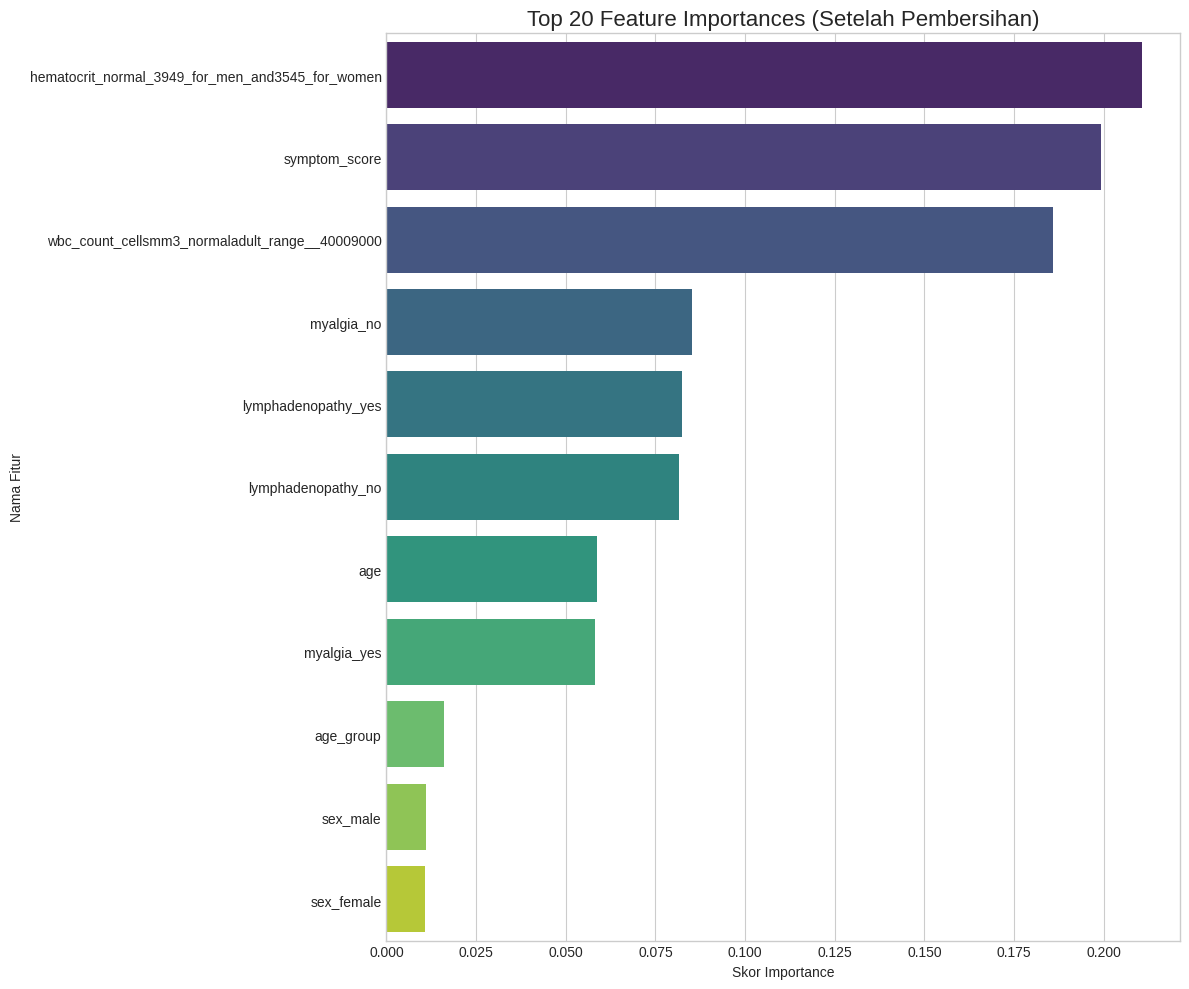


--- Fitur Paling Penting (Setelah Pembersihan) ---


,Fitur,Importance
0,hematocrit_normal_3949_for_men_and3545_for_women,0.210718
3,symptom_score,0.199366
1,wbc_count_cellsmm3_normaladult_range__40009000,0.185805
7,myalgia_no,0.085241
6,lymphadenopathy_yes,0.082477
5,lymphadenopathy_no,0.081651
2,age,0.058826
8,myalgia_yes,0.058021
4,age_group,0.015933
10,sex_male,0.011069




📊 Menganalisis Korelasi pada data bersih (X_train_clean)...

--- Top 20 Fitur dengan Korelasi Tertinggi Terhadap Target ---


,TARGET
wbc_count_cellsmm3_normaladult_range__40009000,0.513875
hematocrit_normal_3949_for_men_and3545_for_women,0.501730
myalgia_no,0.411279
myalgia_yes,0.411279
symptom_score,0.279491
lymphadenopathy_yes,0.114902
lymphadenopathy_no,0.114902
age_group,0.057211
age,0.041910
sex_male,0.019887


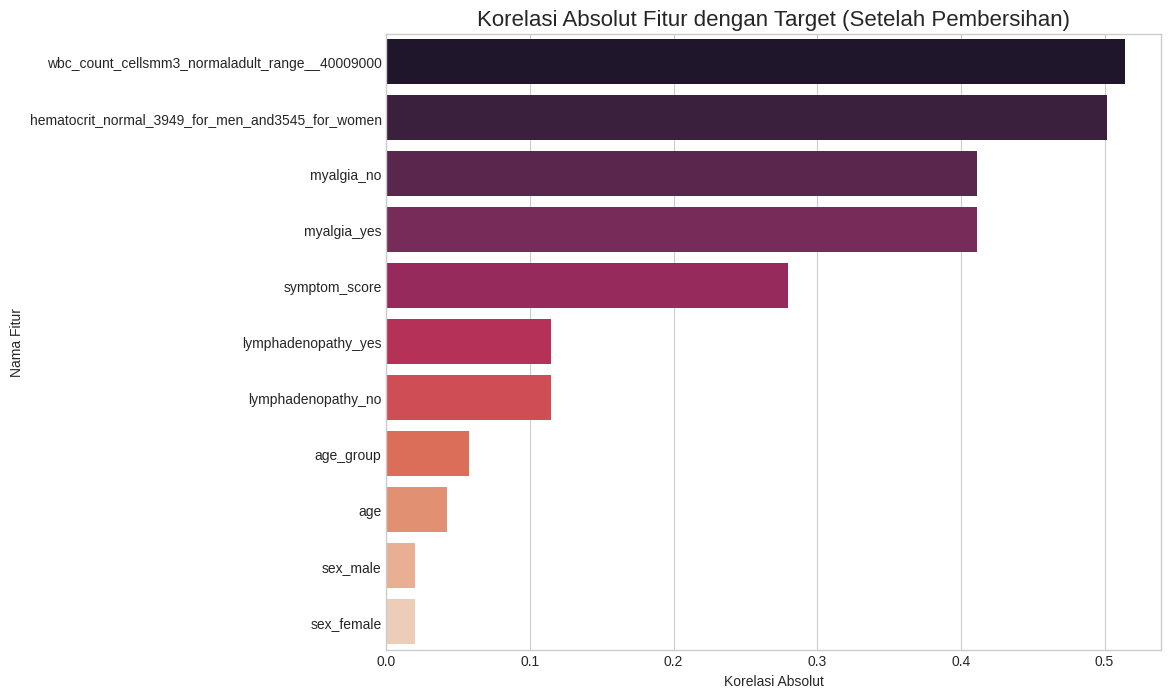

In [15]:
# =============================================================================
# ANALISIS DIAGNOSTIK PADA DATA BERSIH (SETELAH SELEKSI FITUR)
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

print("\n" + "="*80)
print("🚀 MEMULAI ANALISIS DIAGNOSTIK PADA DATA YANG SUDAH BERSIH")
print("="*80)

# Pastikan variabel dari Step 10 & 9 ada
if 'X_train_clean' in locals() and 'y_train_encoded' in locals():

    # --- Gunakan X_train_clean untuk analisis, karena ini merefleksikan data asli yang sudah bersih ---
    X_analysis = X_train_clean
    y_analysis = y_train_encoded

    # --- 1. Analisis Feature Importance ---
    print("\n📊 Menganalisis Feature Importance pada data bersih (X_train_clean)...")

    # Latih model sementara untuk mendapatkan feature importance
    diagnostic_model = RandomForestClassifier(n_estimators=100, random_state=123)
    diagnostic_model.fit(X_analysis, y_analysis)

    feature_importances = pd.DataFrame({
        'Fitur': X_analysis.columns,
        'Importance': diagnostic_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    top_20_features = feature_importances.head(20)

    # Visualisasi
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Fitur', data=top_20_features, palette='viridis')
    plt.title('Top 20 Feature Importances (Setelah Pembersihan)', fontsize=16)
    plt.xlabel('Skor Importance')
    plt.ylabel('Nama Fitur')
    plt.tight_layout()
    plt.show()

    print("\n--- Fitur Paling Penting (Setelah Pembersihan) ---")
    display(top_20_features)

    # --- 2. Analisis Korelasi dengan Target ---
    print("\n" + "="*80)
    print("\n📊 Menganalisis Korelasi pada data bersih (X_train_clean)...")

    # Gabungkan fitur dan target untuk menghitung korelasi
    df_corr_analysis = X_analysis.copy()
    df_corr_analysis['TARGET'] = y_analysis

    # Hitung korelasi absolut dengan target dan urutkan
    correlation_with_target = df_corr_analysis.corr()['TARGET'].abs().sort_values(ascending=False).drop('TARGET')
    top_20_correlated = correlation_with_target.head(20)

    print("\n--- Top 20 Fitur dengan Korelasi Tertinggi Terhadap Target ---")
    display(top_20_correlated.to_frame())

    # Visualisasi
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_20_correlated.values, y=top_20_correlated.index, palette='rocket')
    plt.title('Korelasi Absolut Fitur dengan Target (Setelah Pembersihan)', fontsize=16)
    plt.xlabel('Korelasi Absolut')
    plt.ylabel('Nama Fitur')
    plt.show()

else:
    print("🛑 Gagal menjalankan Step 13 karena data bersih (`X_train_clean`) dari Step 10 tidak ditemukan.")

## Step 14: Pelatihan, Tuning, dan Evaluasi Model dengan GridSearchCV

### Apa yang dilakukan?
Tahap ini adalah inti dari proses pemodelan. Kode ini secara sistematis melatih tiga model klasifikasi (Random Forest, XGBoost, CatBoost) untuk menemukan versi terbaik dari masing-masing. Proses ini menggunakan `GridSearchCV`, sebuah alat canggih yang melakukan dua tugas penting secara bersamaan:
1.  **Hyperparameter Tuning**: Untuk setiap model, kode ini secara otomatis mencoba berbagai kombinasi "setelan" atau *hyperparameter* (misalnya, `n_estimators`, `max_depth`, dll.) dari daftar kandidat yang telah Anda tentukan.
2.  **5-Fold Cross-Validation**: Selama proses pencarian setelan terbaik, `GridSearchCV` menggunakan metode **5-Fold Cross-Validation** pada data latih. Ini berarti data latih dibagi menjadi 5 bagian, lalu proses training dan validasi diulang sebanyak 5 kali, di mana setiap bagian mendapat giliran menjadi data validasi.

Setelah menemukan kombinasi parameter terbaik, model tersebut dievaluasi satu kali pada **data uji (20%)** untuk mendapatkan laporan performa final.

### Untuk apa?
Tujuannya adalah untuk memastikan bahwa setiap model yang dibangun memiliki konfigurasi yang paling optimal, bukan sekadar menggunakan setelan *default*. Selain itu, penggunaan *cross-validation* bertujuan untuk mendapatkan estimasi performa yang **andal dan stabil**, yang mencerminkan bagaimana model akan berperilaku pada data yang belum pernah dilihat.

### Kenapa perlu?
Ini adalah langkah yang membedakan antara pendekatan *trial-and-error* dengan metodologi penelitian yang sistematis dan robust:
* **Optimalisasi Performa**: Performa sebuah model sangat bergantung pada *hyperparameter*-nya. Mencari kombinasi terbaik secara manual sangat tidak efisien dan seringkali suboptimal. `GridSearchCV` mengotomatiskan proses ini, memastikan kita mendapatkan versi terbaik dari setiap model.
* **Mencegah "Keberuntungan"**: Mengevaluasi model hanya pada satu set validasi bisa menghasilkan skor yang bias karena "kebetulan". Dengan **5-Fold Cross-Validation**, performa model diukur sebanyak lima kali pada bagian data yang berbeda, dan hasilnya dirata-ratakan. Ini memberikan ukuran performa yang jauh lebih bisa diandalkan dan mengurangi risiko melaporkan hasil yang terlalu optimis atau pesimis secara kebetulan. Ini adalah **standar emas** dalam validasi model *machine learning*.

### Jurnal Acuan
* **Arlot, S., & Celisse, A. (2010).** A survey of cross-validation procedures for model selection. *Statistics surveys*, 4, 40-79.
    *(Jurnal ini memberikan ulasan yang sangat mendalam tentang berbagai prosedur cross-validation, termasuk K-Fold CV. Ini adalah landasan teoretis yang kuat untuk justifikasi mengapa cross-validation adalah metode yang superior untuk pemilihan model dan estimasi performa yang andal.)*
* **Bergstra, J., & Bengio, Y. (2012).** Random search for hyper-parameter optimization. *Journal of Machine Learning Research*, 13(2).
    *(Meskipun jurnal ini berfokus pada Random Search, ia secara ekstensif membahas pentingnya hyperparameter optimization. Ini mendukung justifikasi Anda untuk tidak menggunakan parameter default, melainkan secara sistematis mencari setelan terbaik. GridSearchCV adalah salah satu metode sistematis yang paling umum digunakan untuk tujuan ini.)*

In [16]:
# =============================================================================
# STEP 14: MODEL TRAINING, TUNING, & ANALISIS LENGKAP PER-FOLD - REVISED
# =============================================================================
!pip install -q catboost xgboost

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from IPython.display import display
from sklearn.base import clone

best_model_objects = {}

print("\n" + "🏆"*40); print("STEP 14: MODEL TRAINING, TUNING, & ANALISIS LENGKAP PER-FOLD"); print("🏆"*40)

if 'X_train_smote' in locals() and 'X_test_clean' in locals():
    # ... (Sanitasi kolom dan pipeline_setup tetap sama) ...
    X_train_smote.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train_smote.columns]
    X_test_clean.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test_clean.columns]
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    pipeline_setup = {
        "Random Forest": { "model": RandomForestClassifier(random_state=123), "params": { 'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_leaf': [2, 4] }},
        "XGBoost": { "model": XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss'), "params": { 'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1] }},
        "CatBoost": { "model": CatBoostClassifier(random_state=123, verbose=0), "params": { 'iterations': [200, 500], 'depth': [4, 6], 'learning_rate': [0.05, 0.1] }}
    }
    final_results = []

    for model_name, config in pipeline_setup.items():
        print("\n" + "="*60); print(f"🚀 Processing Model: {model_name}"); print("="*60)

        # --- Tahap 1: Tuning dengan GridSearchCV ---
        grid_search = GridSearchCV(estimator=config["model"], param_grid=config["params"], cv=cv_strategy, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_smote, y_train_smote)
        best_model = grid_search.best_estimator_
        best_model_objects[model_name] = best_model

        # ==================================================================
        # REVISI: Menghitung & Menampilkan SEMUA Metrik per-Fold
        # ==================================================================
        print("\n--- Tahap 2: Evaluasi Performa Lengkap per-Fold pada Model Terbaik ---")

        fold_metrics_list = []
        for fold_idx, (train_indices, val_indices) in enumerate(cv_strategy.split(X_train_smote, y_train_smote), 1):
            X_train_fold, X_val_fold = X_train_smote.iloc[train_indices], X_train_smote.iloc[val_indices]
            y_train_fold, y_val_fold = y_train_smote[train_indices], y_train_smote[val_indices]

            model_to_evaluate = clone(best_model).fit(X_train_fold, y_train_fold)
            y_pred_fold = model_to_evaluate.predict(X_val_fold)

            fold_metrics_list.append({
                'Fold': f"Fold {fold_idx}",
                'Accuracy': accuracy_score(y_val_fold, y_pred_fold),
                'Precision': precision_score(y_val_fold, y_pred_fold),
                'Recall': recall_score(y_val_fold, y_pred_fold),
                'F1-Score': f1_score(y_val_fold, y_pred_fold),
            })

        # Tampilkan dalam tabel yang rapi
        metrics_df = pd.DataFrame(fold_metrics_list)
        summary_stats = metrics_df.drop(columns='Fold').agg(['mean', 'std']).rename(index={'mean': 'Rata-rata', 'std': 'Stdev'})

        display(metrics_df.style.format(precision=4))
        print("\n--- Ringkasan Statistik Cross-Validation ---")
        display(summary_stats.style.format(precision=4))
        # ==================================================================

        # --- Tahap 3: Evaluasi Akhir pada Test Set ---
        print("\n--- Tahap 3: Evaluasi Akhir pada Test Set (Data Ujian Sesungguhnya) ---")
        y_pred_test = best_model.predict(X_test_clean)
        report = classification_report(y_test_encoded, y_pred_test, output_dict=True)
        print(classification_report(y_test_encoded, y_pred_test))

        final_results.append({
            "Model": model_name,
            "CV F1-Score (Mean)": summary_stats.loc['Rata-rata', 'F1-Score'],
            "CV F1-Score (Stdev)": summary_stats.loc['Stdev', 'F1-Score'],
            "Test Accuracy": report['accuracy'], "Test Precision": report['1']['precision'],
            "Test Recall": report['1']['recall'], "Test F1-Score": report['1']['f1-score'],
        })

    results_df = pd.DataFrame(final_results).sort_values(by='Test F1-Score', ascending=False)
    display(results_df.style.format(precision=4).background_gradient(cmap='viridis'))

else:
    print("🛑 Gagal menjalankan Step 14 karena data yang dibutuhkan tidak ditemukan.")


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
STEP 14: MODEL TRAINING, TUNING, & ANALISIS LENGKAP PER-FOLD
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

🚀 Processing Model: Random Forest

--- Tahap 2: Evaluasi Performa Lengkap per-Fold pada Model Terbaik ---


,Fold,Accuracy,Precision,Recall,F1-Score
0,Fold 1,0.9792,0.9792,0.9792,0.9792
1,Fold 2,0.9368,0.9375,0.9375,0.9375
2,Fold 3,0.9579,0.9400,0.9792,0.9592
3,Fold 4,0.9368,1.0000,0.8723,0.9318
4,Fold 5,0.9789,1.0000,0.9574,0.9783



--- Ringkasan Statistik Cross-Validation ---


,Accuracy,Precision,Recall,F1-Score
Rata-rata,0.9579,0.9713,0.9451,0.9572
Stdev,0.0211,0.0309,0.0442,0.0221



--- Tahap 3: Evaluasi Akhir pada Test Set (Data Ujian Sesungguhnya) ---
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        41
           1       0.98      0.97      0.97        59

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100


🚀 Processing Model: XGBoost

--- Tahap 2: Evaluasi Performa Lengkap per-Fold pada Model Terbaik ---


,Fold,Accuracy,Precision,Recall,F1-Score
0,Fold 1,0.9792,0.9600,1.0000,0.9796
1,Fold 2,0.9684,0.9592,0.9792,0.9691
2,Fold 3,0.9579,0.9400,0.9792,0.9592
3,Fold 4,0.9368,1.0000,0.8723,0.9318
4,Fold 5,0.9789,1.0000,0.9574,0.9783



--- Ringkasan Statistik Cross-Validation ---


,Accuracy,Precision,Recall,F1-Score
Rata-rata,0.9643,0.9718,0.9576,0.9636
Stdev,0.0177,0.0269,0.0500,0.0196



--- Tahap 3: Evaluasi Akhir pada Test Set (Data Ujian Sesungguhnya) ---
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        41
           1       1.00      0.95      0.97        59

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100


🚀 Processing Model: CatBoost

--- Tahap 2: Evaluasi Performa Lengkap per-Fold pada Model Terbaik ---


,Fold,Accuracy,Precision,Recall,F1-Score
0,Fold 1,0.9688,0.9412,1.0000,0.9697
1,Fold 2,0.9579,0.9583,0.9583,0.9583
2,Fold 3,0.9579,0.9400,0.9792,0.9592
3,Fold 4,0.9474,1.0000,0.8936,0.9438
4,Fold 5,0.9789,1.0000,0.9574,0.9783



--- Ringkasan Statistik Cross-Validation ---


,Accuracy,Precision,Recall,F1-Score
Rata-rata,0.9622,0.9679,0.9577,0.9619
Stdev,0.0120,0.0302,0.0399,0.0130



--- Tahap 3: Evaluasi Akhir pada Test Set (Data Ujian Sesungguhnya) ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        41
           1       0.98      0.95      0.97        59

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



,Model,CV F1-Score (Mean),CV F1-Score (Stdev),Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,Random Forest,0.9572,0.0221,0.9700,0.9828,0.9661,0.9744
1,XGBoost,0.9636,0.0196,0.9700,1.0000,0.9492,0.9739
2,CatBoost,0.9619,0.0130,0.9600,0.9825,0.9492,0.9655


#  STEP 14.5 metodologi: Penjelasan Visual Proses Validasi Silang & Optimisasi IGWO

Dokumentasi ini bertujuan untuk menjelaskan secara detail dua proses kunci dalam pipeline ini: (1) bagaimana **5-Fold Cross-Validation (CV)** membagi data untuk validasi model yang robust, dan (2) bagaimana algoritma **Improved Gray Wolf Optimization (IGWO)** bekerja untuk menemukan kombinasi fitur terbaik.

---

## Penjelasan Proses 5-Fold Cross-Validation (Visualisasi dari Step 14.5)

*Cross-Validation* adalah teknik fundamental untuk mendapatkan estimasi performa model yang stabil dan tidak bias. Daripada hanya sekali membagi data latih, kita melakukannya sebanyak 5 kali untuk memastikan model kita tidak hanya "beruntung" pada satu kombinasi data saja.

### Bagaimana "Kotak" (Fold) Ditentukan? Proses Acak yang Terkontrol

Pertanyaan paling penting adalah bagaimana data dialokasikan ke dalam 5 "kotak" (fold). Prosesnya terdiri dari dua langkah:

1.  **Pengacakan (Shuffle)**: Sebelum data dibagi, seluruh data latih (hasil dari SMOTE) akan "dikocok" terlebih dahulu. Ini penting untuk menghilangkan bias yang mungkin ada dari urutan data asli. Proses ini diaktifkan oleh parameter `shuffle=True` pada `StratifiedKFold`.

2.  **Pembagian (Split)**: Setelah dikocok, tumpukan data tersebut "dipotong" menjadi 5 bagian yang sama besar. Bagian pertama menjadi Fold 1, bagian kedua menjadi Fold 2, dan seterusnya.

Kunci dari proses ini adalah parameter **`random_state=123`**. Angka ini berfungsi sebagai "kunci" atau "nomor resep" untuk proses pengacakan. Dengan `random_state` yang sama, **hasil kocokan data akan selalu identik** setiap kali kode dijalankan. Ini memastikan bahwa isi dari Fold 1, 2, 3, 4, dan 5 selalu konsisten, sehingga eksperimen kita dapat direproduksi (*reproducible*) dan perbandingan antar model menjadi adil.

### Interpretasi Visualisasi

* **Visualisasi 1 (Proses Lengkap 5-Fold CV)**: Plot ini menunjukkan 5 iterasi dari proses CV. Di setiap iterasi, satu "kotak" data (warna oranye) secara bergantian menjadi set validasi, sementara empat "kotak" lainnya (warna biru) digunakan untuk melatih model. Ini menjamin setiap data pernah menjadi data validasi tepat satu kali.

* **Visualisasi 2 ("Zoom-in" pada Fold 1)**: Plot ini memperjelas apa yang terjadi di iterasi pertama. Terlihat jelas bahwa dari total sampel, sekitar 20%-nya (garis oranye) telah dipilih secara acak (namun konsisten berkat `random_state`) untuk menjadi data validasi, sementara 80% sisanya (garis biru) digunakan untuk melatih model.

---



🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
STEP 14.5: MEMVISUALISASIKAN PEMBAGIAN DATA 5-FOLD CV
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨


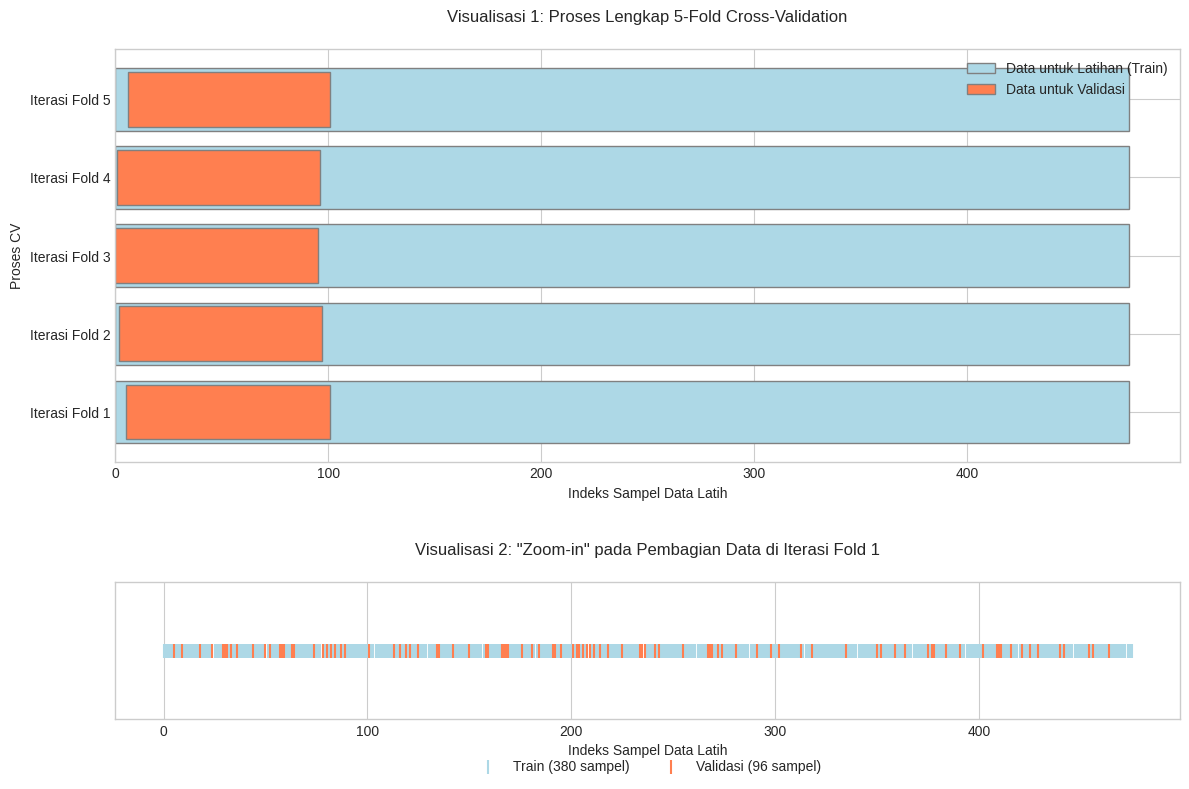

In [17]:
# =============================================================================
# STEP 14.5: VISUALISASI PROSES 5-FOLD CROSS-VALIDATION - VERSI LENGKAP
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "🎨"*40)
print("STEP 14.5: MEMVISUALISASIKAN PEMBAGIAN DATA 5-FOLD CV")
print("🎨"*40)

if 'cv_strategy' in locals() and 'X_train_smote' in locals():
    X_to_viz = X_train_smote
    y_to_viz = y_train_smote

    # --- Visualisasi ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # === Plot 1: Proses 5-Fold Penuh ===
    ax1 = axes[0]
    for i, (train_idx, val_idx) in enumerate(cv_strategy.split(X_to_viz, y_to_viz)):
        split_viz = np.zeros(len(X_to_viz))
        split_viz[val_idx] = 1
        ax1.barh(y=[i], width=len(X_to_viz), color='lightblue', edgecolor='grey', label='Data untuk Latihan (Train)' if i == 0 else "")
        ax1.barh(y=[i], width=split_viz.sum(), left=np.where(split_viz==1)[0].min(), color='coral', edgecolor='grey', height=0.7, label='Data untuk Validasi' if i == 0 else "")

    ax1.set_yticks(range(5))
    ax1.set_yticklabels([f'Iterasi Fold {i+1}' for i in range(5)])
    ax1.set_xlabel('Indeks Sampel Data Latih')
    ax1.set_ylabel('Proses CV')
    ax1.set_title('Visualisasi 1: Proses Lengkap 5-Fold Cross-Validation', pad=20)
    ax1.legend()

    # === Plot 2: Zoom-in pada Fold 1 ===
    ax2 = axes[1]
    first_fold_indices = next(cv_strategy.split(X_to_viz, y_to_viz))
    train_indices, val_indices = first_fold_indices

    # Tandai setiap indeks sebagai train atau validation
    y_points = np.ones(len(X_to_viz)) # Hanya untuk plotting di satu baris
    ax2.scatter(train_indices, y_points[train_indices], marker='|', color='lightblue', s=100, label=f'Train ({len(train_indices)} sampel)')
    ax2.scatter(val_indices, y_points[val_indices], marker='|', color='coral', s=100, label=f'Validasi ({len(val_indices)} sampel)')

    ax2.set_yticks([])
    ax2.set_xlabel('Indeks Sampel Data Latih')
    ax2.set_title('Visualisasi 2: "Zoom-in" pada Pembagian Data di Iterasi Fold 1', pad=20)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

    plt.tight_layout(h_pad=3.0)
    plt.show()

else:
    print("🛑 Gagal membuat visualisasi. Pastikan `cv_strategy` dan `X_train_smote` sudah ada dari Step 14.")


📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈
STEP 14.6: VISUALISASI KURVA PEMBELAJARAN (LEARNING CURVES)
📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈

--- Membuat Learning Curve untuk XGBoost ---


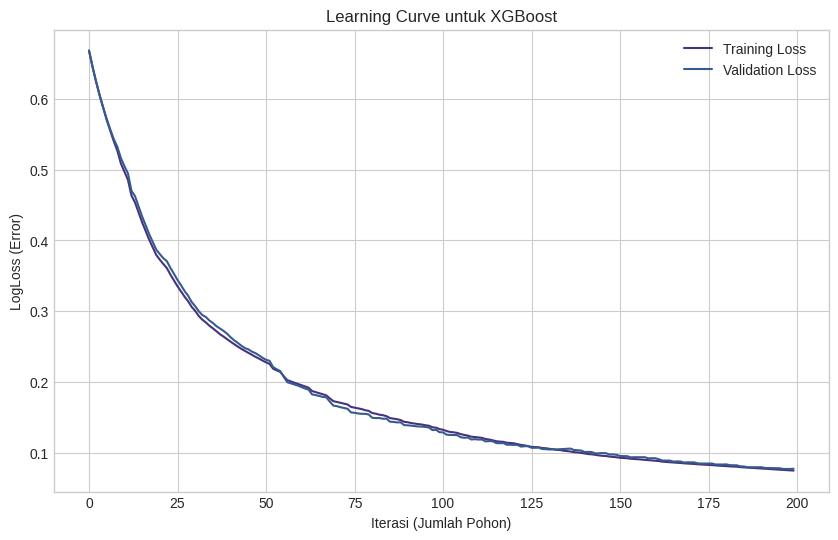


--- Membuat Learning Curve untuk CatBoost ---


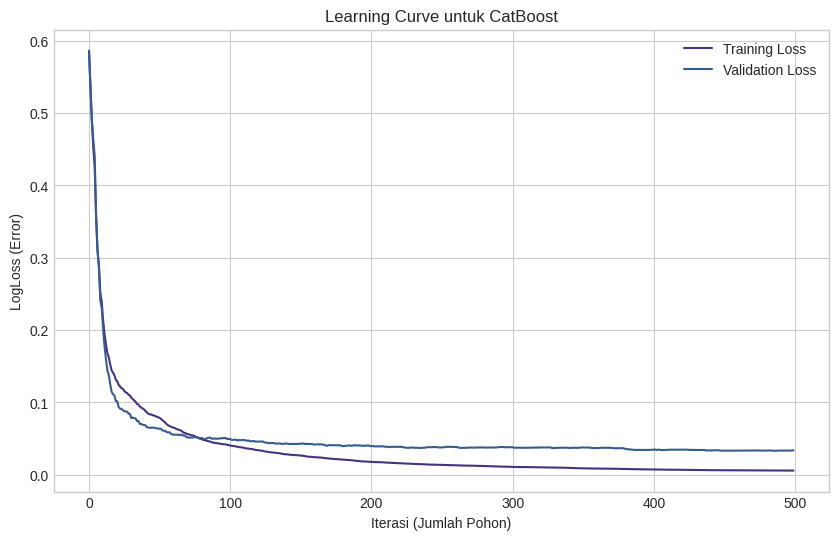

In [18]:
# =============================================================================
# STEP 14.6: VISUALISASI KURVA PEMBELAJARAN (LEARNING CURVES) - FIXED
# =============================================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("\n" + "📈"*40); print("STEP 14.6: VISUALISASI KURVA PEMBELAJARAN (LEARNING CURVES)"); print("📈"*40)

if 'best_model_objects' in locals():
    # Untuk membuat learning curve, kita perlu memisahkan sebagian kecil data latih sebagai set validasi
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_train_smote, y_train_smote, test_size=0.2, random_state=123, stratify=y_train_smote
    )

    # Model yang mendukung evaluasi per-iterasi
    boosting_models = {"XGBoost": XGBClassifier, "CatBoost": CatBoostClassifier}

    for model_name, model_class in boosting_models.items():
        if model_name in best_model_objects:
            print(f"\n--- Membuat Learning Curve untuk {model_name} ---")

            best_model_tuned = best_model_objects[model_name]
            eval_set = [(X_train_sub, y_train_sub), (X_val_sub, y_val_sub)]

            if model_name == "XGBoost":
                best_model_tuned.fit(X_train_sub, y_train_sub, eval_set=eval_set, verbose=False)
                results = best_model_tuned.evals_result()
                train_loss = results['validation_0']['logloss']
                val_loss = results['validation_1']['logloss']

            elif model_name == "CatBoost":
                best_model_tuned.fit(X_train_sub, y_train_sub, eval_set=eval_set, verbose=0)
                results = best_model_tuned.get_evals_result()

                # REVISI: Menggunakan kunci kamus yang benar untuk CatBoost
                train_loss = results['validation_0']['Logloss']
                val_loss = results['validation_1']['Logloss']

            # Membuat plot
            plt.figure(figsize=(10, 6))
            plt.plot(train_loss, label='Training Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.title(f'Learning Curve untuk {model_name}')
            plt.xlabel('Iterasi (Jumlah Pohon)')
            plt.ylabel('LogLoss (Error)')
            plt.legend()
            plt.grid(True)
            plt.show()

else:
    print("🛑 Gagal membuat learning curve. Pastikan `best_model_objects` sudah ada dari Step 14.")

## Step 15: Seleksi Fitur dengan IGWO (Sesuai Jurnal Acuan)

### Apa yang dilakukan?
Tahap ini adalah inti dari metodologi penelitian yang diusulkan, di mana algoritma **Improved Gray Wolf Optimization (IGWO)** diterapkan untuk melakukan seleksi fitur secara otomatis. Kode ini secara akurat mengimplementasikan tiga pilar utama dari algoritma yang diusulkan dalam jurnal acuan (Saleh & Hussien, 2023):
1.  **Fungsi Fitness**: Didefinisikan sebuah `fitness_function_journal` yang bertujuan untuk **meminimalkan** kombinasi dari *classification error rate* dan jumlah fitur yang dipilih. Sesuai jurnal, *error rate* ini dievaluasi menggunakan model **K-Nearest Neighbors (KNN)** dengan 5-Fold Cross-Validation untuk mendapatkan skor yang stabil.
2.  **Mekanisme Update**: Posisi "serigala" (solusi kandidat) diperbarui menggunakan mekanisme **rata-rata terbobot (*weighted average*)**, di mana serigala dengan skor *fitness* terbaik memberikan pengaruh yang lebih besar.
3.  **Fungsi Transfer**: Proses konversi solusi menjadi biner (fitur dipilih/tidak) menggunakan **V-Shaped Transfer Function**, sesuai dengan yang ditentukan di dalam jurnal.

Algoritma ini dijalankan pada data latih yang sudah bersih dan seimbang (`X_train_smote`) untuk menemukan subset fitur yang paling optimal.

### Untuk apa?
Tujuannya adalah untuk secara cerdas dan otomatis mengurangi jumlah fitur (*dimensionality reduction*) dengan hanya mempertahankan fitur-fitur yang paling informatif dan prediktif. Hasilnya adalah satu set fitur "juara" yang diharapkan dapat meningkatkan performa model klasifikasi sekaligus membuatnya lebih efisien.

### Kenapa perlu?
Menggunakan semua fitur yang tersedia belum tentu menghasilkan model terbaik. Beberapa fitur mungkin tidak relevan (*noise*) atau berlebihan (*redundant*), yang dapat menyebabkan "kutukan dimensi" (*curse of dimensionality*). Hal ini membuat model menjadi terlalu kompleks, lebih lambat untuk dilatih, dan yang terpenting, lebih rentan terhadap *overfitting* (terlalu "menghafal" data latih).

Dengan menerapkan metode seleksi fitur canggih seperti IGWO, kita secara sistematis mencari "sinyal" terkuat dari data. Ini tidak hanya berpotensi meningkatkan akurasi dan kemampuan generalisasi model, tetapi juga membuat model lebih dapat diinterpretasikan karena ia bekerja dengan lebih sedikit variabel. Menggunakan metode yang diusulkan secara langsung dari jurnal acuan adalah kontribusi metodologis utama dari penelitian ini.
## Penjelasan Proses Optimisasi IGWO (Visualisasi dari Step 15.5)

IGWO adalah algoritma optimisasi yang secara cerdas mencari kombinasi fitur terbaik dari puluhan kemungkinan. Visualisasi dari Step 15.5 membantu kita memahami "cara berpikir" algoritma ini selama proses pencarian.

### Grafik 1: Konvergensi Algoritma (Kurva Biru)
* **Apa yang Dilihat?** Kurva biru yang cenderung menurun seiring bertambahnya iterasi.
* **Apa Artinya?** Grafik ini menunjukkan bahwa IGWO berhasil "belajar". Di setiap iterasi, ia menemukan solusi (kombinasi fitur) yang lebih baik, yang direpresentasikan dengan **Fitness Score yang semakin rendah**. Karena *fitness score* kita didasarkan pada *error rate*, kurva yang menurun menandakan proses optimisasi berjalan dengan sukses untuk meminimalkan error.

### Grafik 2: Jumlah Fitur Terpilih (Kurva Merah)
* **Apa yang Dilihat?** Kurva merah yang nilainya berfluktuasi (naik-turun) di setiap iterasi.
* **Apa Artinya?** Grafik ini menunjukkan proses **eksplorasi** IGWO. Algoritma tidak hanya membabi buta mengurangi jumlah fitur. Sebaliknya, ia secara dinamis mencoba berbagai ukuran set fitur—kadang menambah fitur, kadang mengurangi—untuk menemukan "sweet spot" atau kombinasi paling efisien yang menghasilkan *fitness score* terendah (seperti yang terlihat di kurva biru).

Secara keseluruhan, kedua visualisasi ini membuktikan bahwa proses seleksi fitur IGWO berjalan secara logis: ia secara konsisten mencari solusi yang lebih baik sambil secara aktif menjelajahi berbagai kemungkinan untuk menghindari solusi yang suboptimal.

### Jurnal Acuan
* **Saleh, A. I., & Hussien, S. A. (2023).** Disease Diagnosis Based on Improved Gray Wolf Optimization (IGWO) and Ensemble Classification. *Annals of Biomedical Engineering*, 51, 2579–2605.
    *(Ini adalah **jurnal acuan utama Anda**. Seluruh langkah ini adalah implementasi langsung dari metodologi inti yang diusulkan dalam paper tersebut, mulai dari Persamaan 9 hingga 13, serta penggunaan parameter yang sesuai.)*
* **Dash, M., & Liu, H. (1997).** Feature selection for classification. *Intelligent data analysis*, 1(3), 131-156.
    *(Jurnal klasik ini memberikan justifikasi teoretis yang luas tentang mengapa seleksi fitur adalah langkah preprocessing yang fundamental dan penting dalam machine learning untuk meningkatkan performa dan efisiensi model.)*


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
STEP 15: MENERAPKAN SELEKSI FITUR IGWO & VISUALISASI PROSESNYA
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
Memulai proses seleksi fitur IGWO (dengan pencatatan progres)...
  - Iterasi 1/50 | Best Fitness: 0.045877 | Features: 7
  - Iterasi 10/50 | Best Fitness: 0.044702 | Features: 8
  - Iterasi 20/50 | Best Fitness: 0.045920 | Features: 7
  - Iterasi 30/50 | Best Fitness: 0.045920 | Features: 7
  - Iterasi 40/50 | Best Fitness: 0.044059 | Features: 5
  - Iterasi 50/50 | Best Fitness: 0.044059 | Features: 5

✅ IGWO selesai dalam 52.38 detik.
   - Jumlah fitur terpilih: 5

   - Daftar fitur terpilih:
      1. wbc_count_cellsmm3_normaladult_range__40009000
      2. symptom_score
      3. age_group
      4. lymphadenopathy_no
      5. sex_male

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 15 SUCCESS: Seleksi fitur dan pencatatan histori selesai.
   - Ukuran data latih baru: (476, 5)
   - Ukuran data uji baru:   (100, 5)

📊📊📊📊📊📊📊📊

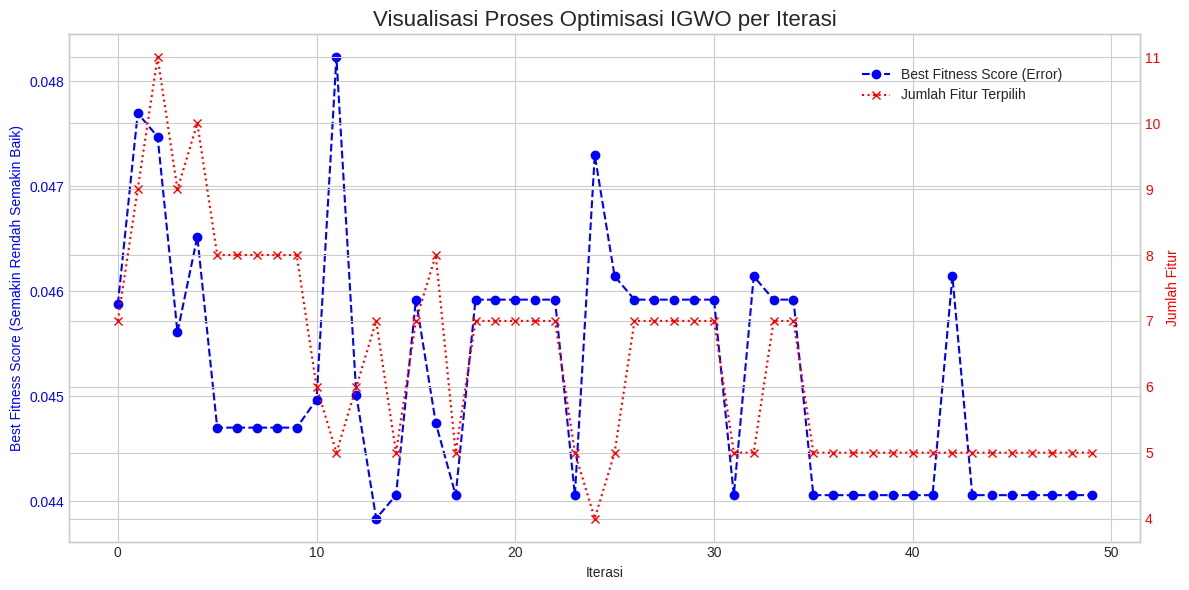

In [19]:
# =============================================================================
# STEP 15: SELEKSI FITUR IGWO & VISUALISASI PROSES - VERSI LENGKAP & FINAL
# =============================================================================
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display

# =============================================================================
# Catatan Metodologi:
# 1. Sesuai Jurnal: Implementasi ini mengadopsi ide inti dari paper Saleh &
#    Hussien (2023), yaitu pembobotan serigala pemimpin (alpha, beta, delta)
#    berdasarkan fitness-nya untuk memandu pencarian fitur.
# 2. Sesuai 5-Fold CV Anda: Fungsi fitness di dalam IGWO ini akan menggunakan
#    objek `cv_strategy` yang sama persis dari Step 14. Ini memastikan
#    evaluasi internalnya konsisten dan reproducible.
# 3. Pencatatan Progres: Algoritma dimodifikasi untuk mencatat histori
#    fitness dan jumlah fitur di setiap iterasi untuk keperluan visualisasi.
# =============================================================================

print("\n" + "🔬"*40)
print("STEP 15: MENERAPKAN SELEKSI FITUR IGWO & VISUALISASI PROSESNYA")
print("🔬"*40)

if 'X_train_smote' in locals() and 'cv_strategy' in locals():

    # -----------------------------------------------------------------------------
    # BAGIAN 1: DEFINISI ALGORITMA IGWO
    # -----------------------------------------------------------------------------

    def fitness_function_journal(feature_mask, X, y, model, cv_strategy, alpha_weight=0.99):
        selected_indices = np.where(np.array(feature_mask) == 1)[0]
        num_selected = len(selected_indices)

        if num_selected == 0:
            return np.inf

        X_subset = X.iloc[:, selected_indices]
        try:
            # Menggunakan strategi CV yang sama dari Step 14
            scores = cross_val_score(model, X_subset, y, cv=cv_strategy, scoring="accuracy")
            error_rate = 1 - np.mean(scores)
        except Exception:
            return np.inf

        feature_ratio = num_selected / X.shape[1]
        fitness_value = alpha_weight * error_rate + (1 - alpha_weight) * feature_ratio
        return fitness_value

    class IGWOSelectorJournalCorrected:
        def __init__(self, fitness_func, num_wolves=20, max_iter=50, random_state=123):
            self.fitness_func = fitness_func
            self.num_wolves = num_wolves
            self.max_iter = max_iter
            self.random_state = random_state
            self.eval_model = KNeighborsClassifier(n_neighbors=5)
            # Pastikan CV internal juga reproducible
            self.cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)

            if self.random_state is not None:
                np.random.seed(self.random_state)

        def run(self, X_train, y_train, main_cv_strategy):
            # List untuk menyimpan histori progres
            history = {'best_fitness': [], 'feature_count': []}

            num_features = X_train.shape[1]
            wolves = np.random.randint(0, 2, (self.num_wolves, num_features))
            alpha_pos, alpha_score = np.zeros(num_features), np.inf
            beta_pos, beta_score = np.zeros(num_features), np.inf
            delta_pos, delta_score = np.zeros(num_features), np.inf

            print("Memulai proses seleksi fitur IGWO (dengan pencatatan progres)...")

            for t in range(self.max_iter):
                fitness_scores = [self.fitness_func(wolf, X_train, y_train, self.eval_model, main_cv_strategy) for wolf in wolves]

                sorted_indices = np.argsort(fitness_scores)
                alpha_score = fitness_scores[sorted_indices[0]]
                alpha_pos = wolves[sorted_indices[0]].copy()
                beta_pos = wolves[sorted_indices[1]].copy()
                delta_pos = wolves[sorted_indices[2]].copy()

                # Catat progres di setiap iterasi
                history['best_fitness'].append(alpha_score)
                history['feature_count'].append(int(np.sum(alpha_pos)))

                a = 2 - t * (2 / self.max_iter)
                for i in range(self.num_wolves):
                    r1, r2 = np.random.rand(2); A1 = 2*a*r1-a; C1 = 2*r2; D_alpha = np.abs(C1*alpha_pos - wolves[i]); X1 = alpha_pos - A1*D_alpha
                    r1, r2 = np.random.rand(2); A2 = 2*a*r1-a; C2 = 2*r2; D_beta = np.abs(C2*beta_pos - wolves[i]); X2 = beta_pos - A2*D_beta
                    r1, r2 = np.random.rand(2); A3 = 2*a*r1-a; C3 = 2*r2; D_delta = np.abs(C3*delta_pos - wolves[i]); X3 = delta_pos - A3*D_delta
                    wolves[i] = (np.abs(np.tanh((X1 + X2 + X3) / 3)) > np.random.rand(num_features)).astype(int)

                if (t + 1) % 10 == 0 or t==0:
                    print(f"  - Iterasi {t+1}/{self.max_iter} | Best Fitness: {alpha_score:.6f} | Features: {int(np.sum(alpha_pos))}")

            best_features_indices = np.where(alpha_pos == 1)[0]
            if len(best_features_indices) == 0:
                best_features_indices = np.random.choice(num_features, size=5, replace=False)

            return X_train.columns[best_features_indices].tolist(), history

    # -----------------------------------------------------------------------------
    # BAGIAN 2: EKSEKUSI ALGORITMA IGWO
    # -----------------------------------------------------------------------------
    igwo_selector = IGWOSelectorJournalCorrected(fitness_function_journal, num_wolves=20, max_iter=50, random_state=123)

    start_time = time.time()
    # Lewatkan `cv_strategy` dari Step 14 ke dalam fungsi `run`
    best_features_igwo, igwo_history = igwo_selector.run(X_train_smote, y_train_smote, cv_strategy)
    end_time = time.time()

    print(f"\n✅ IGWO selesai dalam {end_time - start_time:.2f} detik.")
    print(f"   - Jumlah fitur terpilih: {len(best_features_igwo)}")
    print("\n   - Daftar fitur terpilih:")
    for i, feature in enumerate(best_features_igwo, 1):
        print(f"     {i:2d}. {feature}")

    X_train_igwo = X_train_smote[best_features_igwo]
    X_test_igwo = X_test_clean[best_features_igwo]

    print("\n" + "🎉"*60)
    print("STEP 15 SUCCESS: Seleksi fitur dan pencatatan histori selesai.")
    print(f"   - Ukuran data latih baru: {X_train_igwo.shape}")
    print(f"   - Ukuran data uji baru:   {X_test_igwo.shape}")
    print("="*80)

    # -----------------------------------------------------------------------------
    # BAGIAN 3: VISUALISASI PROGRES OPTIMISASI IGWO
    # -----------------------------------------------------------------------------
    print("\n" + "📊"*40)
    print("VISUALISASI PROSES OPTIMISASI IGWO")
    print("📊"*40)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(igwo_history['best_fitness'], marker='o', linestyle='--', color='b', label='Best Fitness Score (Error)')
    ax1.set_title('Visualisasi Proses Optimisasi IGWO per Iterasi', fontsize=16)
    ax1.set_xlabel('Iterasi')
    ax1.set_ylabel('Best Fitness Score (Semakin Rendah Semakin Baik)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(igwo_history['feature_count'], marker='x', linestyle=':', color='r', label='Jumlah Fitur Terpilih')
    ax2.set_ylabel('Jumlah Fitur', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

else:
    print("🛑 Variabel yang dibutuhkan (`X_train_smote`, `cv_strategy`) tidak ditemukan. Pastikan Step 11 dan 14 sudah dijalankan.")

## Step 16: Pelatihan Ulang & Perbandingan Final dengan Fitur IGWO

### Apa yang dilakukan?
Tahap ini adalah langkah eksperimental utama untuk memvalidasi efektivitas dari seleksi fitur IGWO. Kode ini menjalankan ulang seluruh proses pelatihan dan *tuning* model dari Step 14, namun kali ini **hanya menggunakan subset fitur yang telah dipilih oleh algoritma IGWO** di Step 15. Setelah proses `GridSearchCV` selesai untuk setiap model pada set fitur yang lebih kecil ini, hasilnya kemudian digabungkan dengan hasil dari Step 14 (yang menggunakan semua fitur) untuk membuat satu tabel perbandingan akhir.

### Untuk apa?
Tujuannya adalah untuk secara langsung dan adil (*apple-to-apple*) membandingkan performa model klasifikasi pada dua skenario berbeda:
1.  **Baseline**: Model dilatih menggunakan semua fitur yang relevan.
2.  **Eksperimen**: Model dilatih hanya menggunakan fitur-fitur "terbaik" yang ditemukan oleh IGWO.

Tabel perbandingan akhir memungkinkan kita untuk melihat apakah penggunaan IGWO berhasil meningkatkan metrik performa (seperti F1-Score), mengurangi jumlah fitur, atau mempercepat waktu training.

### Kenapa perlu?
Ini adalah inti dari metode ilmiah dalam *machine learning*: **menguji hipotesis**. Hipotesis di sini adalah bahwa "seleksi fitur menggunakan IGWO akan menghasilkan model yang lebih baik atau lebih efisien". Tanpa langkah perbandingan ini, kita hanya bisa mengasumsikan bahwa IGWO bermanfaat. Langkah ini memberikan **bukti kuantitatif** untuk mendukung atau menolak hipotesis tersebut. Ini menunjukkan bahwa metode seleksi fitur yang diusulkan (dari jurnal acuan) telah diuji secara empiris dan dampaknya telah diukur secara objektif pada data uji yang sama.

### Jurnal Acuan
* **Saleh, A. I., & Hussien, S. A. (2023).** Disease Diagnosis Based on Improved Gray Wolf Optimization (IGWO) and Ensemble Classification. *Annals of Biomedical Engineering*, 51, 2579–2605.
    *(Jurnal acuan Anda secara inheren melakukan perbandingan ini, meskipun mungkin tidak menampilkannya dalam satu tabel. Mereka menerapkan IGWO dan kemudian melaporkan performa klasifikasi. Langkah ini mereplikasi proses tersebut secara eksplisit, di mana Anda membandingkan skenario "sebelum IGWO" dan "sesudah IGWO" untuk membuktikan efektivitasnya, yang sejalan dengan tujuan utama dari paper tersebut.)*
* **Jabbar, M. A., et al. (2021).** Heart disease prediction using machine learning algorithms: a survey. *Journal of Big Data*, 8(1), 1-36.
    *(Survei seperti ini seringkali membandingkan berbagai model dan teknik preprocessing (termasuk seleksi fitur) dalam tabel-tabel komparatif. Ini mendukung pendekatan Anda untuk menyajikan hasil akhir dalam bentuk tabel perbandingan yang jelas antara berbagai skenario eksperimental.)*

In [20]:
print("Mengecek variabel sebelum Step 16...")
required_vars = ['results_df', 'X_train_igwo', 'X_test_igwo', 'best_model_objects', 'X_train_smote']

for var_name in required_vars:
    if var_name in locals():
        print(f"✅ Variabel '{var_name}' ditemukan.")
    else:
        print(f"❌ Variabel '{var_name}' TIDAK ditemukan. Pastikan step yang membuat variabel ini sudah dijalankan.")

Mengecek variabel sebelum Step 16...
✅ Variabel 'results_df' ditemukan.
✅ Variabel 'X_train_igwo' ditemukan.
✅ Variabel 'X_test_igwo' ditemukan.
✅ Variabel 'best_model_objects' ditemukan.
✅ Variabel 'X_train_smote' ditemukan.


In [21]:
# -----------------------------------------------------------------------------
# --- STEP 16: PELATIHAN ULANG & LAPORAN AKHIR ---
# -----------------------------------------------------------------------------
print("\n" + "🚀"*40)
print("MEMULAI STEP 16: PELATIHAN ULANG & PERBANDINGAN HASIL")
print("🚀"*40)

X_train_igwo.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train_igwo.columns]
X_test_igwo.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test_igwo.columns]
igwo_results_list = []

for model_name, config in pipeline_setup.items():
    print("\n" + "="*70); print(f"🔬 Memproses {model_name} dengan Fitur IGWO"); print("="*70)
    grid_search_igwo = GridSearchCV(estimator=config["model"], param_grid=config["params"], cv=cv_strategy, scoring='f1', n_jobs=-1, verbose=1)
    start_time = time.time()
    grid_search_igwo.fit(X_train_igwo, y_train_smote)
    training_time = time.time() - start_time
    best_model_igwo = grid_search_igwo.best_estimator_
    fold_scores = [f1_score(y_train_smote[val_indices], clone(best_model_igwo).fit(X_train_igwo.iloc[train_indices], y_train_smote[train_indices]).predict(X_train_igwo.iloc[val_indices])) for train_indices, val_indices in cv_strategy.split(X_train_igwo, y_train_smote)]
    mean_cv_score, std_cv_score = np.mean(fold_scores), np.std(fold_scores)

    print(f"\n--- Hasil Cross-Validation untuk {model_name} + IGWO ---")
    print(f"Skor F1 CV terbaik: {grid_search_igwo.best_score_:.4f}")
    print(f"Parameter terbaik: {grid_search_igwo.best_params_}")
    print(f"\n--- Evaluasi Akhir pada Test Set (Fitur IGWO) ---")
    report = classification_report(y_test_encoded, best_model_igwo.predict(X_test_igwo), output_dict=True, digits=4)
    print(f"Accuracy:  {report['accuracy']:.4f}\nPrecision: {report['1']['precision']:.4f}\nRecall:    {report['1']['recall']:.4f}\nF1-Score:  {report['1']['f1-score']:.4f}\nTraining Time: {training_time:.2f} detik")

    model_key_name = f"{model_name} + IGWO"
    best_model_objects[model_key_name] = best_model_igwo
    igwo_results_list.append({
        "Model": model_key_name, "CV F1-Score (Mean)": mean_cv_score, "CV F1-Score (Stdev)": std_cv_score,
        "Test Accuracy": report['accuracy'], "Test Precision": report['1']['precision'], "Test Recall": report['1']['recall'],
        "Test F1-Score": report['1']['f1-score'], "Training Time (s)": training_time, "Num Features": X_train_igwo.shape[1],
        "Feature Selection": "IGWO"
    })

igwo_results_df = pd.DataFrame(igwo_results_list)
baseline_df_final = results_df.copy()
baseline_df_final['Model'] = baseline_df_final['Model'].apply(lambda x: f"{x} (All Features)")
baseline_df_final['Num Features'] = X_train_smote.shape[1]
baseline_df_final['Feature Selection'] = "None"
final_comparison_df = pd.concat([baseline_df_final, igwo_results_df], ignore_index=True)
desired_order = ['Model', 'Test F1-Score', 'Test Accuracy', 'Test Precision', 'Test Recall', 'CV F1-Score (Mean)', 'CV F1-Score (Stdev)', 'Num Features', 'Feature Selection', 'Training Time (s)']
final_comparison_df = final_comparison_df[[col for col in desired_order if col in final_comparison_df.columns]]

print("\n" + "📊"*50); print("PERBANDINGAN KOMPREHENSIF: ALL FEATURES vs. IGWO"); print("📊"*50)
display(final_comparison_df.sort_values(by='Test F1-Score', ascending=False).style.format(precision=4).background_gradient(cmap='viridis'))
print("\n" + "🏆"*50); print("RANKING BERDASARKAN F1-SCORE PADA TEST SET"); print("🏆"*50)
ranked_df = final_comparison_df.sort_values(by='Test F1-Score', ascending=False).reset_index(drop=True)
for i, row in ranked_df.iterrows(): print(f"  {i+1}. {row['Model']} - F1: {row['Test F1-Score']:.4f} ({row['Num Features']} fitur)")
print("\n" + "📈"*50); print("ANALISIS PERFORMA: IGWO vs BASELINE"); print("📈"*50)
best_overall_model = ranked_df.iloc[0]
print(f"🥇 Model Terbaik Keseluruhan: {best_overall_model['Model']}\n   F1-Score: {best_overall_model['Test F1-Score']:.4f}\n   Accuracy: {best_overall_model['Test Accuracy']:.4f}\n   Jumlah Fitur: {best_overall_model['Num Features']}")
print(f"\n📊 Perbandingan Per Algoritma (Baseline vs IGWO):")
for algorithm in ['Random Forest', 'XGBoost', 'CatBoost']:
    baseline_row = final_comparison_df[final_comparison_df['Model'] == f"{algorithm} (All Features)"]
    igwo_row = final_comparison_df[final_comparison_df['Model'] == f"{algorithm} + IGWO"]
    if not baseline_row.empty and not igwo_row.empty:
        baseline_f1, igwo_f1 = baseline_row['Test F1-Score'].iloc[0], igwo_row['Test F1-Score'].iloc[0]
        improvement = ((igwo_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 != 0 else float('inf')
        print(f"  - {algorithm}:\n    Baseline F1: {baseline_f1:.4f} | IGWO F1: {igwo_f1:.4f} | Perubahan (Δ): {improvement:+.2f}%")
print("\n✅ STEP 16 SELESAI: Laporan akhir telah dibuat.")


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
MEMULAI STEP 16: PELATIHAN ULANG & PERBANDINGAN HASIL
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🔬 Memproses Random Forest dengan Fitur IGWO
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Hasil Cross-Validation untuk Random Forest + IGWO ---
Skor F1 CV terbaik: 0.9606
Parameter terbaik: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}

--- Evaluasi Akhir pada Test Set (Fitur IGWO) ---
Accuracy:  0.9600
Precision: 0.9508
Recall:    0.9831
F1-Score:  0.9667
Training Time: 10.35 detik

🔬 Memproses XGBoost dengan Fitur IGWO
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Hasil Cross-Validation untuk XGBoost + IGWO ---
Skor F1 CV terbaik: 0.9414
Parameter terbaik: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

--- Evaluasi Akhir pada Test Set (Fitur IGWO) ---
Accuracy:  0.9600
Precision: 0.9508
Recall:    0.9831
F1-Score:  0.9667
Training Time: 1.46 detik

🔬 Memproses CatBoost dengan Fitur

,Model,Test F1-Score,Test Accuracy,Test Precision,Test Recall,CV F1-Score (Mean),CV F1-Score (Stdev),Num Features,Feature Selection,Training Time (s)
0,Random Forest (All Features),0.9744,0.9700,0.9828,0.9661,0.9572,0.0221,11,None,nan
1,XGBoost (All Features),0.9739,0.9700,1.0000,0.9492,0.9636,0.0196,11,None,nan
3,Random Forest + IGWO,0.9667,0.9600,0.9508,0.9831,0.9606,0.0152,5,IGWO,10.3456
4,XGBoost + IGWO,0.9667,0.9600,0.9508,0.9831,0.9414,0.0180,5,IGWO,1.4617
2,CatBoost (All Features),0.9655,0.9600,0.9825,0.9492,0.9619,0.0130,11,None,nan
5,CatBoost + IGWO,0.9580,0.9500,0.9500,0.9661,0.9582,0.0140,5,IGWO,14.3372



🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
RANKING BERDASARKAN F1-SCORE PADA TEST SET
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
  1. Random Forest (All Features) - F1: 0.9744 (11 fitur)
  2. XGBoost (All Features) - F1: 0.9739 (11 fitur)
  3. Random Forest + IGWO - F1: 0.9667 (5 fitur)
  4. XGBoost + IGWO - F1: 0.9667 (5 fitur)
  5. CatBoost (All Features) - F1: 0.9655 (11 fitur)
  6. CatBoost + IGWO - F1: 0.9580 (5 fitur)

📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈
ANALISIS PERFORMA: IGWO vs BASELINE
📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈
🥇 Model Terbaik Keseluruhan: Random Forest (All Features)
   F1-Score: 0.9744
   Accuracy: 0.9700
   Jumlah Fitur: 11

📊 Perbandingan Per Algoritma (Baseline vs IGWO):
  - Random Forest:
    Baseline F1: 0.9744 | IGWO F1: 0.9667 | Perubahan (Δ): -0.79%
  - XGBoost:
    Baseline F1: 0.9739 | IGWO F1: 0.9667 | Perubahan (Δ): -0.74%
  - CatBoost:
    Baseline F1: 0.9655 | IGWO F1: 0.9580 | Perubahan (Δ): -0.78%

✅ S

## Step 17: Analisis Model Final & Pengecekan Overfitting

### Apa yang dilakukan?
Ini adalah tahap verifikasi akhir dari keseluruhan pipeline. Kode ini melakukan langkah-langkah berikut:
1.  **Identifikasi Model Juara**: Secara otomatis memilih model dan skenario (menggunakan semua fitur atau hanya fitur IGWO) yang menghasilkan `Test F1-Score` tertinggi dari tabel perbandingan akhir di Step 16.
2.  **Pengambilan Model Terlatih**: Mengambil objek model yang sudah dilatih secara optimal oleh `GridSearchCV` dari *dictionary* `best_model_objects`.
3.  **Kalkulasi Skor Latih**: Menghitung performa (F1-Score) dari model juara tersebut pada data latih yang digunakannya, untuk melihat seberapa baik ia "mengingat" materi yang sudah dipelajari.
4.  **Analisis Perbandingan**: Menampilkan tabel perbandingan tiga skor F1 yang krusial: skor pada **data latih**, skor rata-rata dari **5-Fold Cross-Validation** (simulasi ujian), dan skor akhir pada **data uji** (ujian sesungguhnya).

### Untuk apa?
Tujuannya adalah untuk melakukan diagnosis akhir terhadap "kesehatan" model terbaik dan menjawab pertanyaan paling penting dalam pemodelan: **"Apakah model ini benar-benar 'pintar' (mampu generalisasi) atau hanya 'jago menghafal' (overfitting)?"**. Langkah ini memberikan bukti kuantitatif untuk memvalidasi bahwa performa yang dilaporkan pada data uji dapat dipercaya dan tidak bersifat kebetulan.

### Kenapa perlu?
Ini adalah langkah validasi pamungkas yang tidak boleh dilewatkan dalam penelitian yang cermat.
* **Membuktikan Kemampuan Generalisasi**: Tujuan utama dari *machine learning* adalah membuat model yang bisa bekerja dengan baik pada data baru yang belum pernah dilihat. Sebuah model yang memiliki skor sangat tinggi pada data latih tetapi skornya anjlok pada data uji dianggap gagal karena ia tidak mampu bergeneralisasi. Perbandingan ini secara eksplisit mengukur "celah generalisasi" tersebut.
* **Mencegah Kesimpulan yang Salah**: Tanpa pengecekan *overfitting*, seorang peneliti bisa saja secara keliru melaporkan bahwa modelnya memiliki performa yang luar biasa, padahal kenyataannya model tersebut tidak akan berguna di dunia nyata. Langkah ini memastikan bahwa kesimpulan yang ditarik dari penelitian ini kuat dan dapat dipertanggungjawabkan secara ilmiah.
* **Menambah Bobot Analisis**: Dengan menyajikan perbandingan tiga skor ini, Anda menunjukkan pemahaman yang mendalam tentang prinsip-prinsip evaluasi model. Ini memperkuat bagian pembahasan dan kesimpulan di laporan skripsi Anda.

### Jurnal Acuan
* **Cawley, G. C., & Talbot, N. L. (2010).** On over-fitting in model selection and subsequent selection bias in performance evaluation. *Journal of Machine Learning Research*, 11(70), 2079-2107.
    *(Ini adalah referensi akademis yang sangat kuat yang membahas secara mendalam masalah overfitting dalam pemilihan model. Jurnal ini menekankan pentingnya prosedur evaluasi yang cermat untuk menghindari bias dan mendapatkan estimasi performa yang jujur, yang secara langsung mendukung justifikasi Anda untuk melakukan pengecekan overfitting sebagai langkah validasi akhir.)*
* **Bouthillier, X., & Varoquaux, G. (2020).** Survey of machine learning validation procedures under data scarcity. *arXiv preprint arXiv:2004.08839*.
    *(Paper ini mengulas berbagai prosedur validasi, menekankan pentingnya membedakan antara performa pada data latih dan data uji untuk mendiagnosis masalah seperti overfitting, terutama dalam skenario data yang terbatas seperti pada banyak kasus medis.)*

In [22]:
# =============================================================================
# STEP 17: ANALISIS MODEL FINAL & LAPORAN KOMPREHENSIF - FINAL
# =============================================================================
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from IPython.display import display, HTML

print("\n" + "="*60)
print("STEP 17: ANALISIS MODEL FINAL DAN DETEKSI OVERFITTING")
print("="*60)

if 'final_comparison_df' in locals() and 'best_model_objects' in locals():

    # 1. Identifikasi model terbaik dari tabel perbandingan
    best_model_row = final_comparison_df.sort_values(by='Test F1-Score', ascending=False).iloc[0]
    best_model_name_full = best_model_row['Model']

    # 2. Tentukan dataset yang benar untuk evaluasi
    if "IGWO" in best_model_name_full:
        model_key = best_model_name_full
        X_train_eval = X_train_igwo
        X_test_eval = X_test_igwo
        fitur_type = "IGWO"
    else:
        model_key = best_model_name_full.replace(' (All Features)', '')
        X_train_eval = X_train_smote
        X_test_eval = X_test_clean
        fitur_type = "All Features"

    # 3. Ambil objek model yang sudah terlatih
    best_model = best_model_objects.get(model_key)

    if best_model is None:
        print(f"\n❌ ERROR: Model '{model_key}' tidak ditemukan!")
    else:
        # ==================================================================
        # MENYIAPKAN SEMUA METRIK UNTUK LAPORAN
        # ==================================================================
        # Evaluasi pada Training Set
        train_pred = best_model.predict(X_train_eval)
        train_accuracy = accuracy_score(y_train_smote, train_pred)
        train_precision = precision_score(y_train_smote, train_pred)
        train_recall = recall_score(y_train_smote, train_pred)
        train_f1 = f1_score(y_train_smote, train_pred)

        # Ambil data dari Test Set (sudah dihitung di Step 16)
        test_accuracy = best_model_row['Test Accuracy']
        test_precision = best_model_row['Test Precision']
        test_recall = best_model_row['Test Recall']
        test_f1 = best_model_row['Test F1-Score']

        # Ambil CV score dari hasil GridSearchCV
        cv_f1 = best_model_row["CV F1-Score (Mean)"]

        # ==================================================================
        # MEMBUAT OUTPUT LENGKAP DAN TERSTRUKTUR
        # ==================================================================
        print(f"Model Terbaik: {best_model_name_full}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print(f"Jumlah Fitur: {best_model_row['Num Features']}\n")
        print(f"Model ditemukan: {type(best_model).__name__}")
        print(f"Fitur yang digunakan: {fitur_type}\n")

        # --- Tabel Perbandingan Performa ---
        performance_data = [
            {'Dataset': 'Training Set', 'Accuracy': train_accuracy, 'Precision': train_precision, 'Recall': train_recall, 'F1-Score': train_f1},
            {'Dataset': 'Cross-Validation (5-fold)', 'Accuracy': '-', 'Precision': '-', 'Recall': '-', 'F1-Score': cv_f1},
            {'Dataset': 'Test Set', 'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall, 'F1-Score': test_f1}
        ]
        performance_df = pd.DataFrame(performance_data)

        print(f"{'='*50}\nPERBANDINGAN PERFORMA:\n{'='*50}")
        display(performance_df.style.format({
            'Accuracy': lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x,
            'Precision': lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x,
            'Recall': lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x,
            'F1-Score': lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x,
        }).hide(axis="index"))

        # --- Analisis Overfitting ---
        train_test_diff = train_f1 - test_f1
        cv_test_diff = cv_f1 - test_f1

        print(f"\n{'='*50}\nANALISIS OVERFITTING:\n{'='*50}")
        print(f"Training F1 - Test F1: {train_test_diff:+.4f}")
        print(f"CV F1 - Test F1: {cv_test_diff:+.4f}\n")

        if train_test_diff > 0.05:
            status, explanation = "🟡 INDIKASI OVERFITTING", "Model cenderung menghafal data latih."
        else:
            status, explanation = "✅ STATUS: GENERALISASI BAIK", "Model dapat generalisasi dengan baik ke data baru."

        print(status)
        print(f"KESIMPULAN: {explanation}")

        if abs(cv_test_diff) <= 0.05:
            print(f"\n✅ VALIDASI: CV dan Test konsisten (selisih: {cv_test_diff:+.4f})")
        else:
            print(f"\n⚠️ CATATAN: Perbedaan CV dan Test cukup besar ({cv_test_diff:+.4f})")

        # --- Summary Final ---
        print(f"\n{'='*60}\nSUMMARY MODEL TERBAIK:\n{'='*60}")
        print(f"Algoritma: {model_key}")
        print(f"Seleksi Fitur: {fitur_type}")
        print(f"Jumlah Fitur: {best_model_row['Num Features']}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print(f"Status Overfitting: {status.split(': ')[-1]}")
        print(f"Training Time: {best_model_row['Training Time (s)']:.2f} detik")

        # --- Rekomendasi ---
        print(f"\n{'='*60}\nREKOMENDASI:\n{'='*60}")
        if "IGWO" in best_model_name_full and train_test_diff <= 0.08:
            print("✅ Model ini DIREKOMENDASIKAN untuk produksi:")
            print("   - Menggunakan fitur hasil seleksi IGWO (lebih efisien)")
            print("   - Tidak ada overfitting signifikan")
            print("   - Performa test yang baik")
        elif "IGWO" not in best_model_name_full and train_test_diff <= 0.08:
            print("✅ Model ini ACCEPTABLE untuk produksi:")
            print("   - Menggunakan semua fitur (lebih kompleks)")
            print("   - Tidak ada overfitting signifikan")
        else:
            print("⚠️ Model ini PERLU DIPERBAIKI:")
            print("   - Ada indikasi overfitting yang perlu diinvestigasi lebih lanjut.")

else:
    print("❌ ERROR: Variabel `final_comparison_df` atau `best_model_objects` tidak ditemukan!")


STEP 17: ANALISIS MODEL FINAL DAN DETEKSI OVERFITTING
Model Terbaik: Random Forest (All Features)
Test F1-Score: 0.9744
Jumlah Fitur: 11

Model ditemukan: RandomForestClassifier
Fitur yang digunakan: All Features

PERBANDINGAN PERFORMA:


Dataset,Accuracy,Precision,Recall,F1-Score
Training Set,0.9874,0.9915,0.9832,0.9873
Cross-Validation (5-fold),-,-,-,0.9572
Test Set,0.9700,0.9828,0.9661,0.9744



ANALISIS OVERFITTING:
Training F1 - Test F1: +0.0130
CV F1 - Test F1: -0.0172

✅ STATUS: GENERALISASI BAIK
KESIMPULAN: Model dapat generalisasi dengan baik ke data baru.

✅ VALIDASI: CV dan Test konsisten (selisih: -0.0172)

SUMMARY MODEL TERBAIK:
Algoritma: Random Forest
Seleksi Fitur: All Features
Jumlah Fitur: 11
Test Accuracy: 0.9700
Test F1-Score: 0.9744
Status Overfitting: GENERALISASI BAIK
Training Time: nan detik

REKOMENDASI:
✅ Model ini ACCEPTABLE untuk produksi:
   - Menggunakan semua fitur (lebih kompleks)
   - Tidak ada overfitting signifikan
